# 待解決問題
1. 某個record會預測出對應sample_time的target data，但這個target data並不是因為單一record所導致的，而是因為一段record造成的

# 描述性統計
## 變異性
1. 總體變異程度
2. sample slot內的變異程度

In [20]:
import pandas as pd
import numpy as np
import os

In [37]:
result = {}

for file in os.listdir("./processed_data"):
    if file.endswith(".csv"):
        df:pd.DataFrame = pd.read_csv(f"./processed_data/{file}")
        df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
        df['sample_time'] = pd.to_datetime(df['sample_time'])
        result[f'{file.replace(".csv", "")}'] = df

result_keys = list(result.keys())

sample_times = result[result_keys[0]]['sample_time'].unique()

In [38]:
result['API']['VolMode PD3'].unique().shape[0]

2

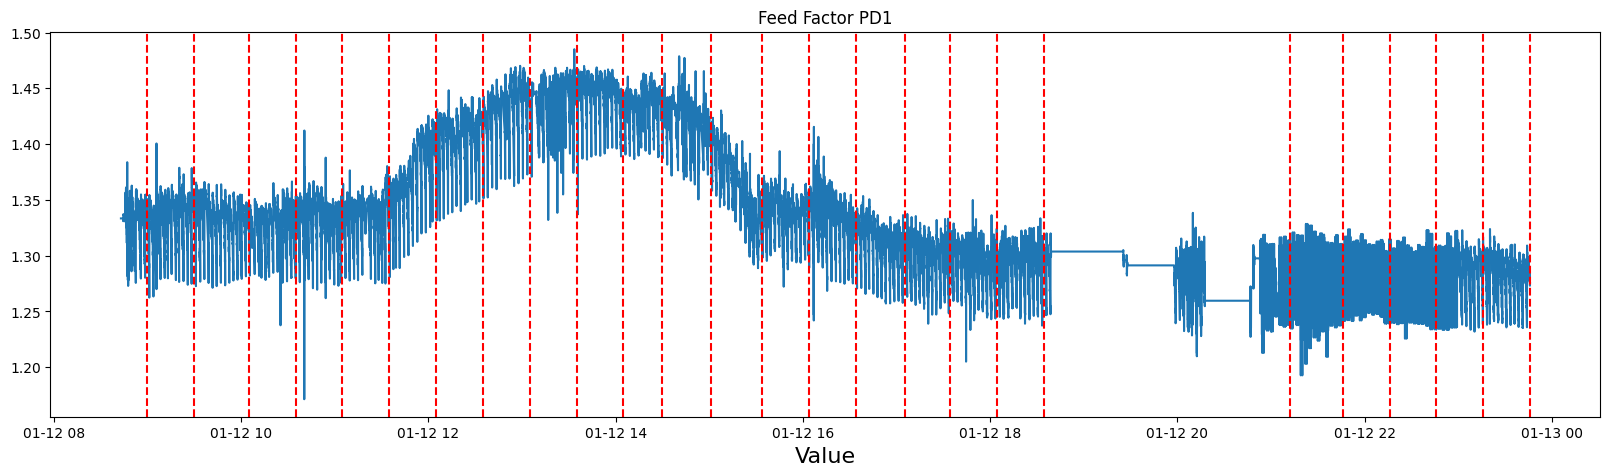

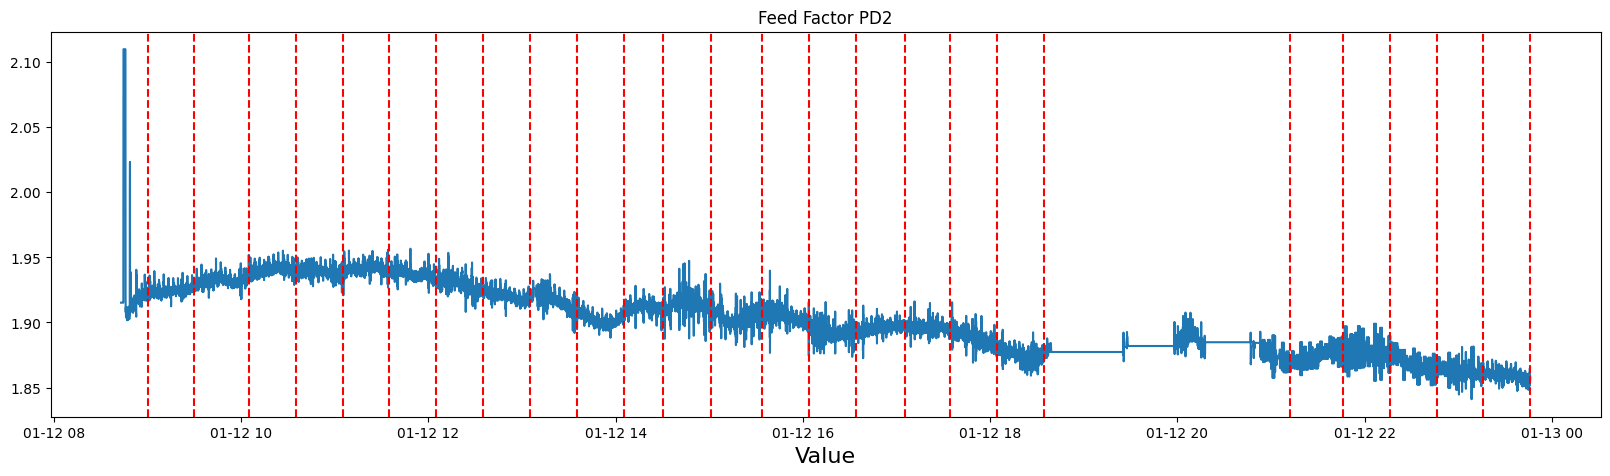

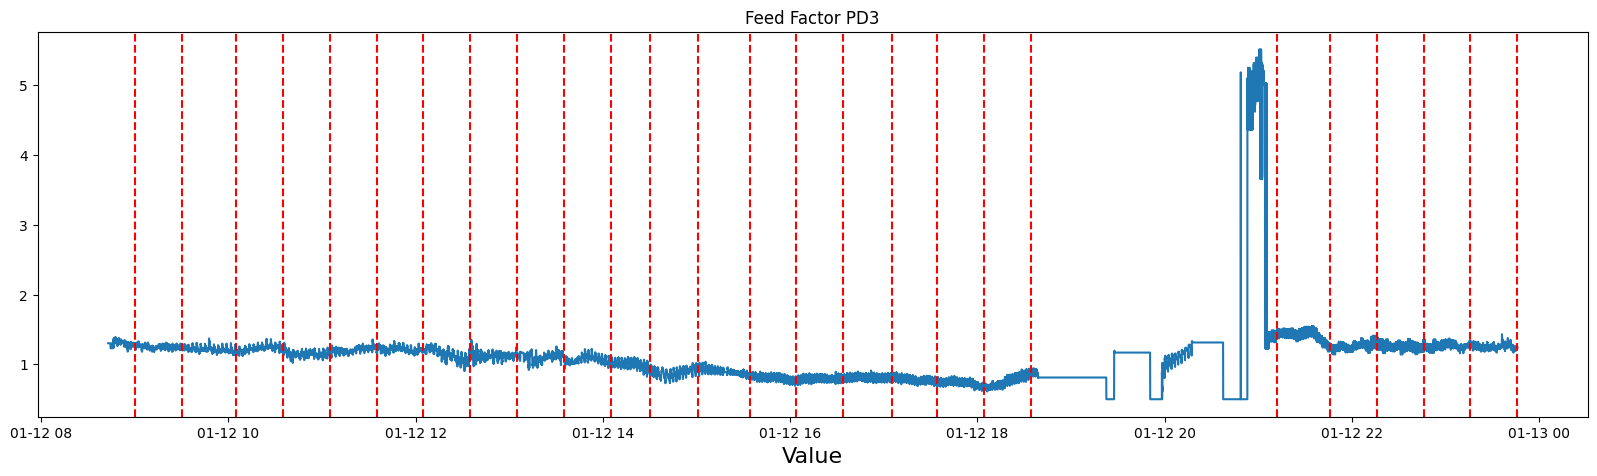

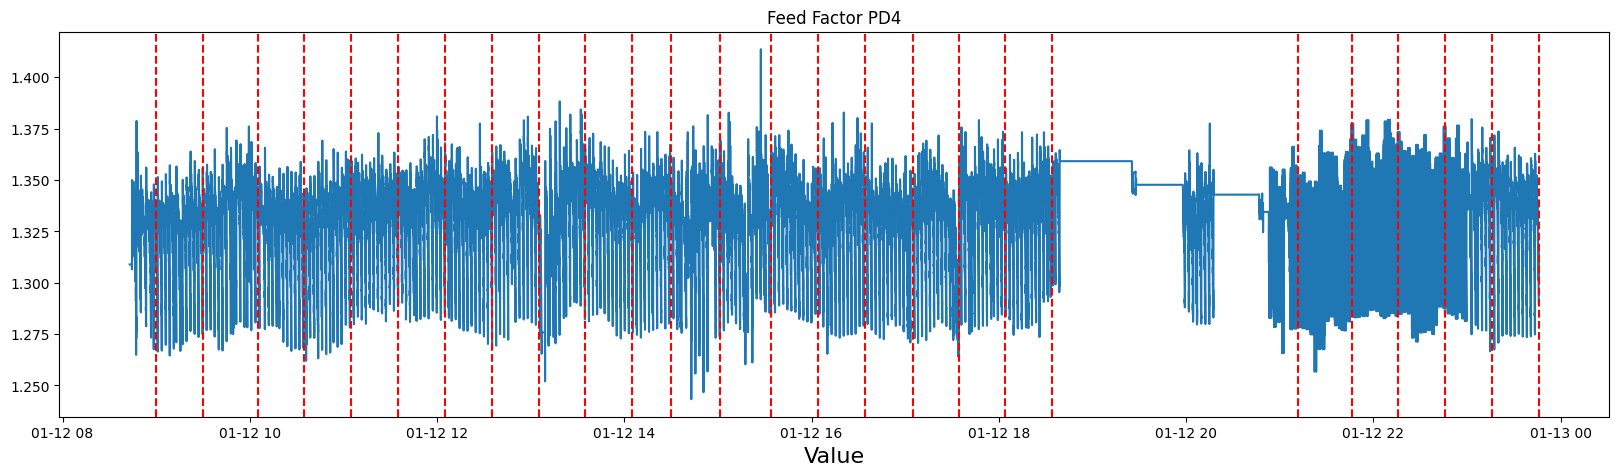

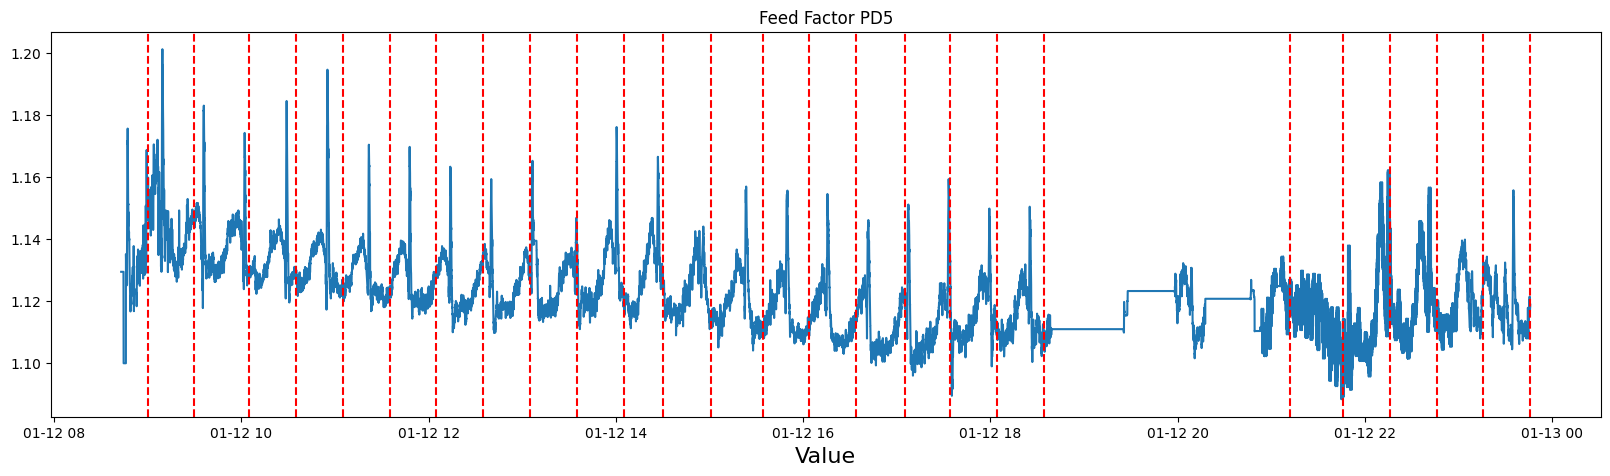

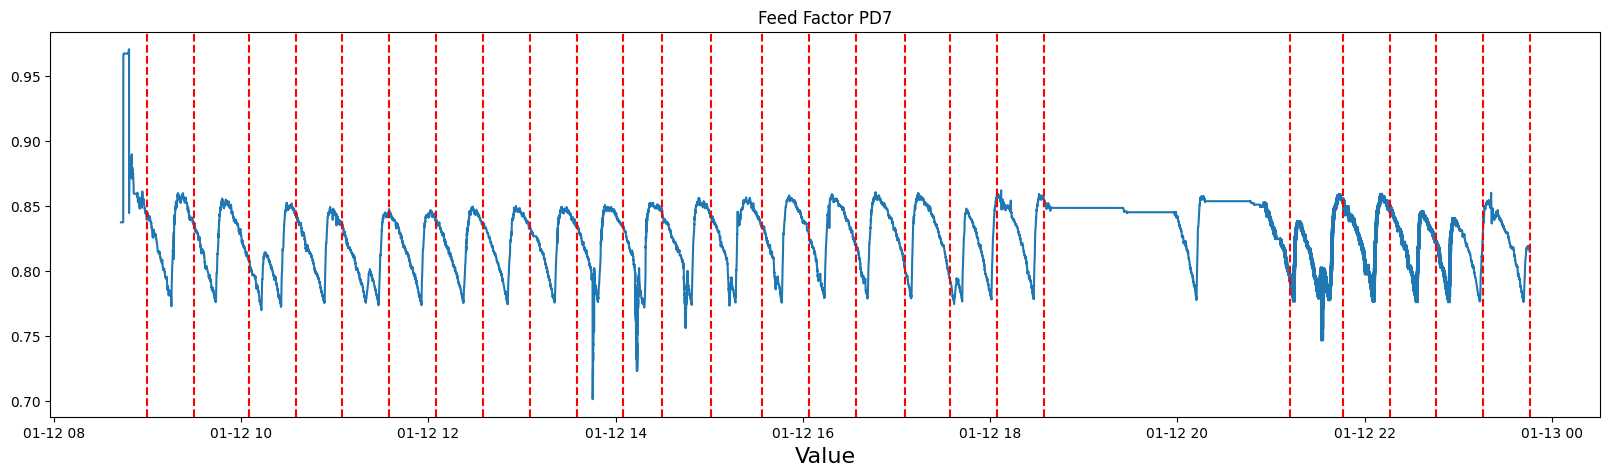

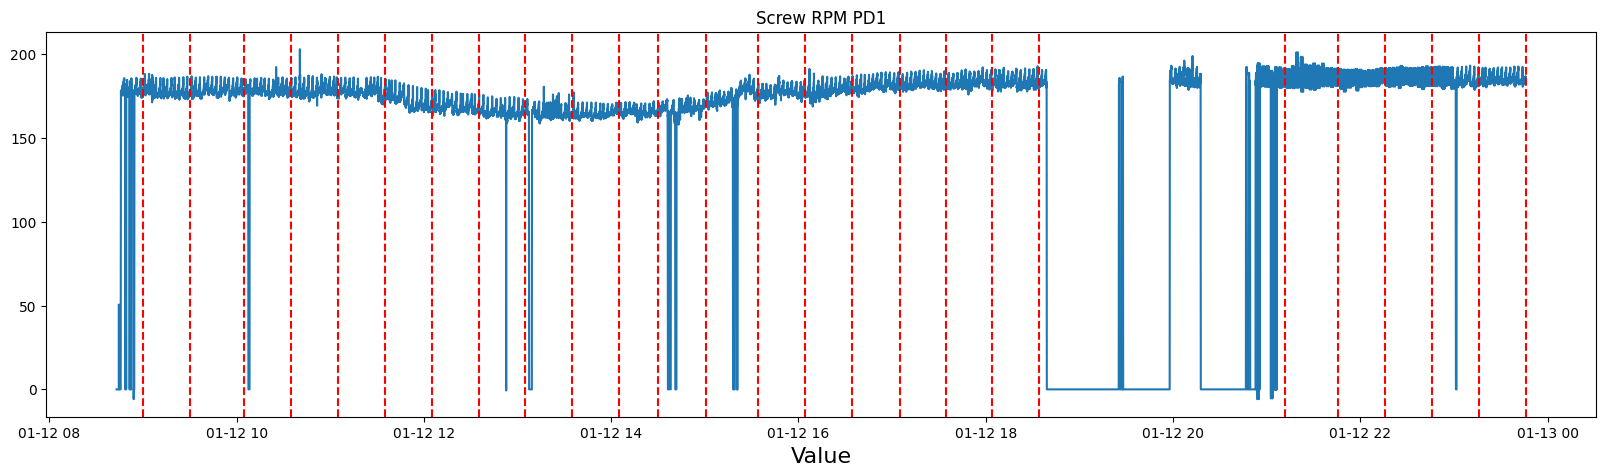

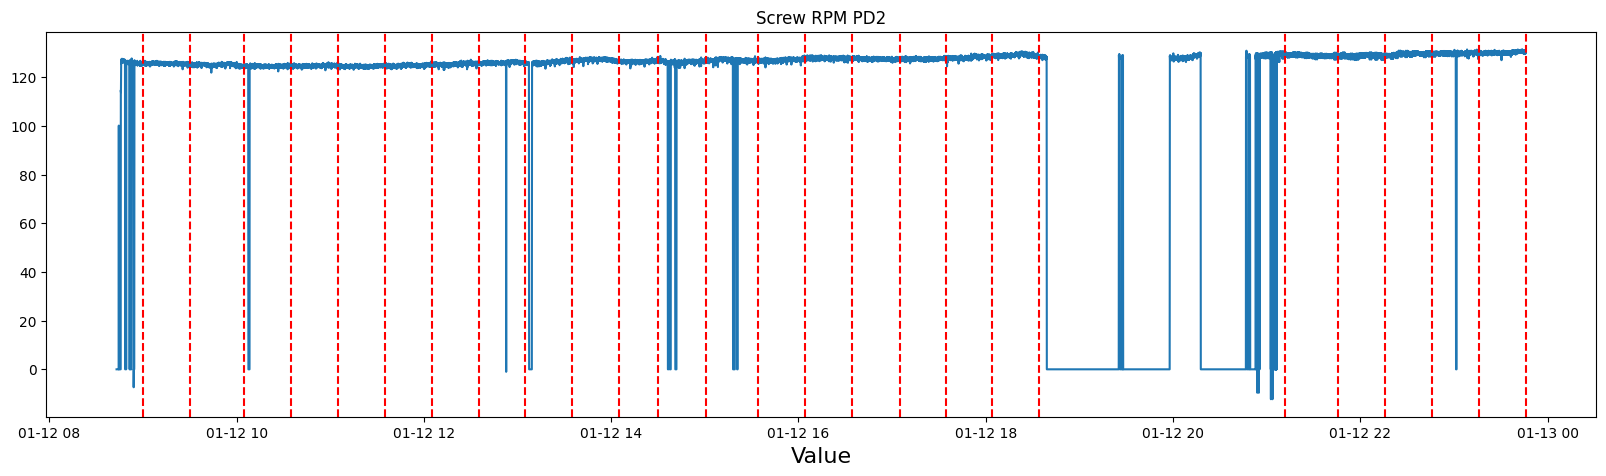

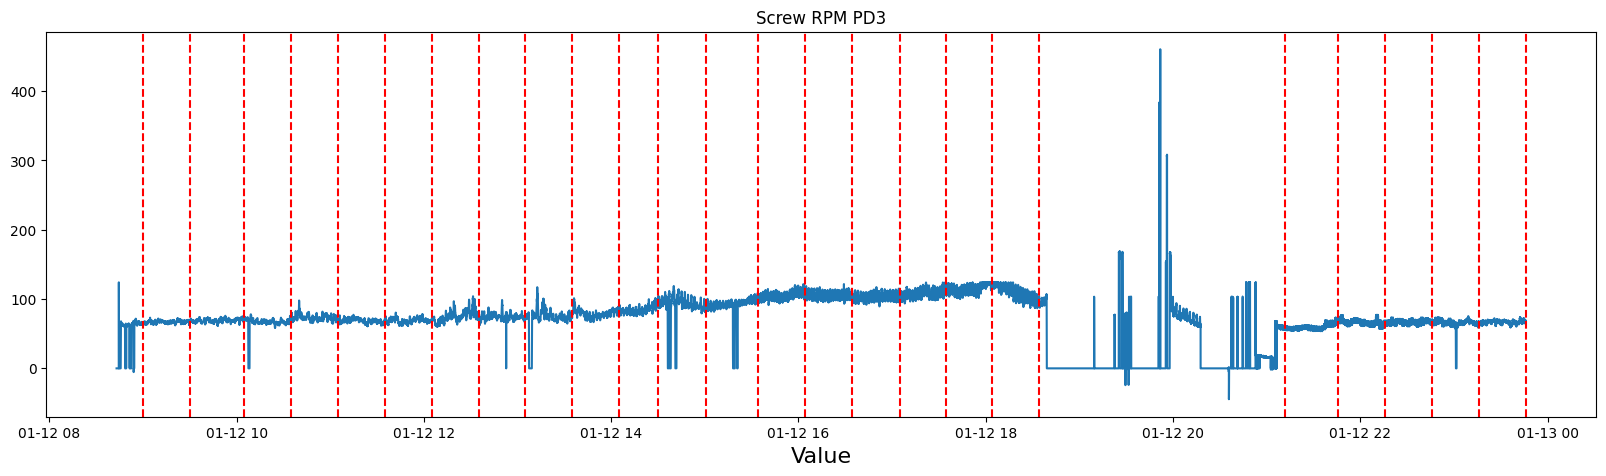

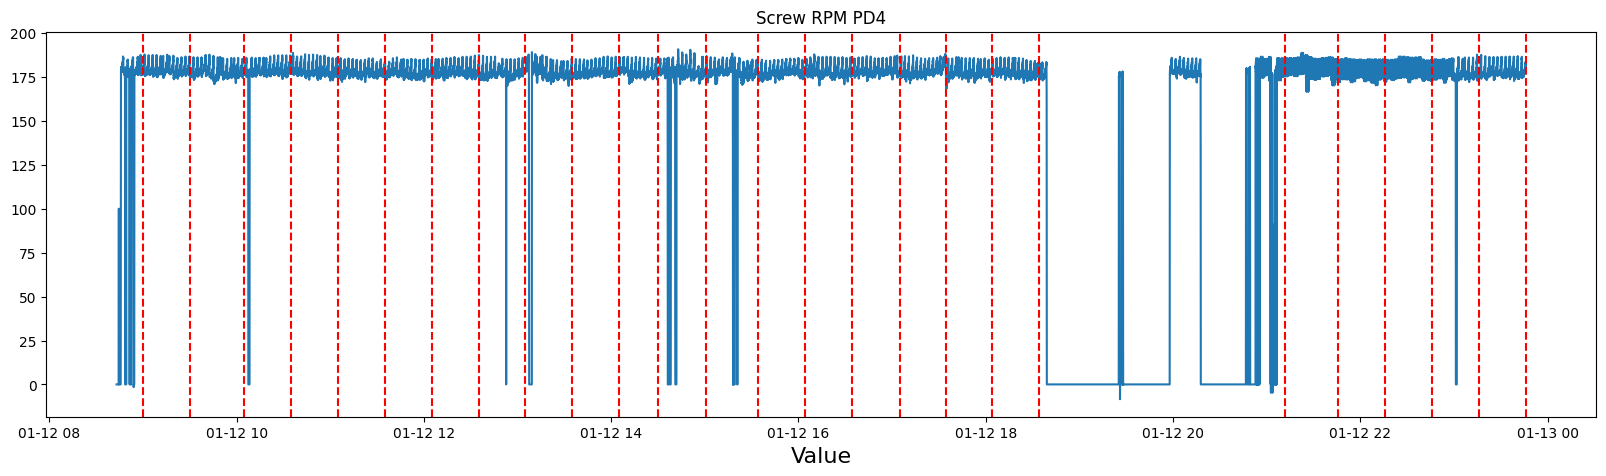

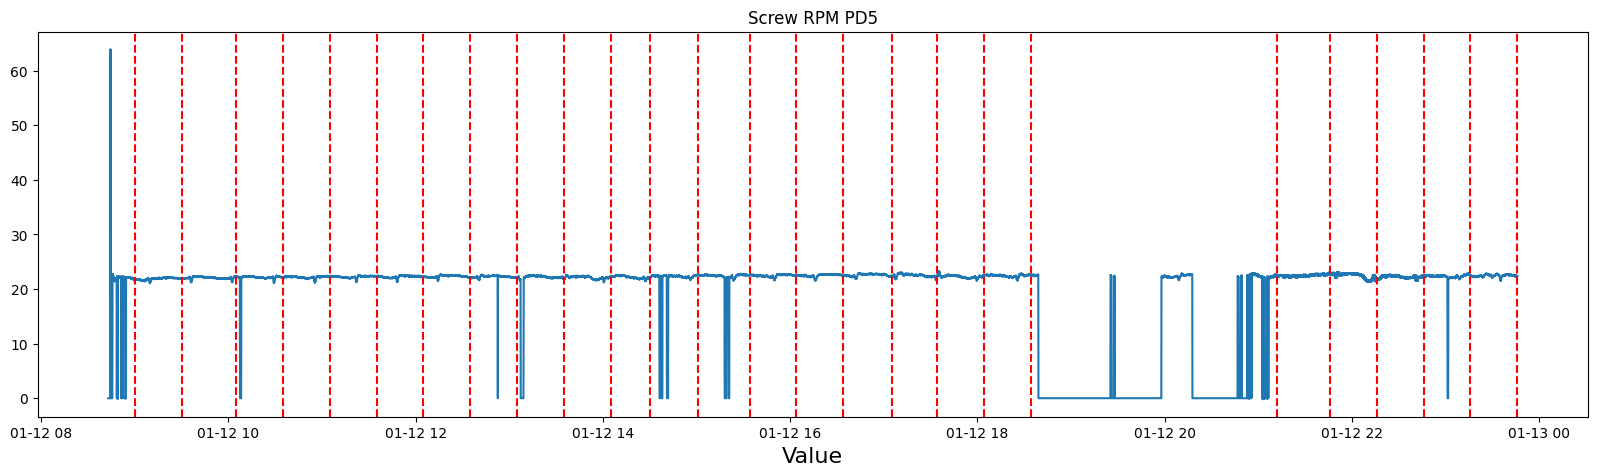

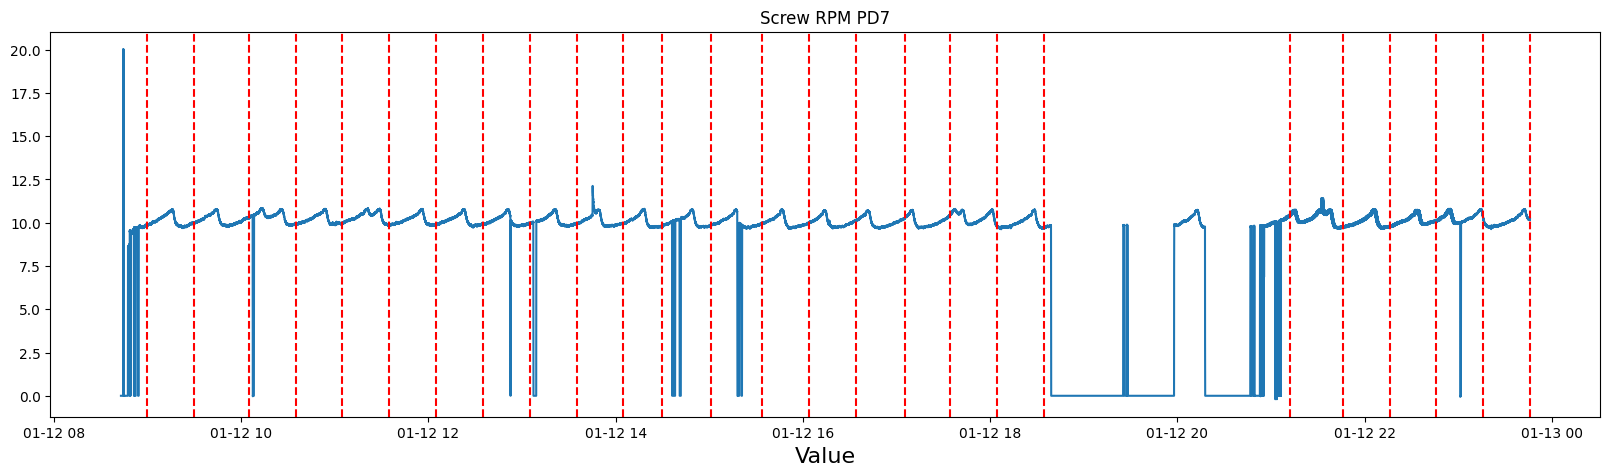

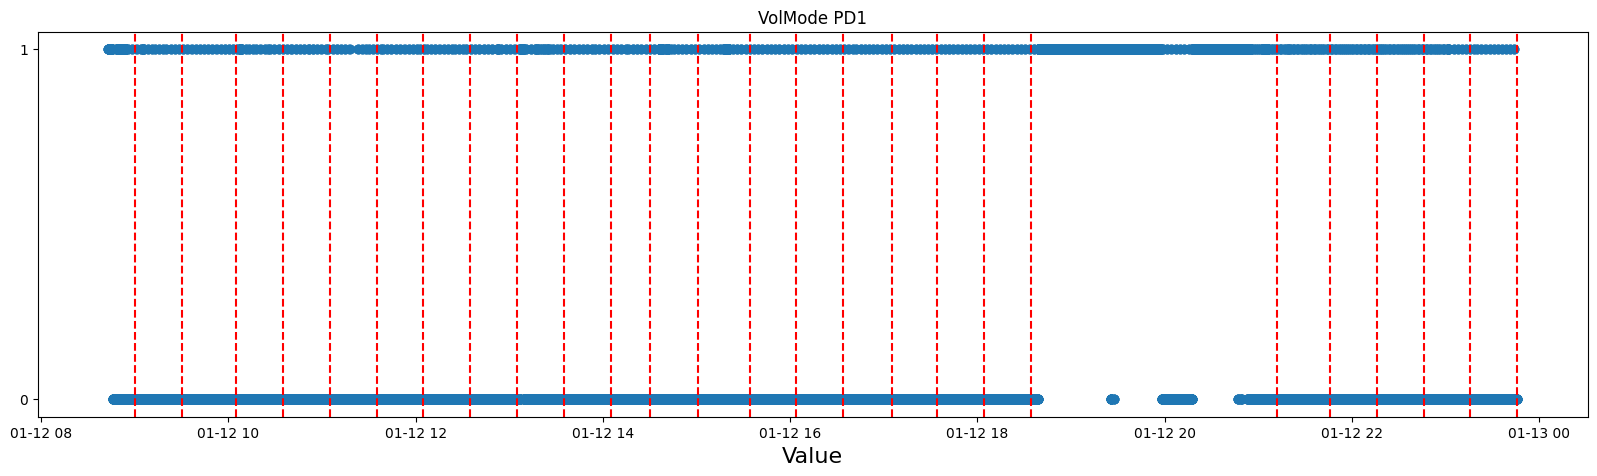

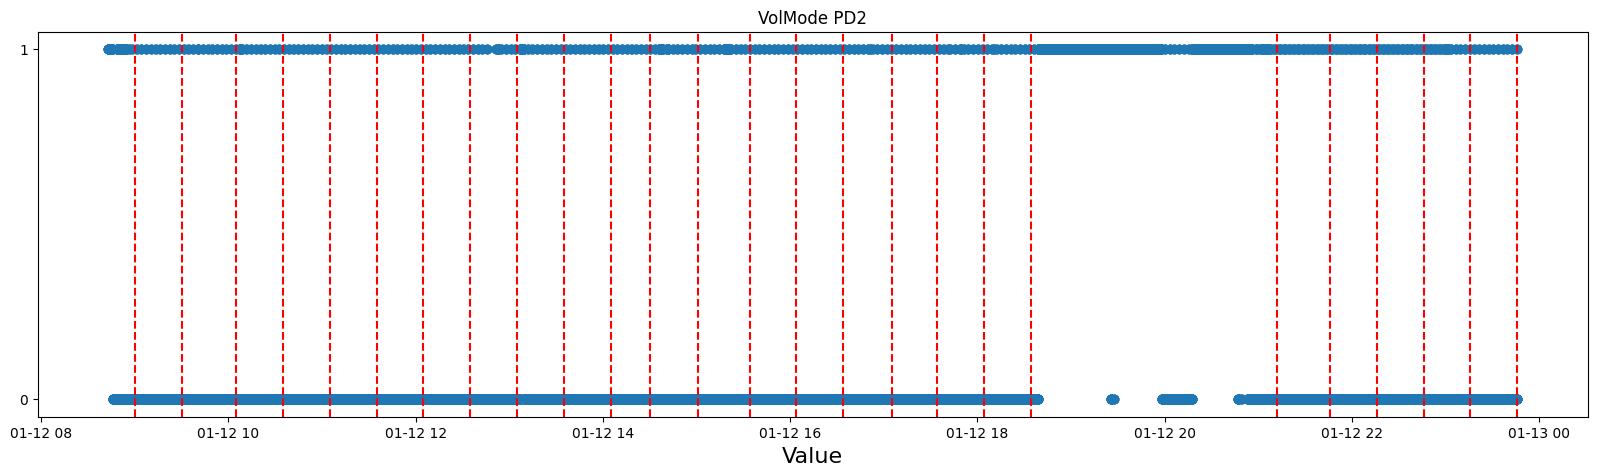

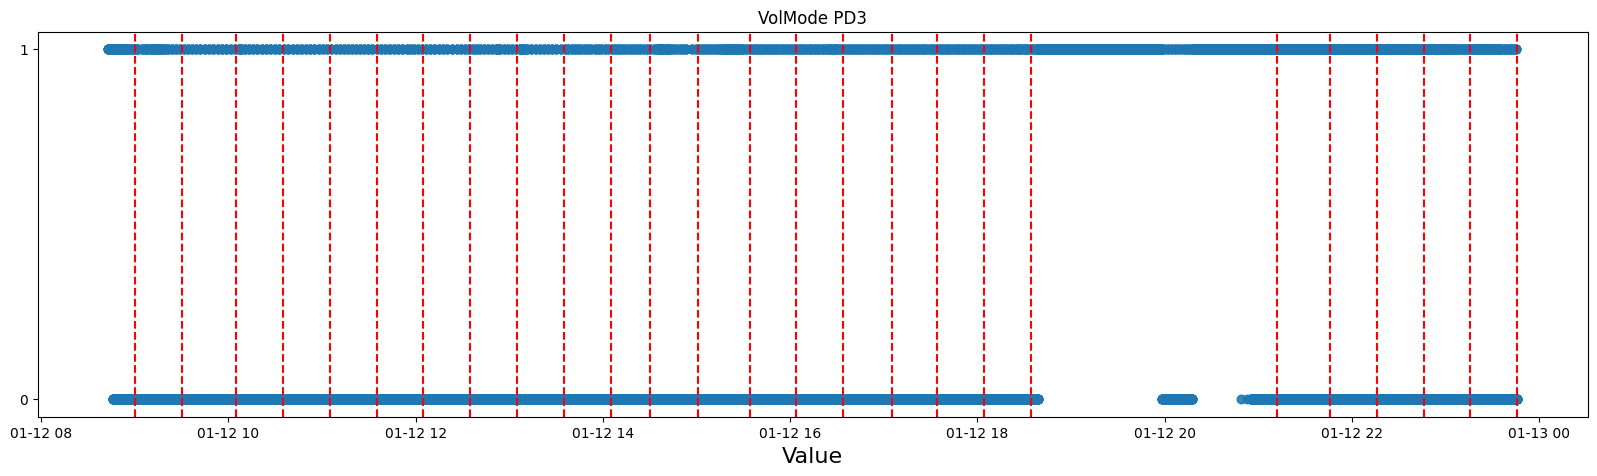

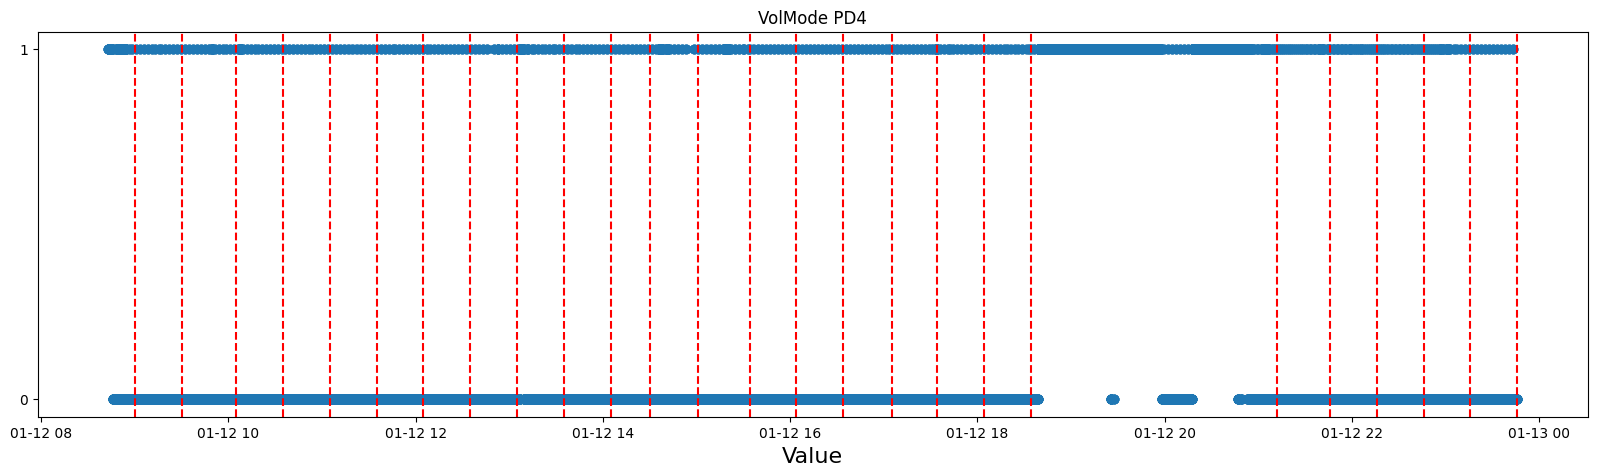

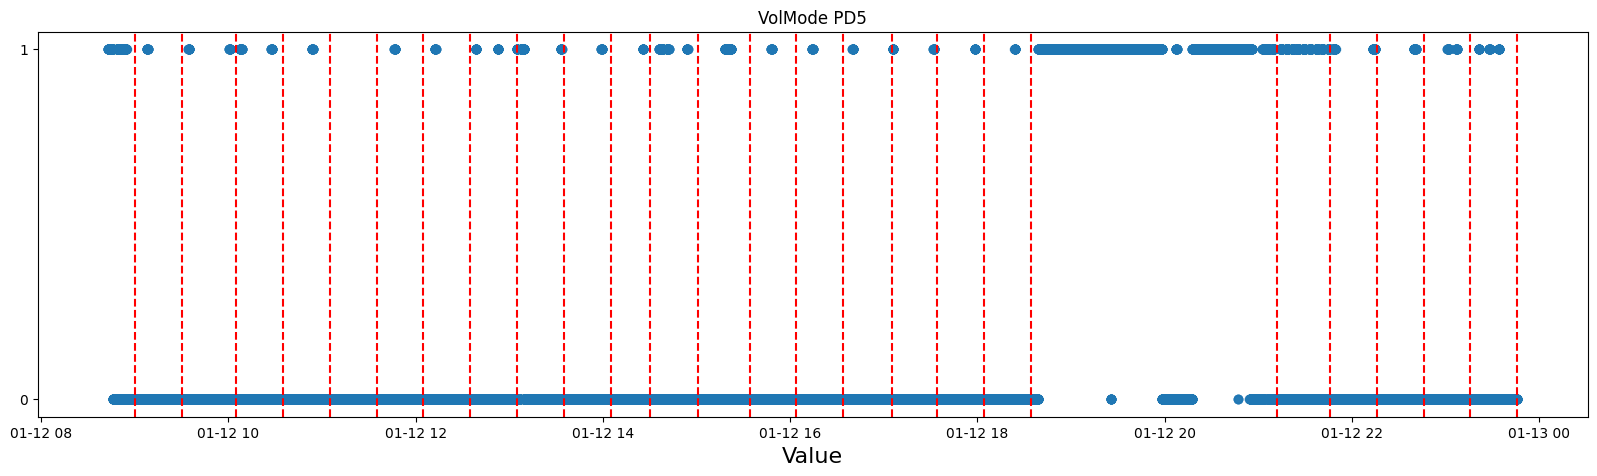

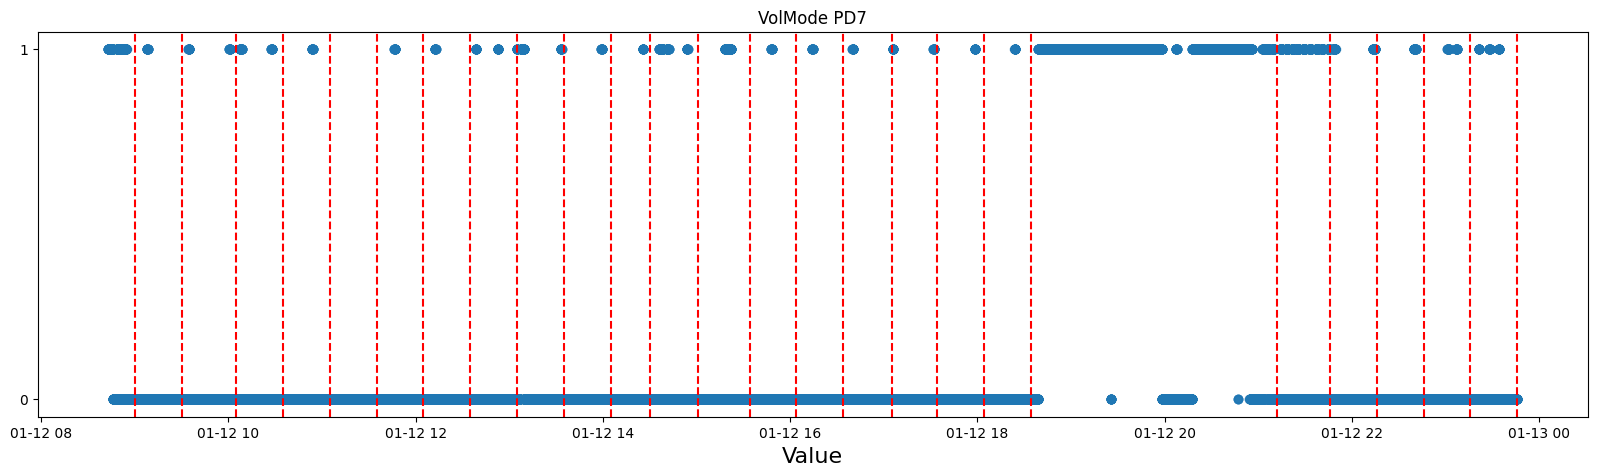

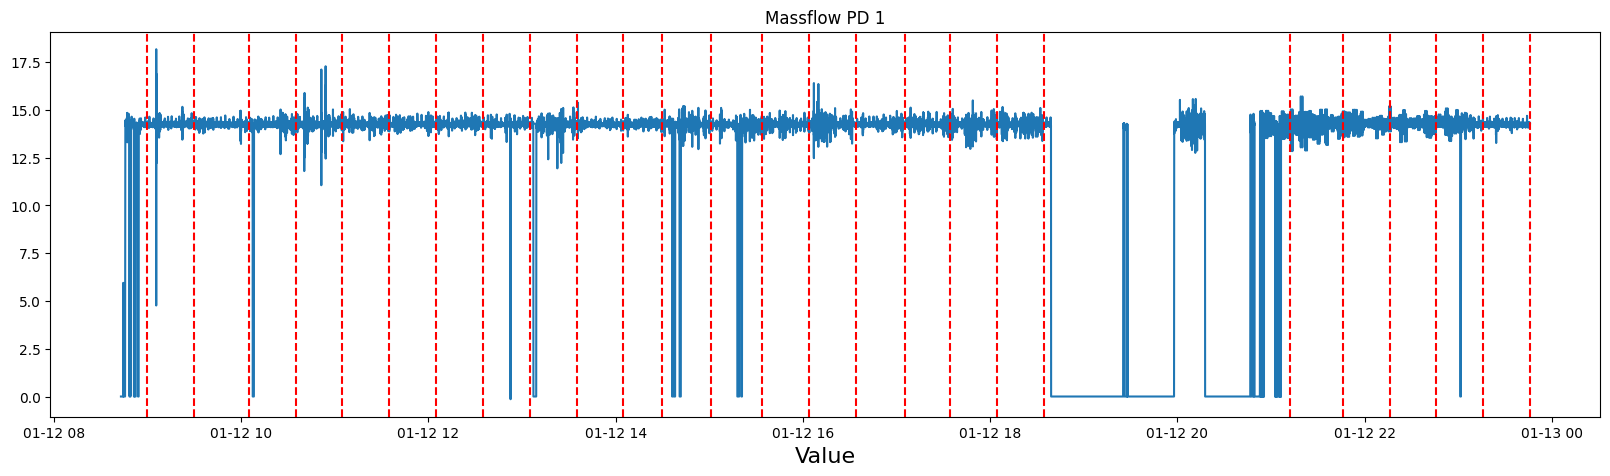

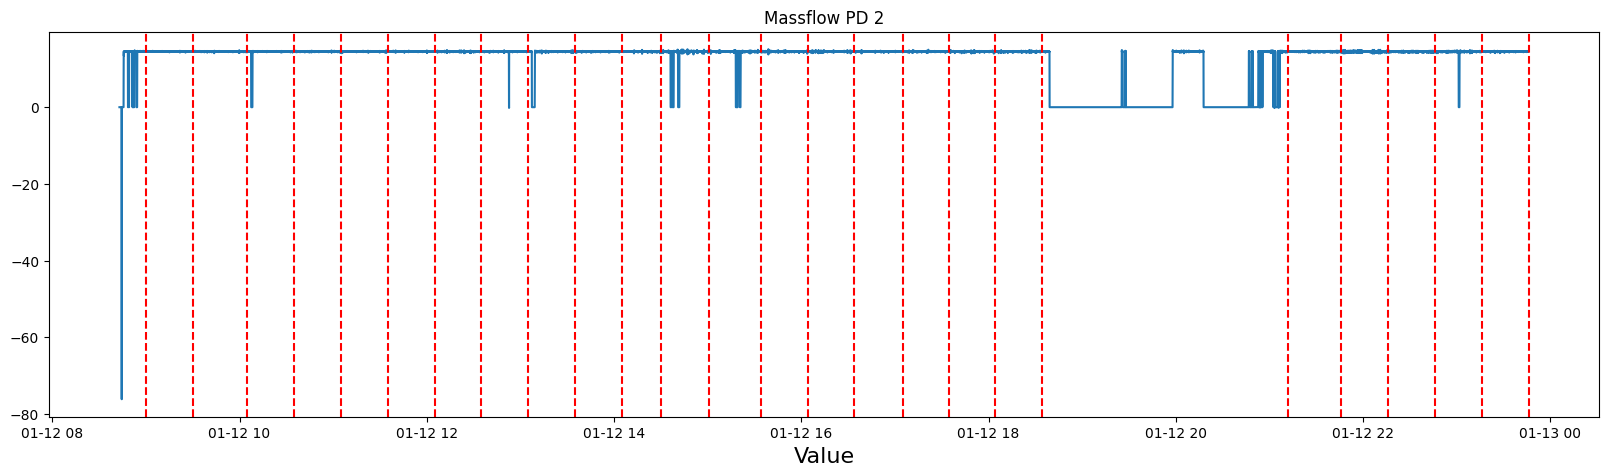

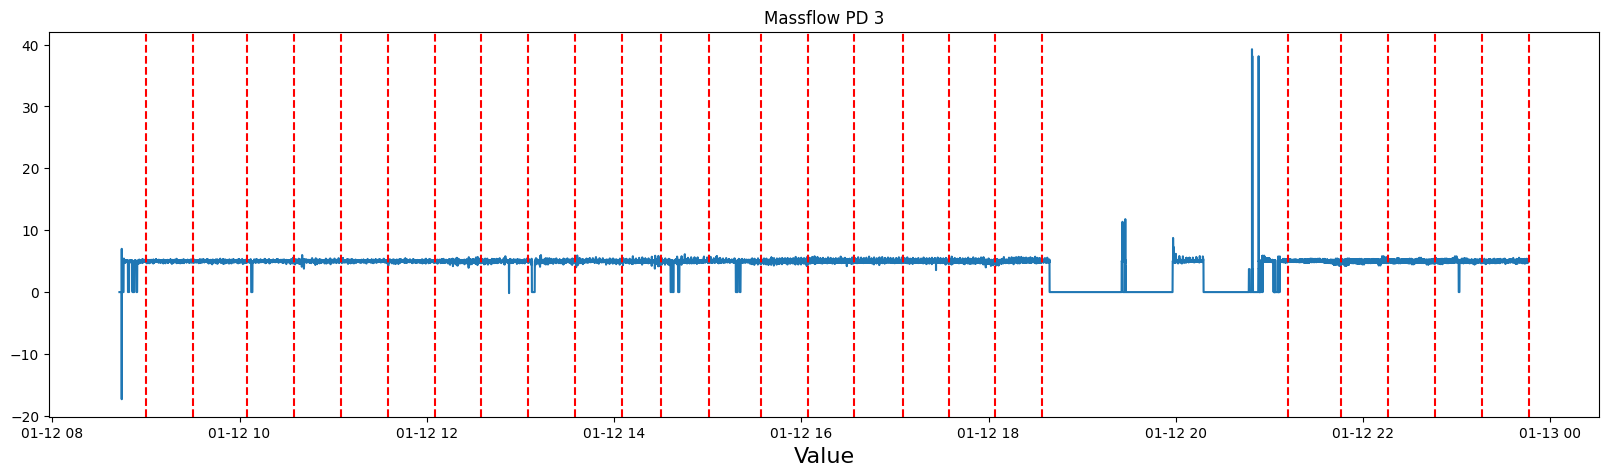

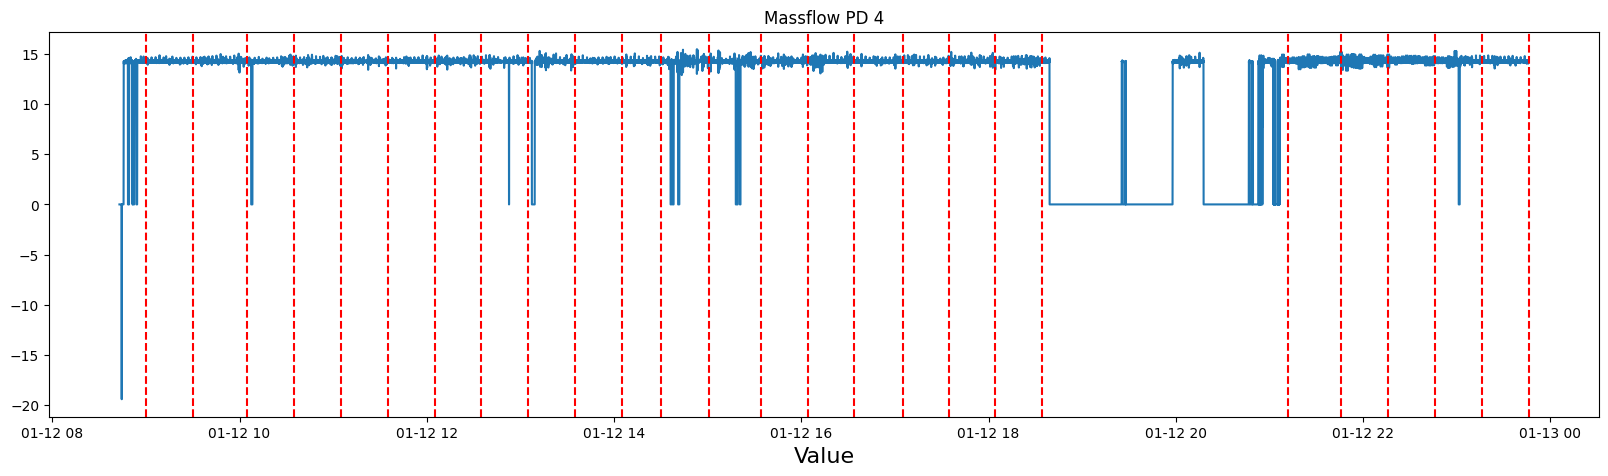

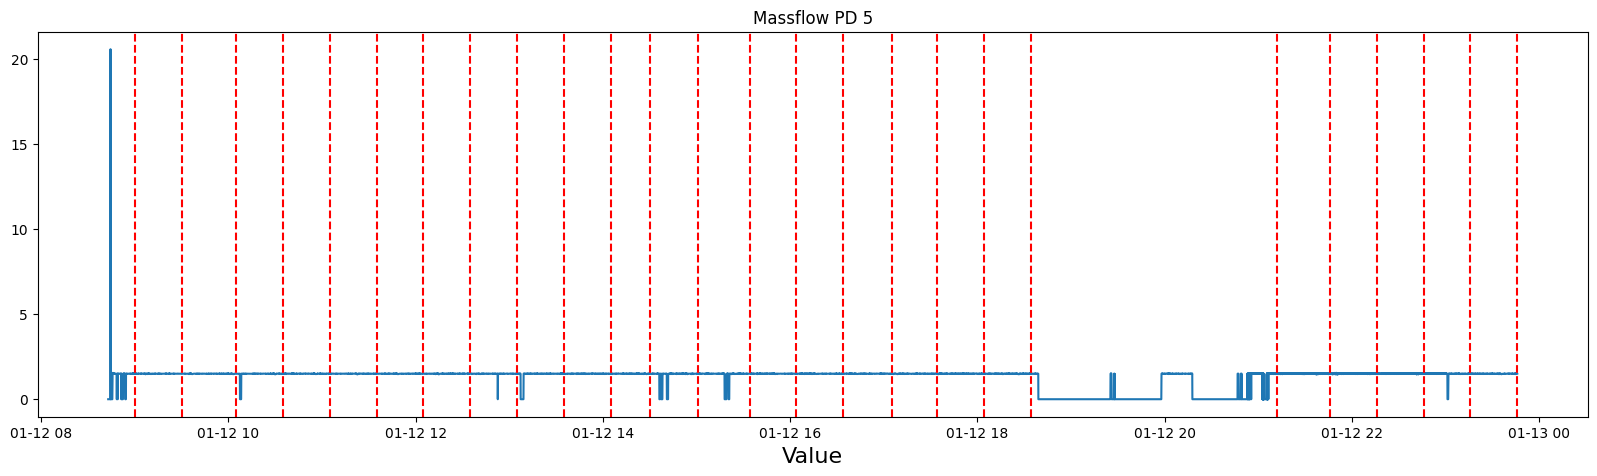

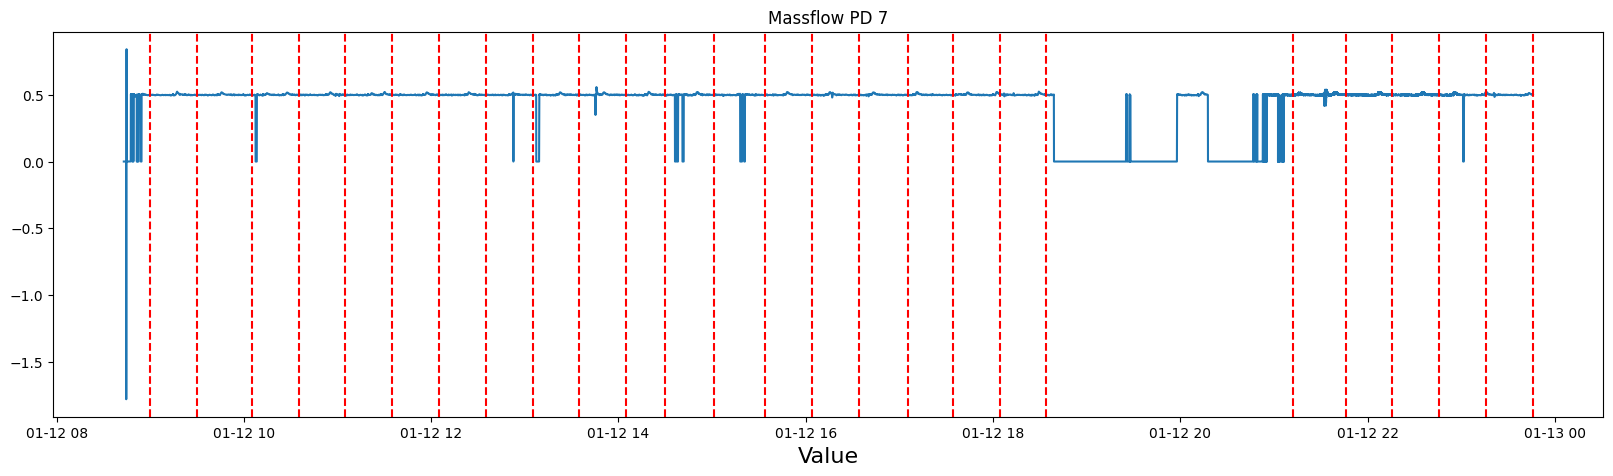

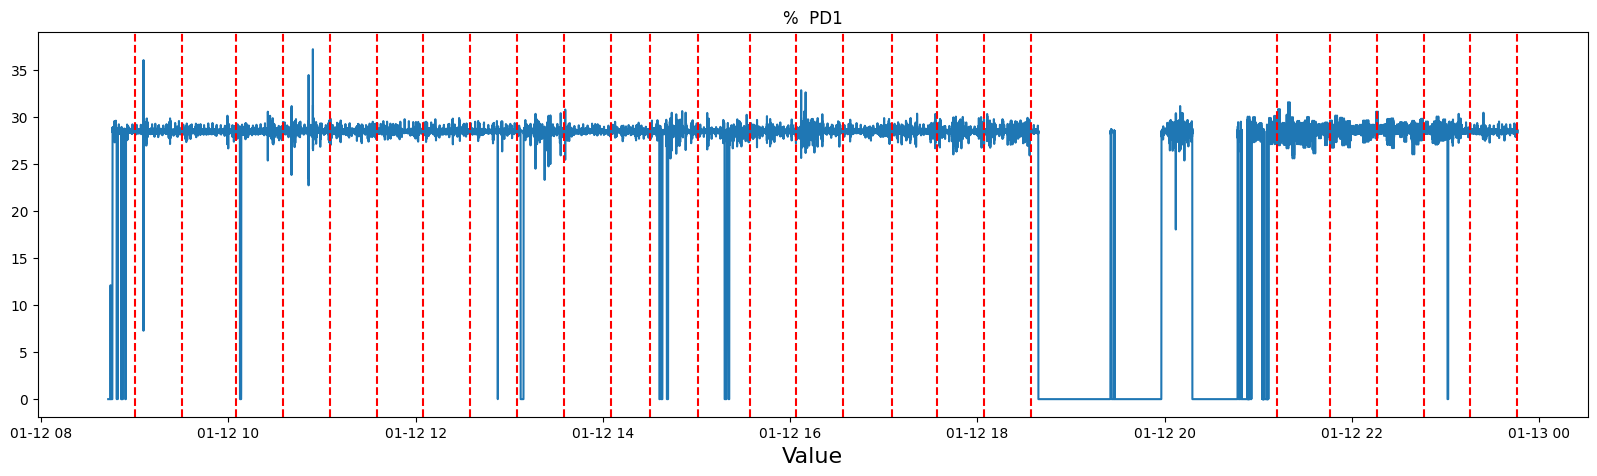

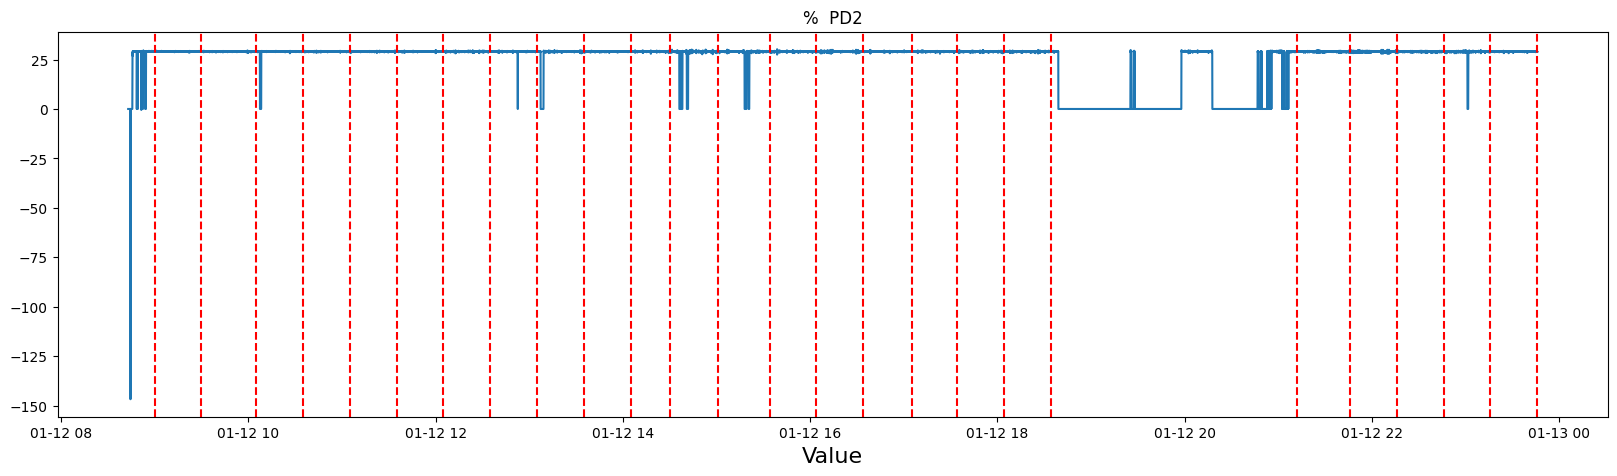

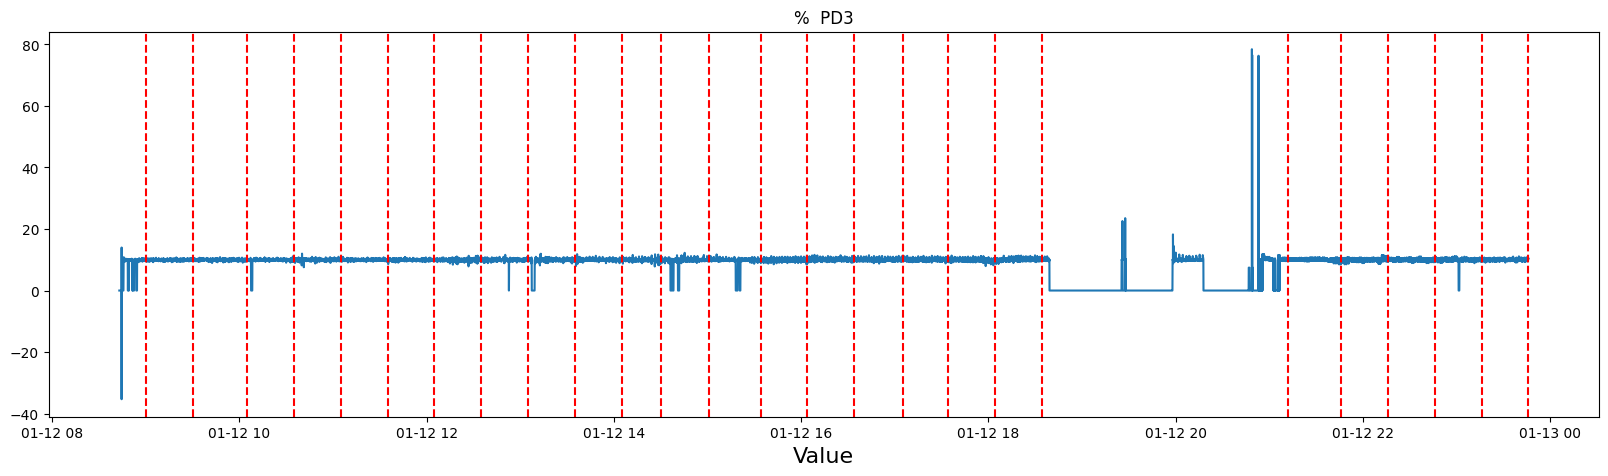

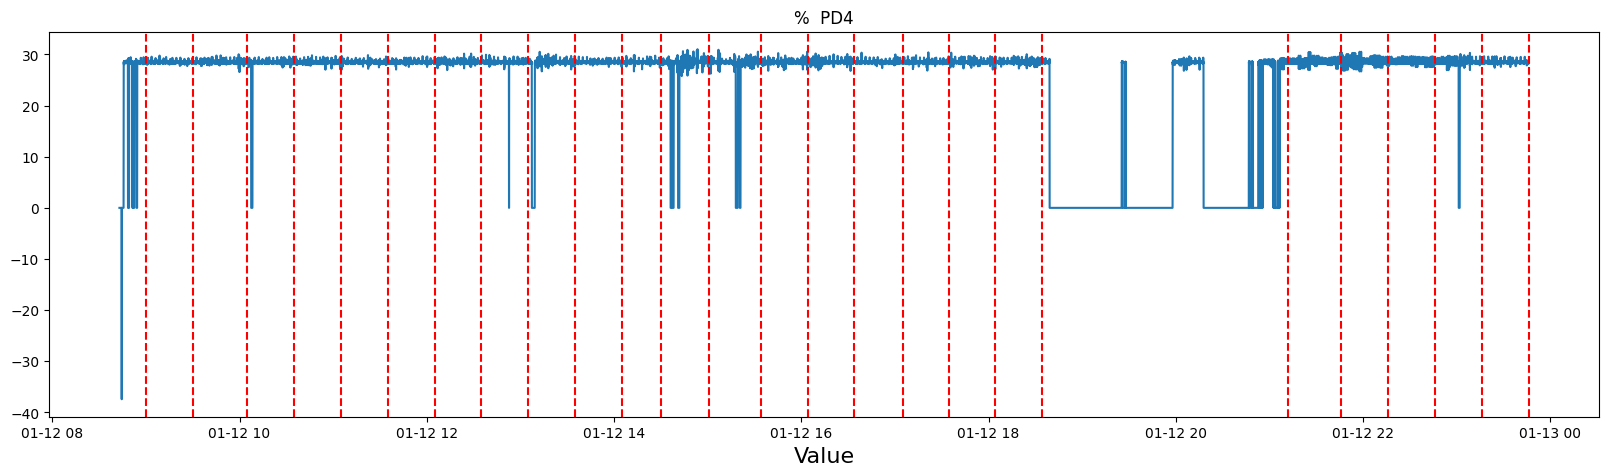

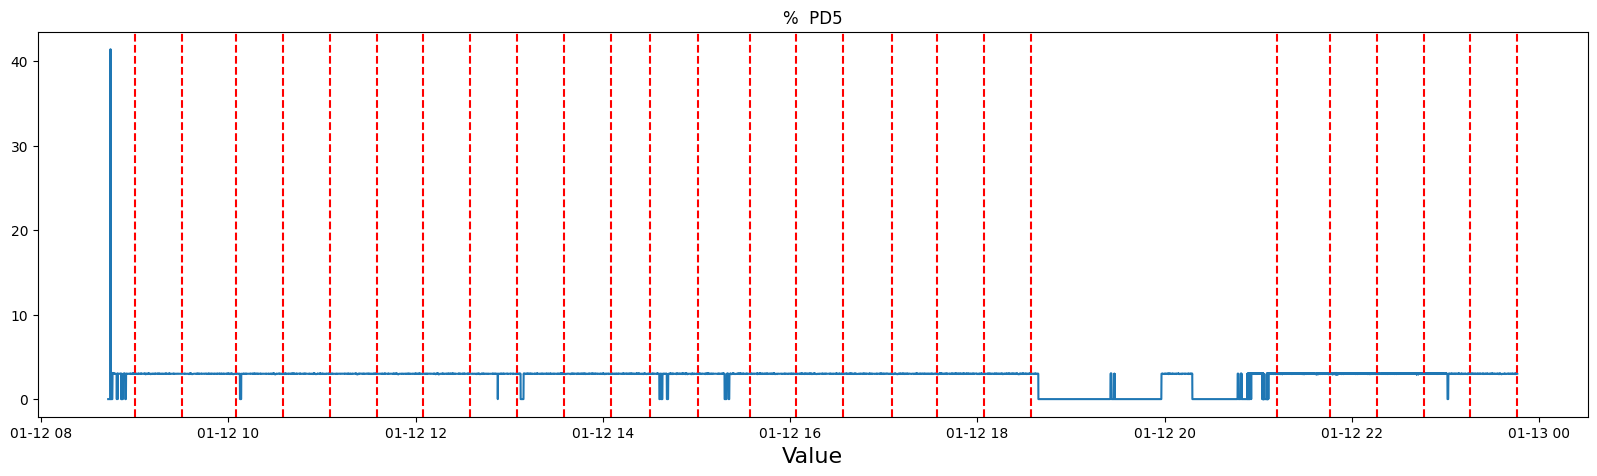

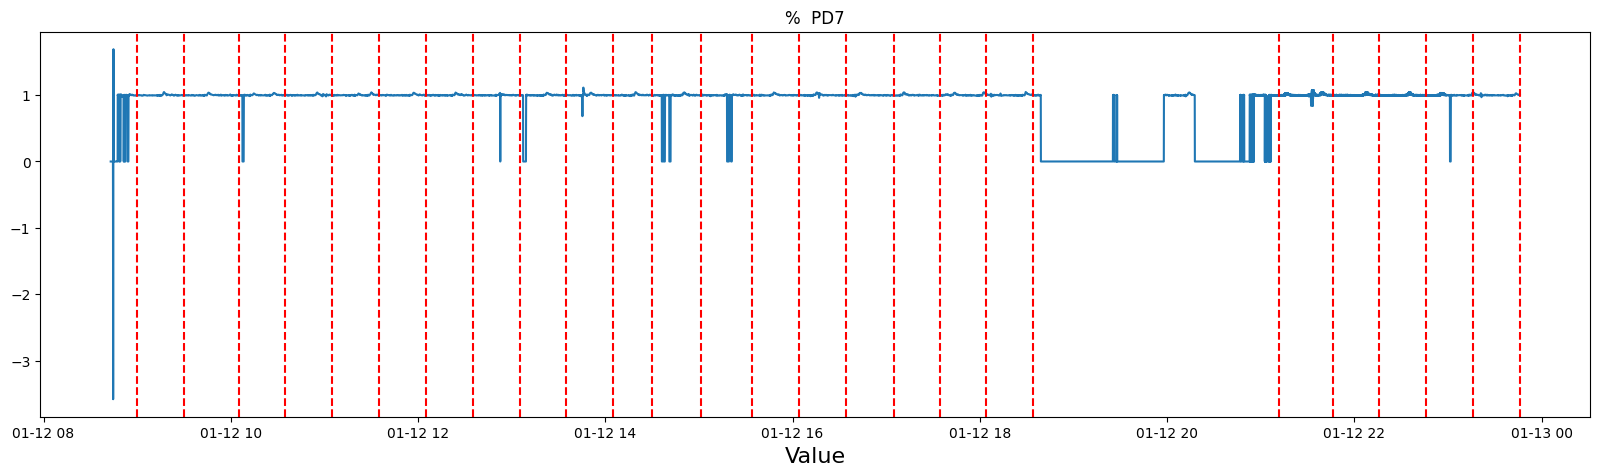

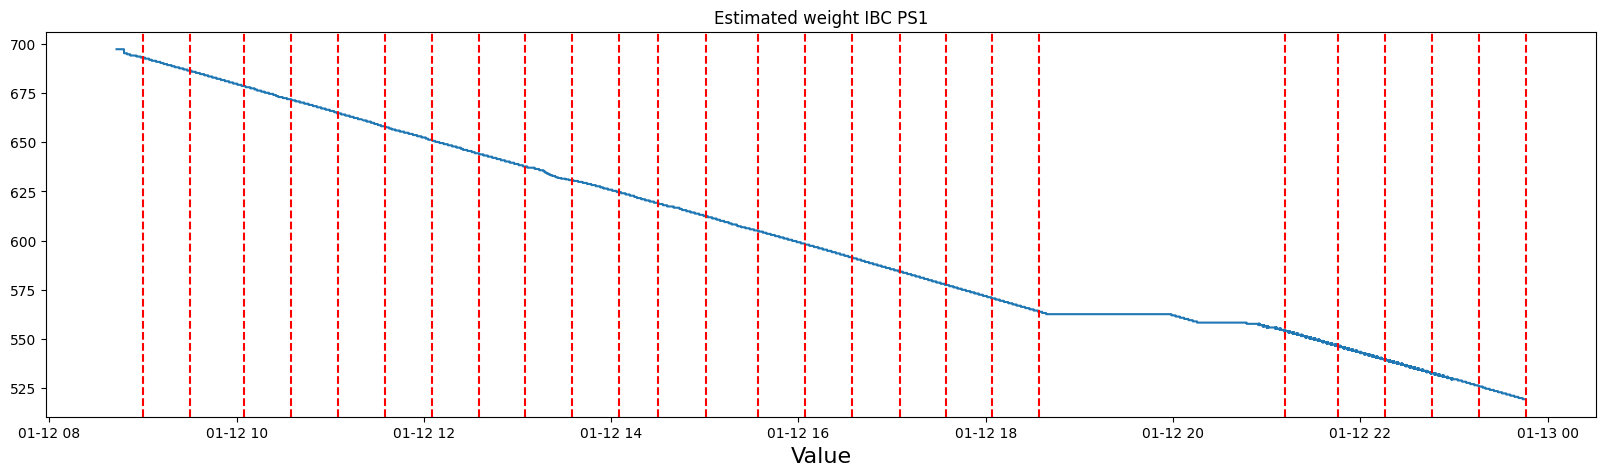

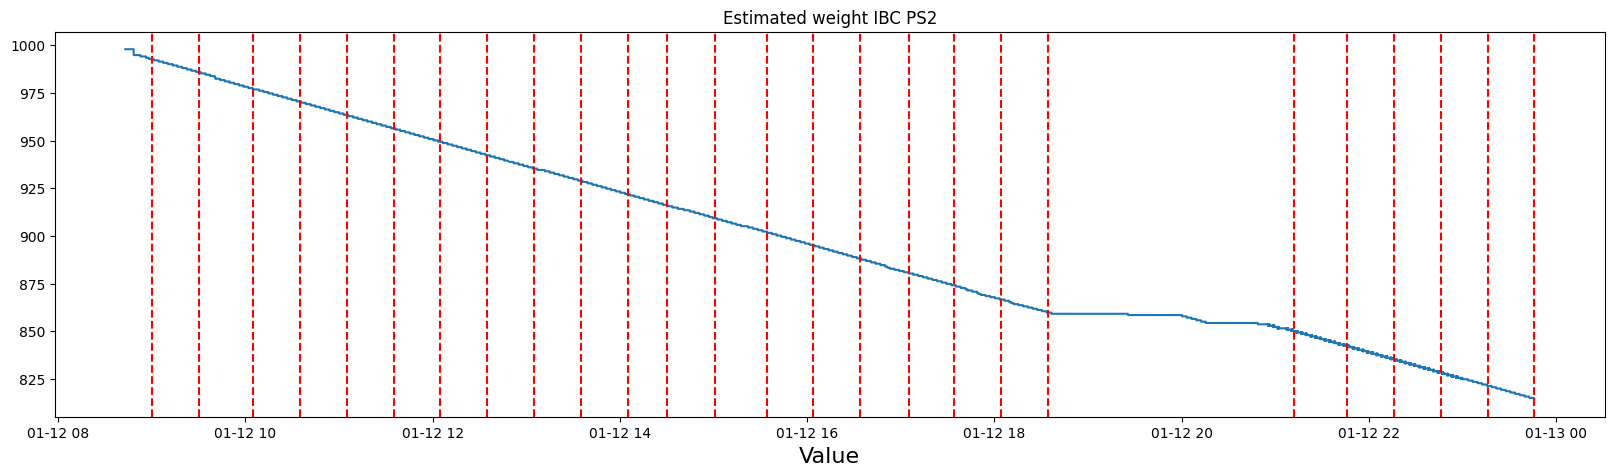

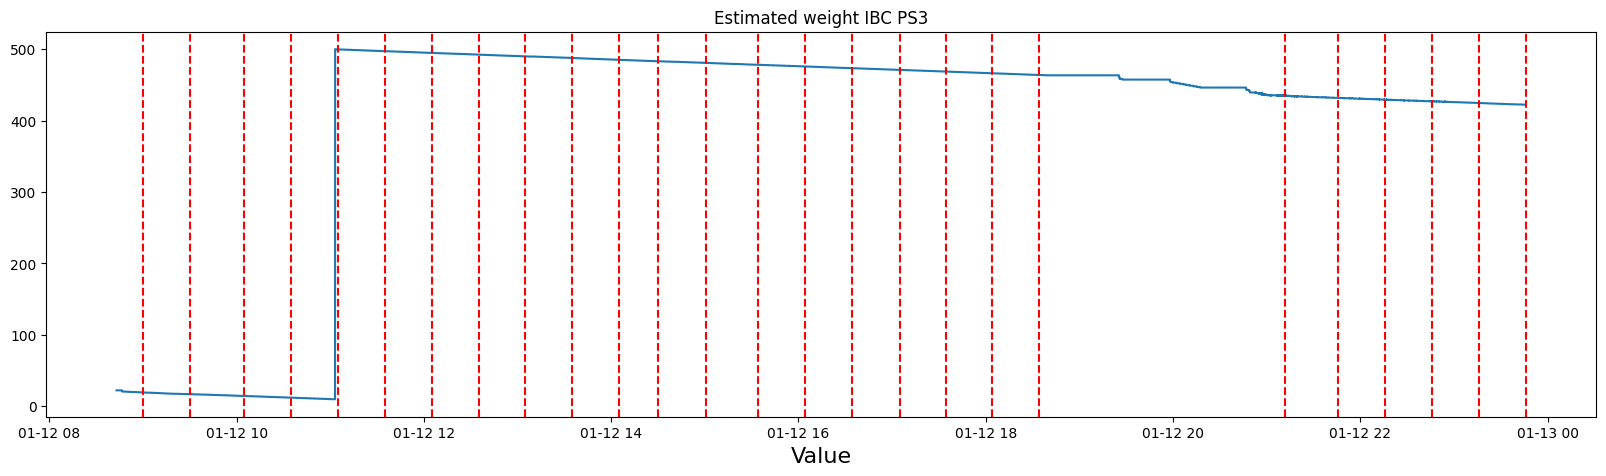

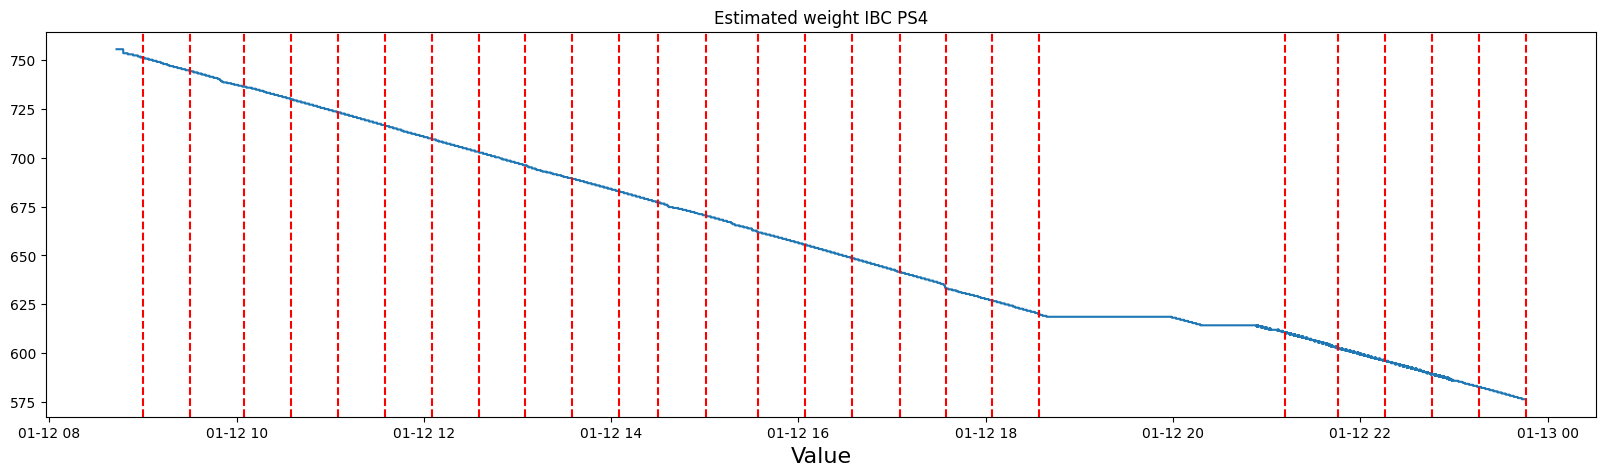

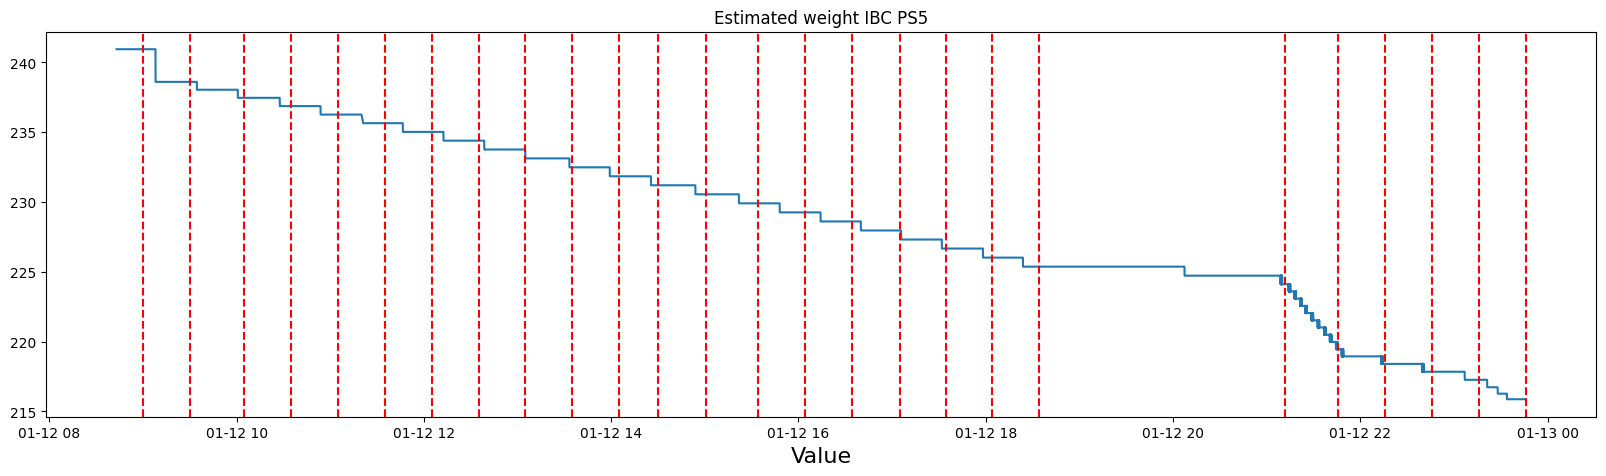

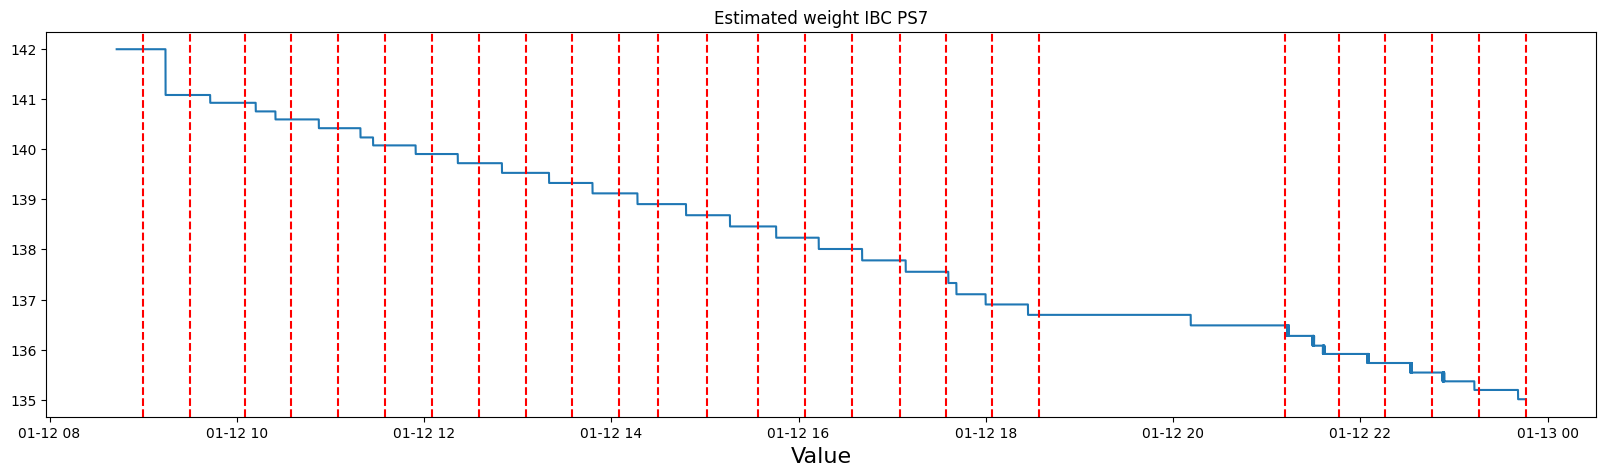

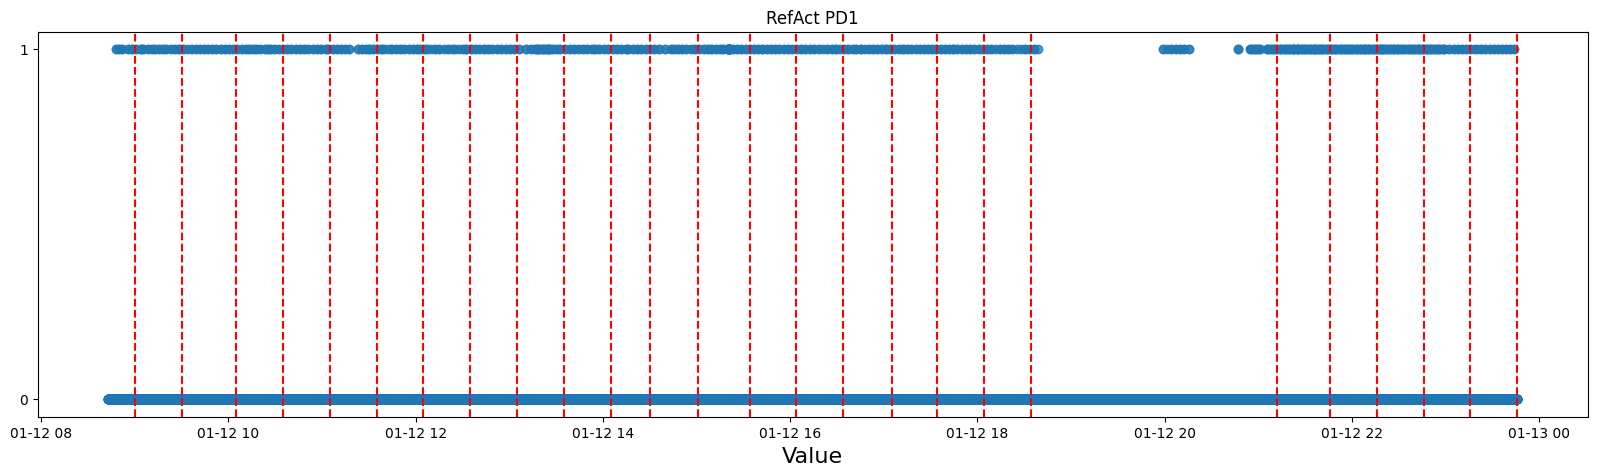

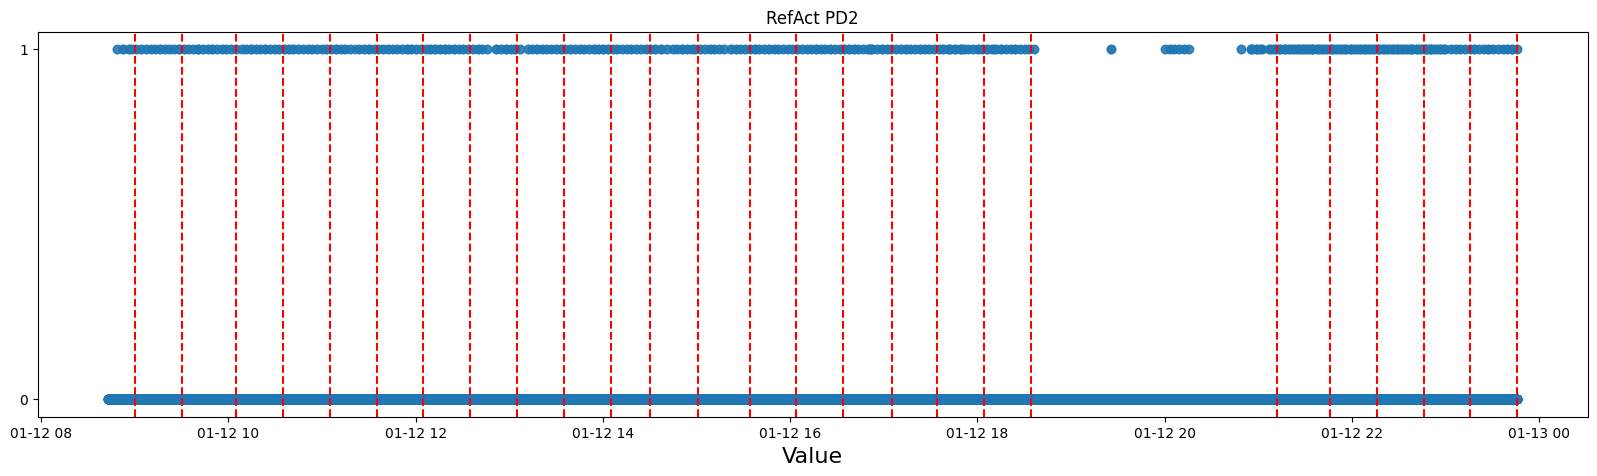

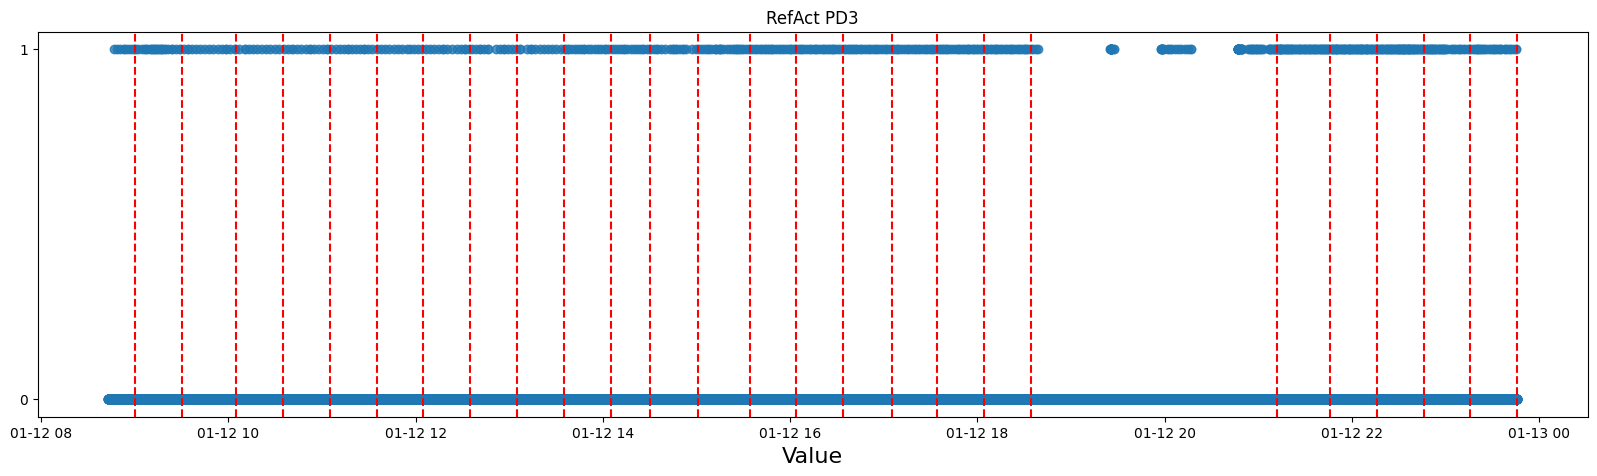

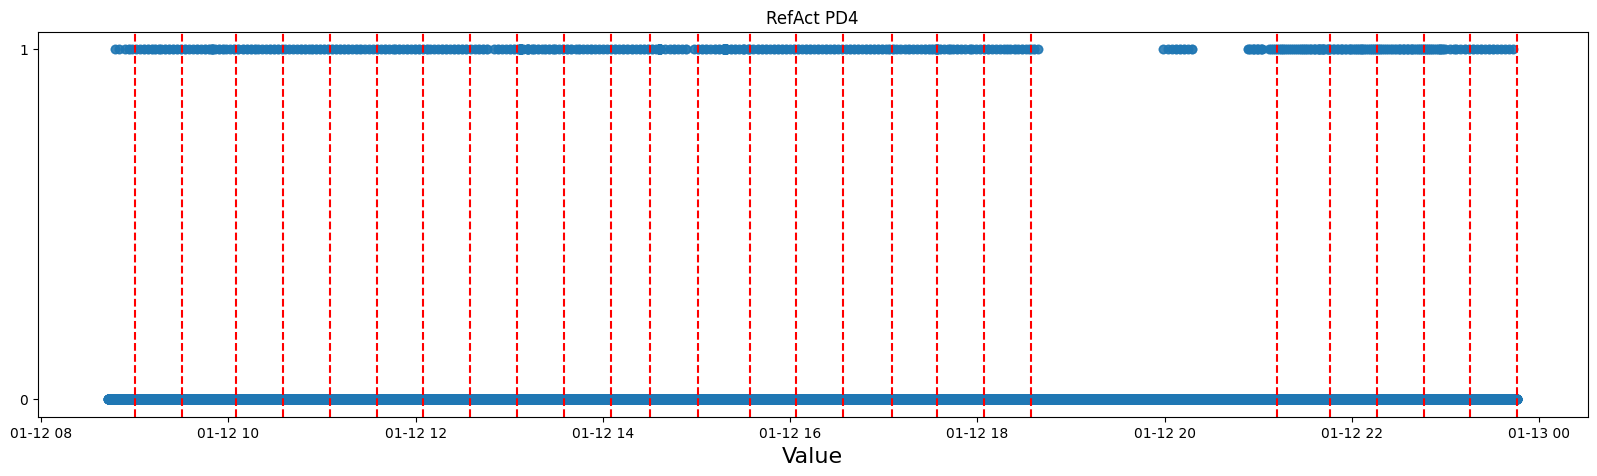

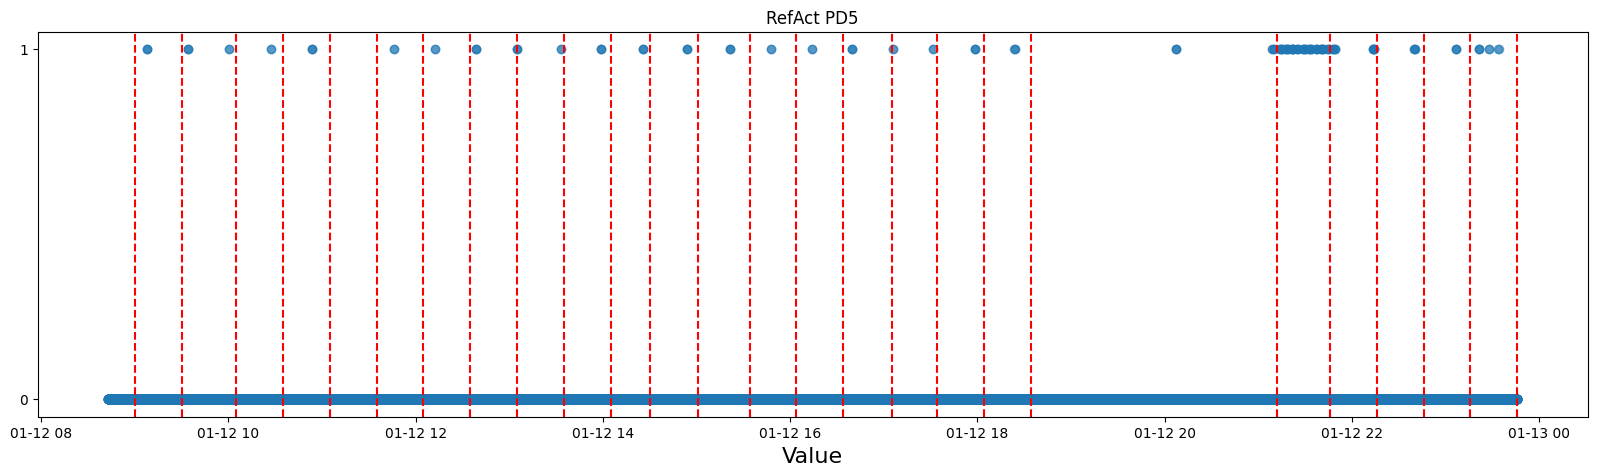

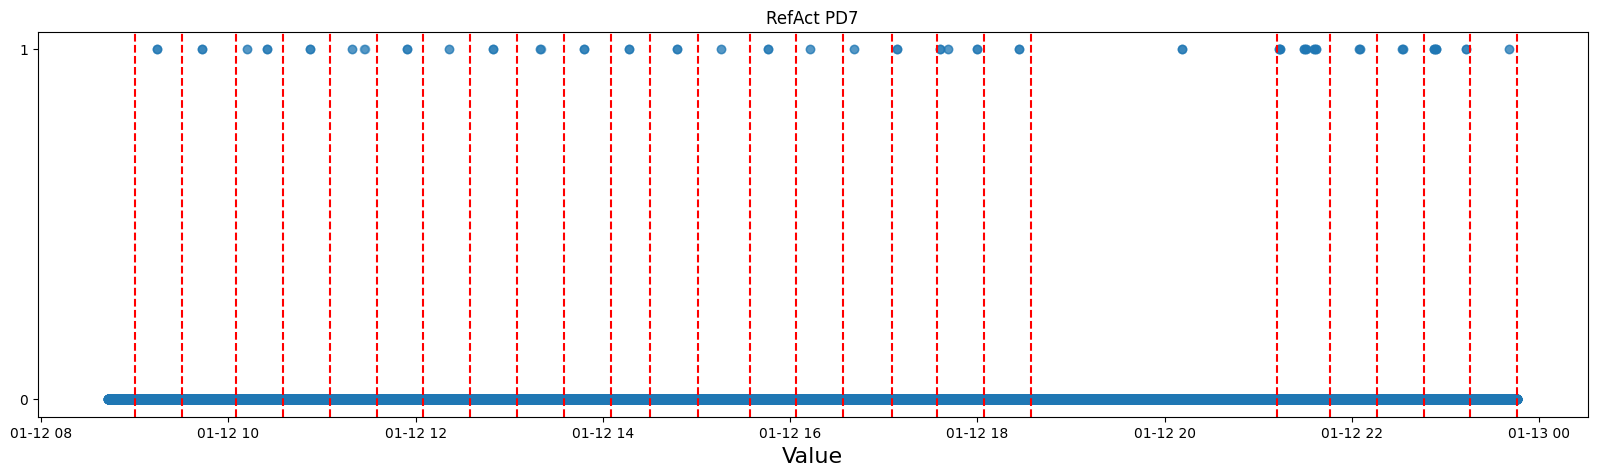

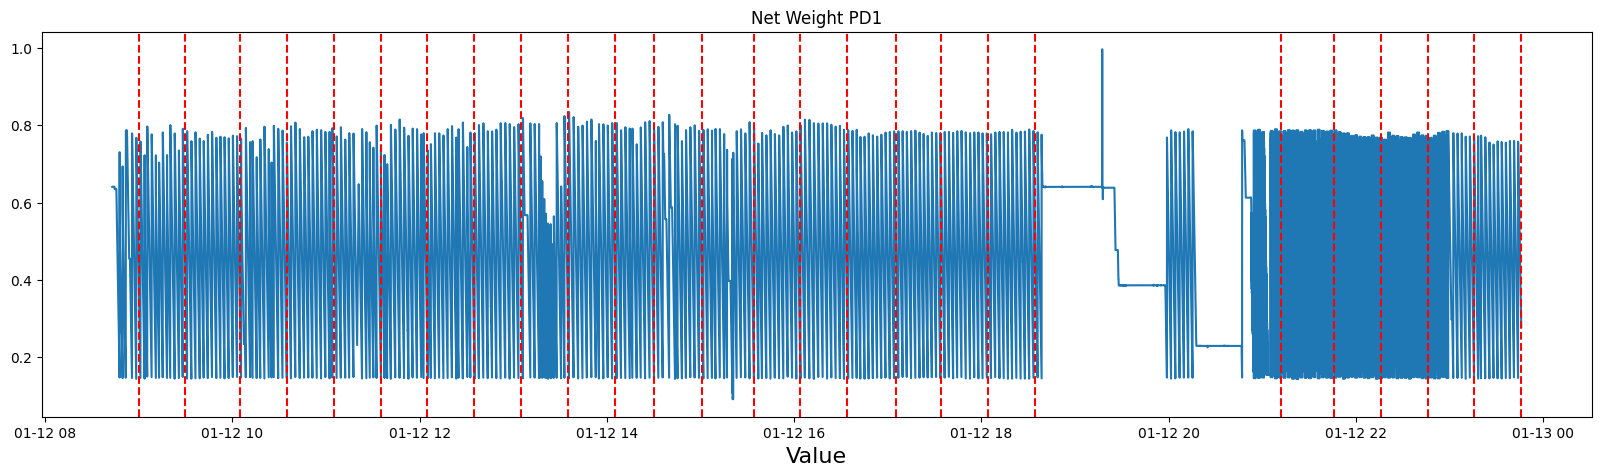

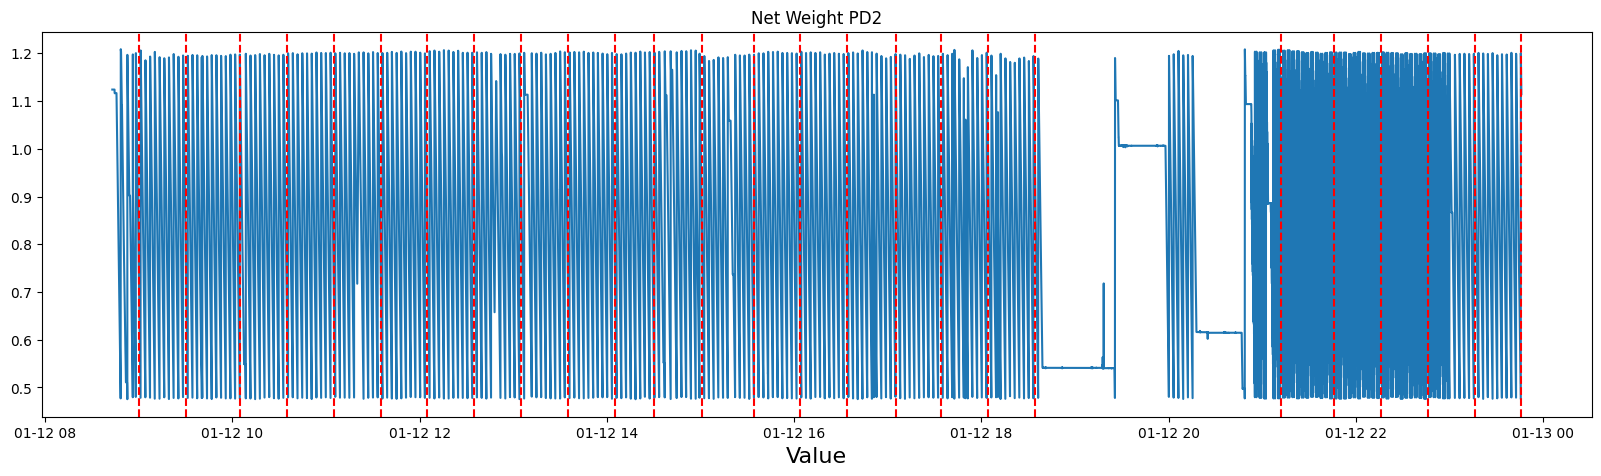

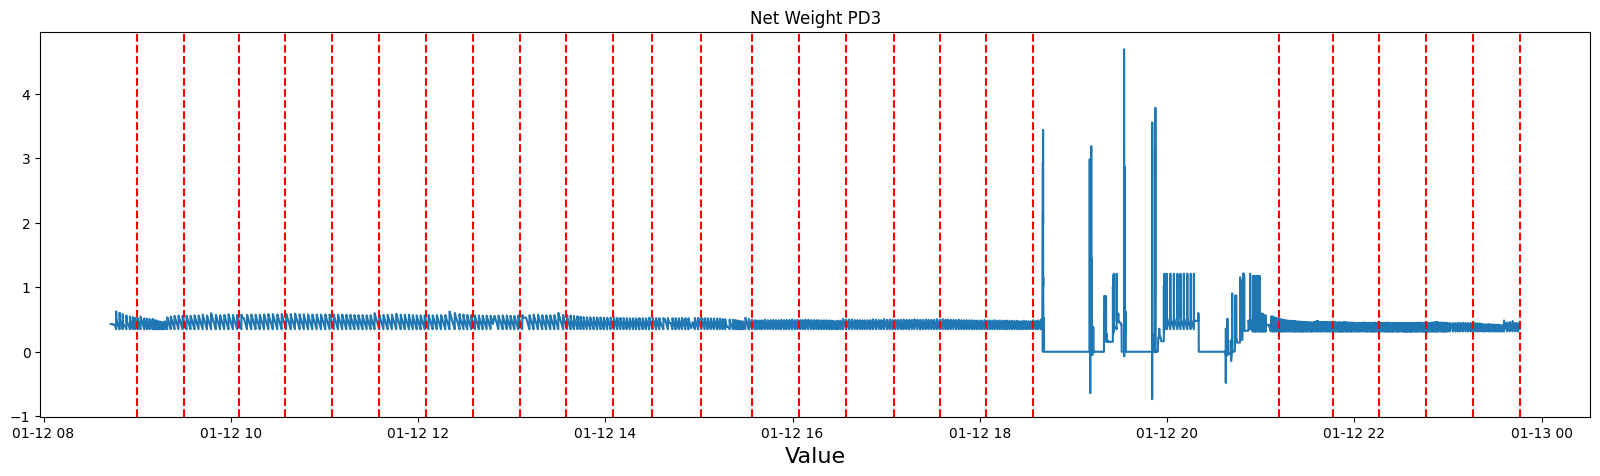

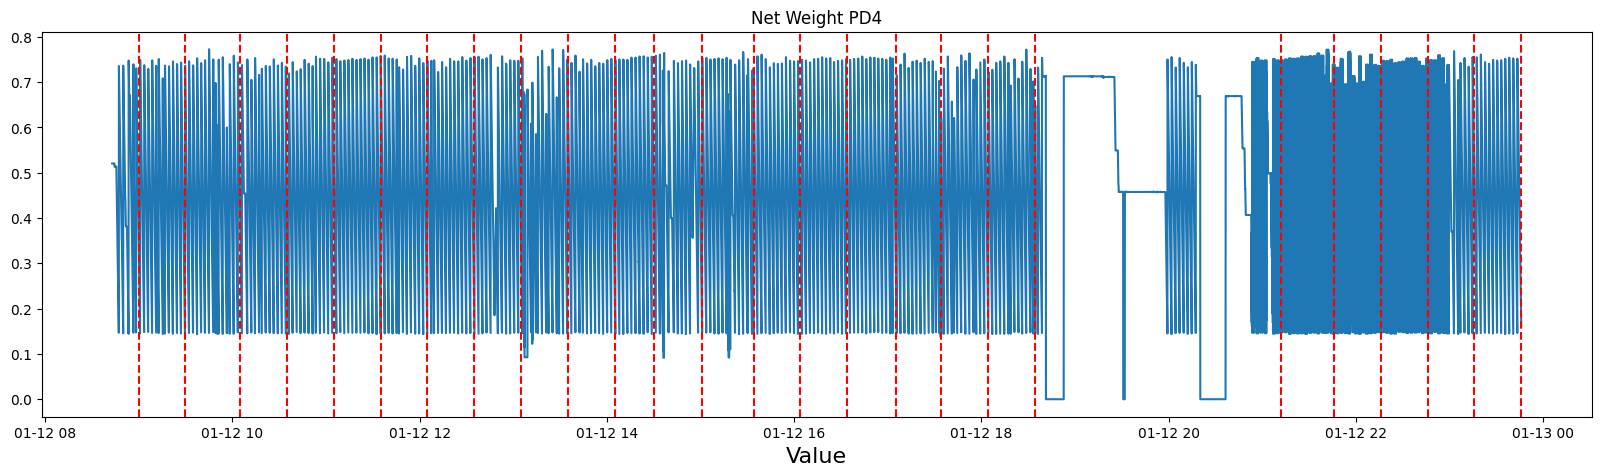

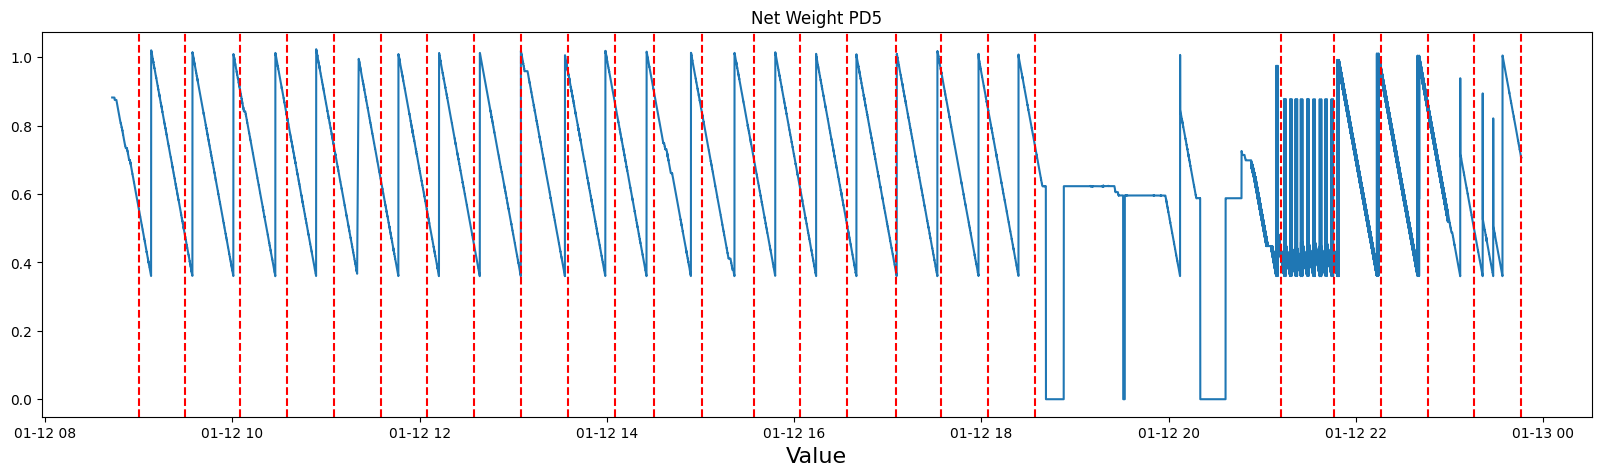

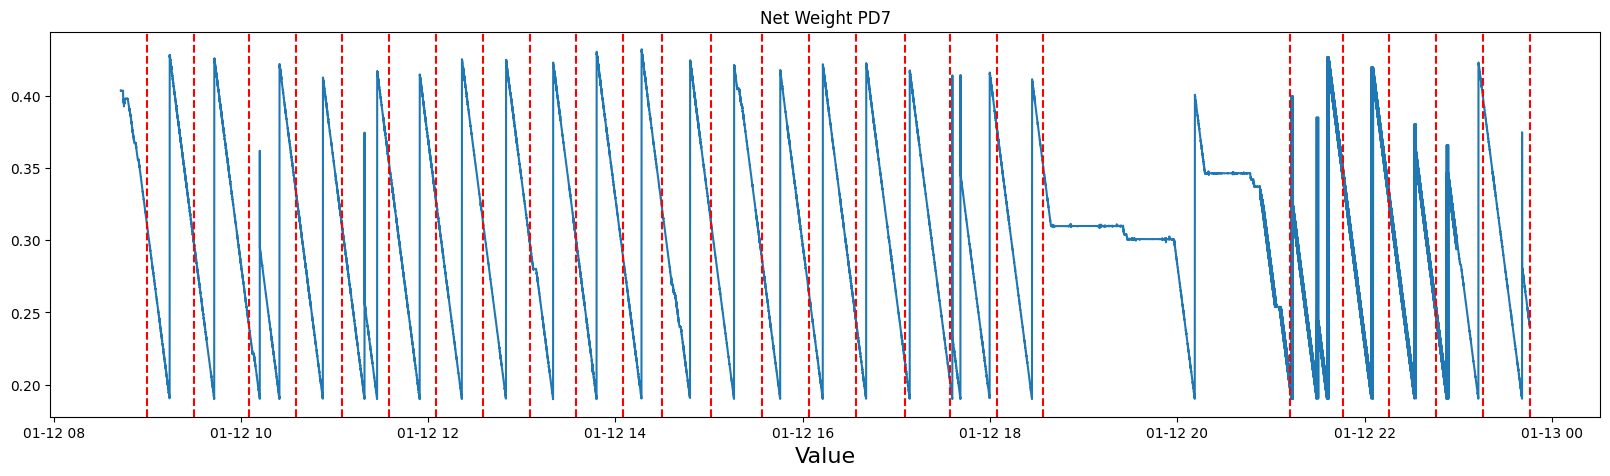

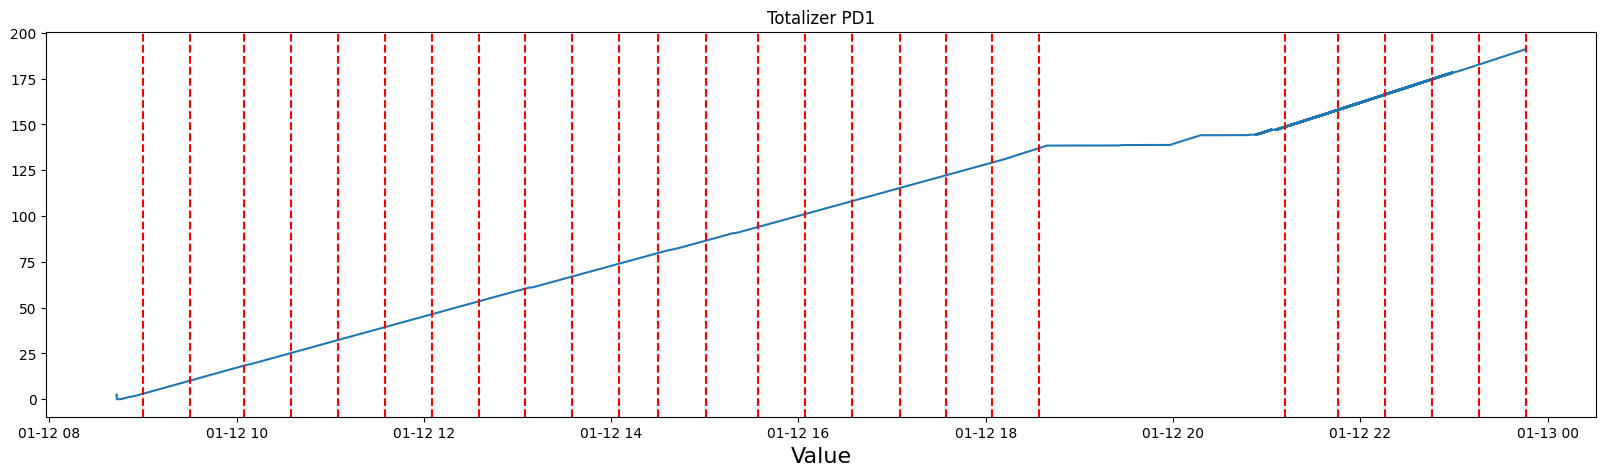

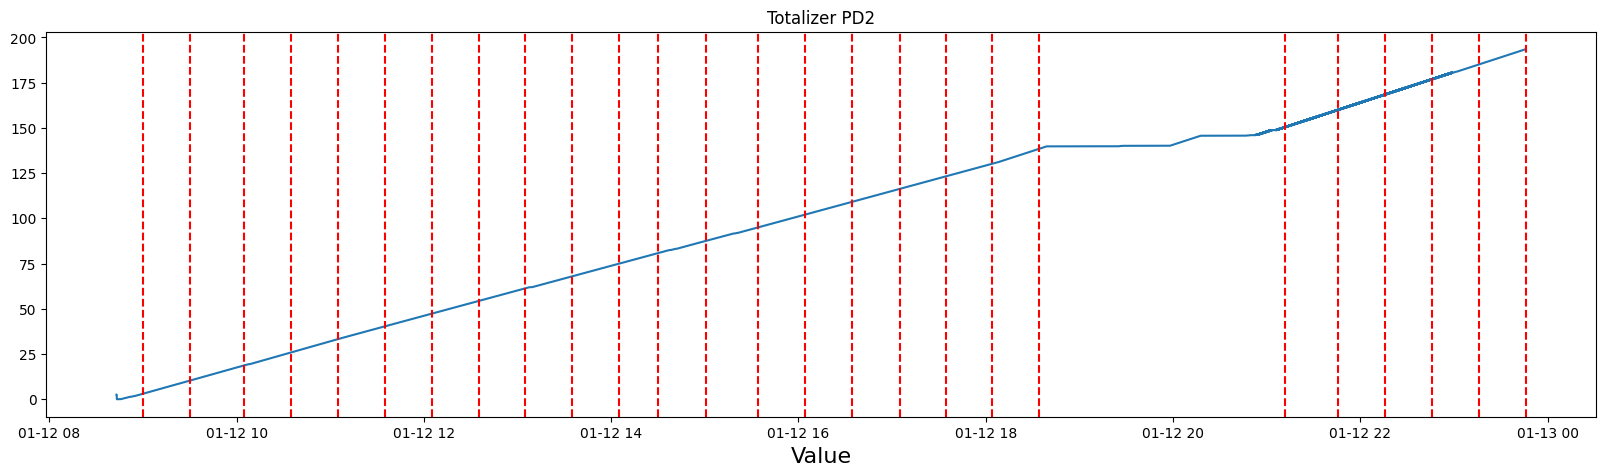

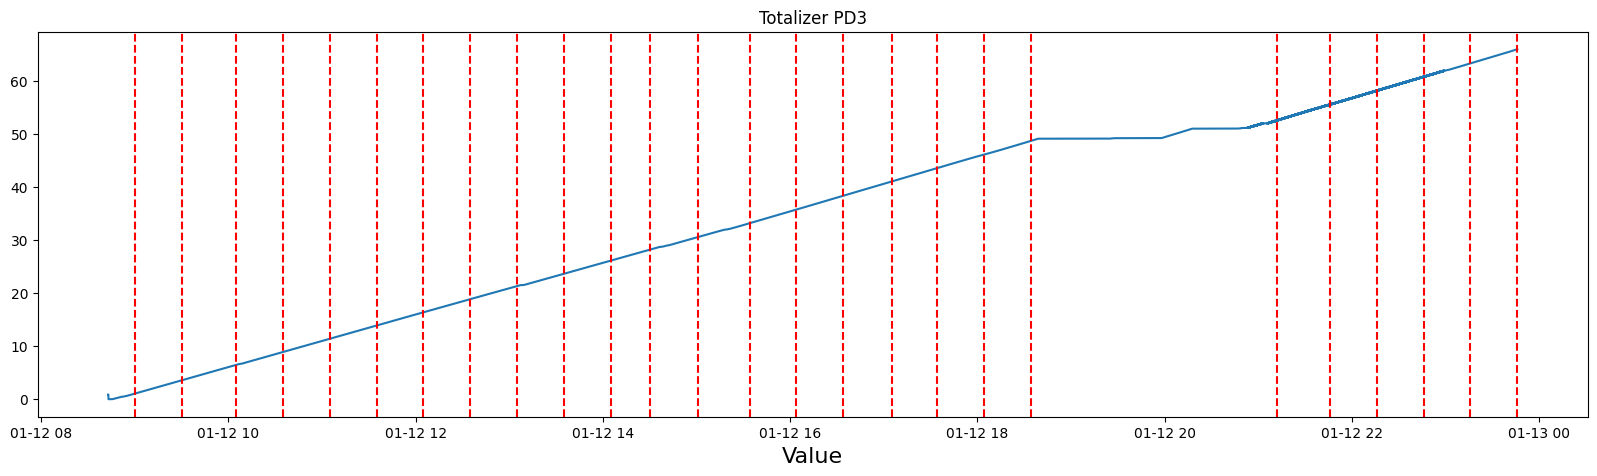

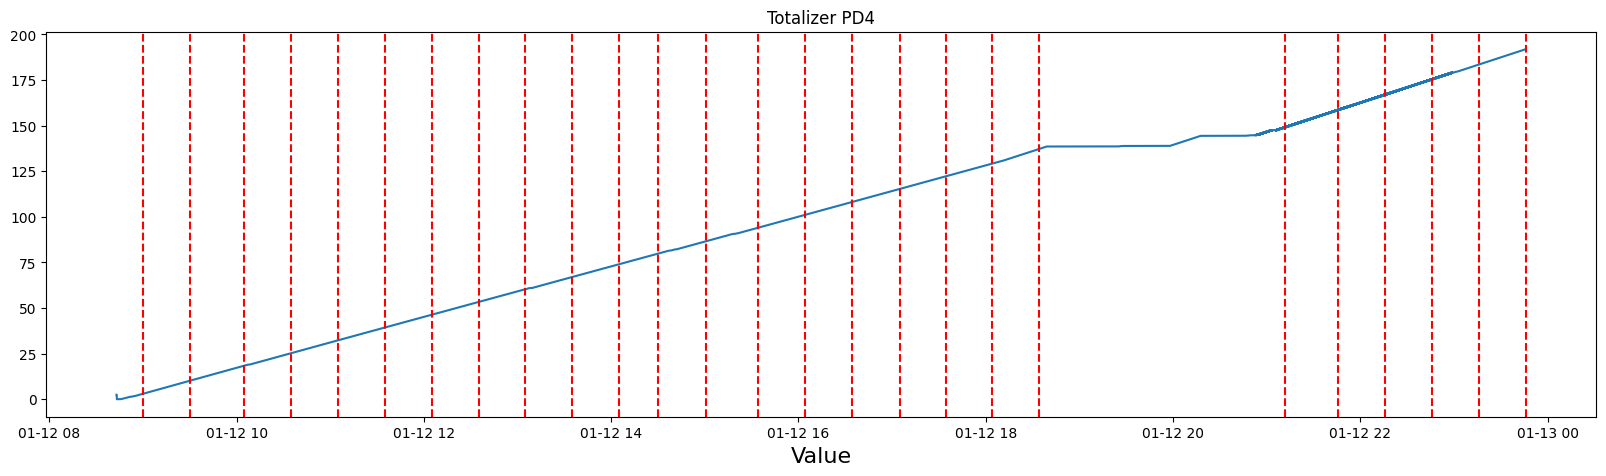

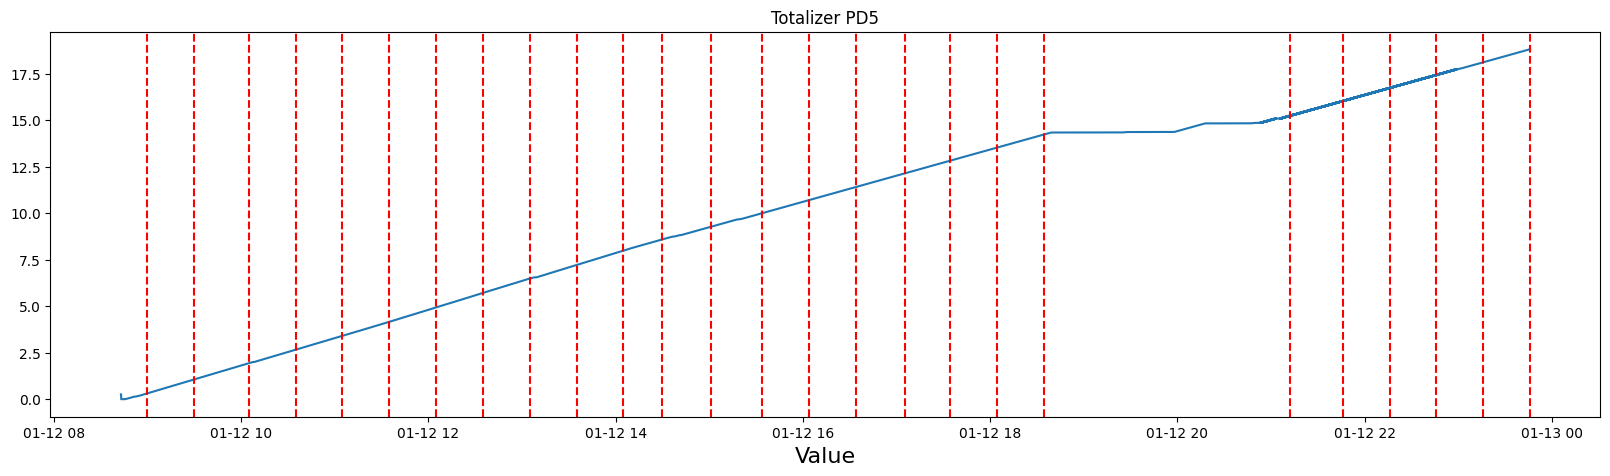

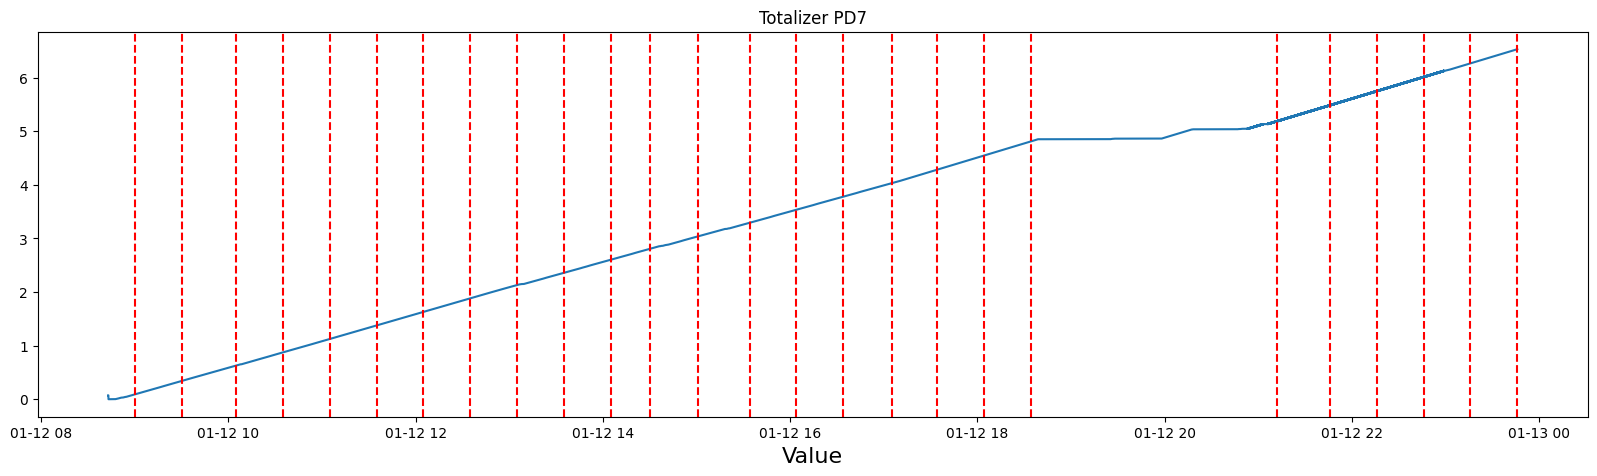

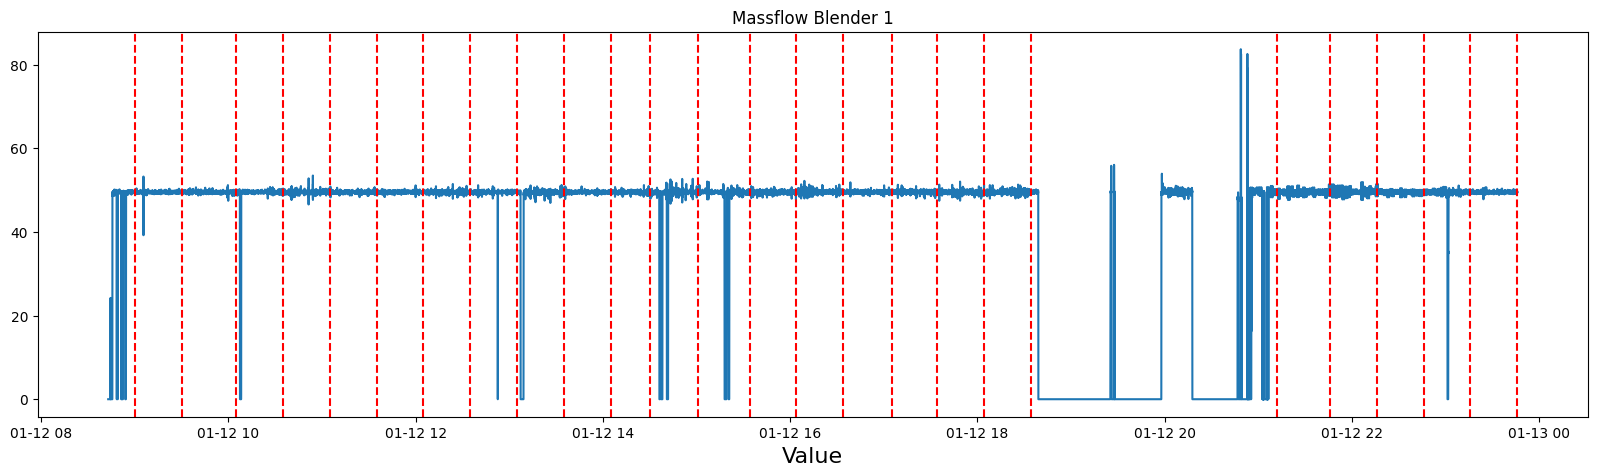

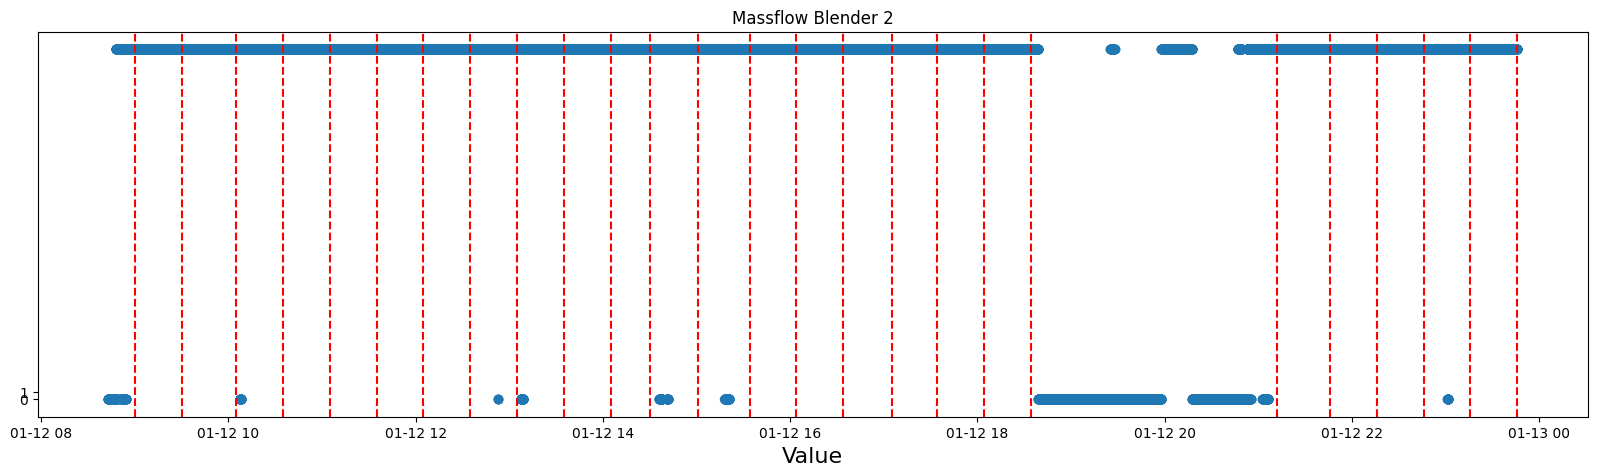

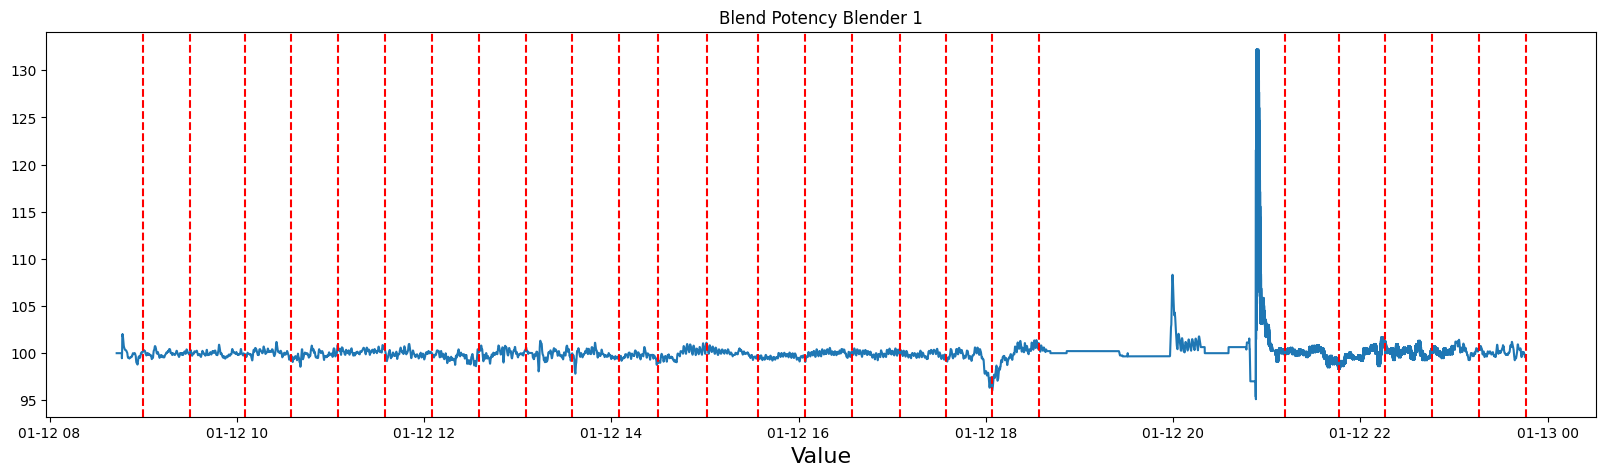

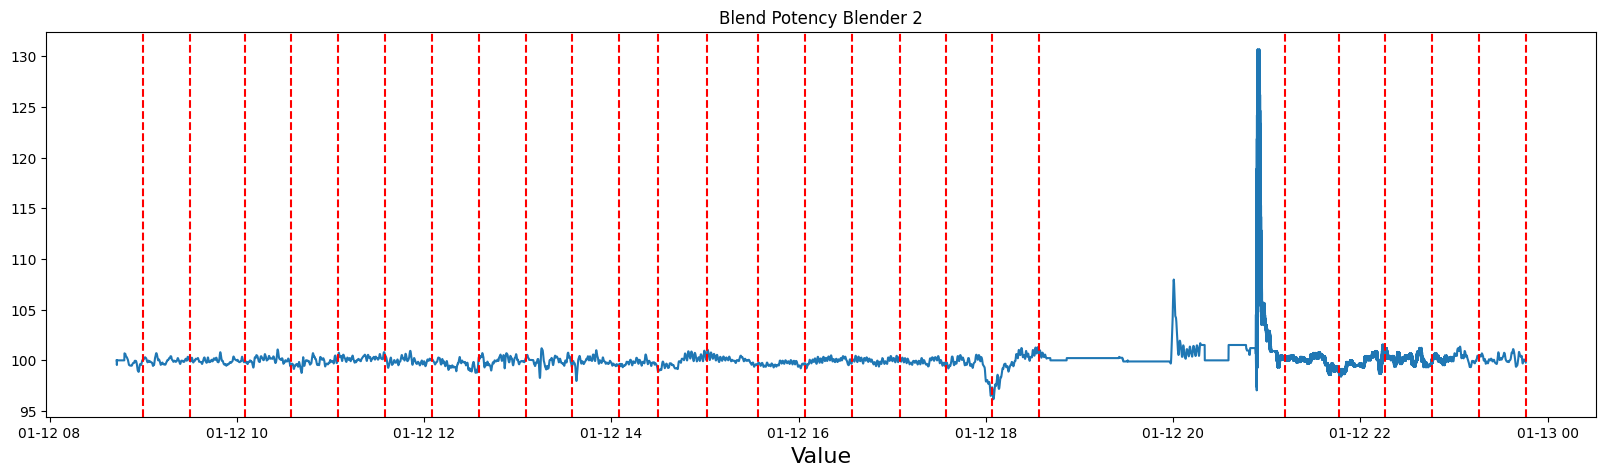

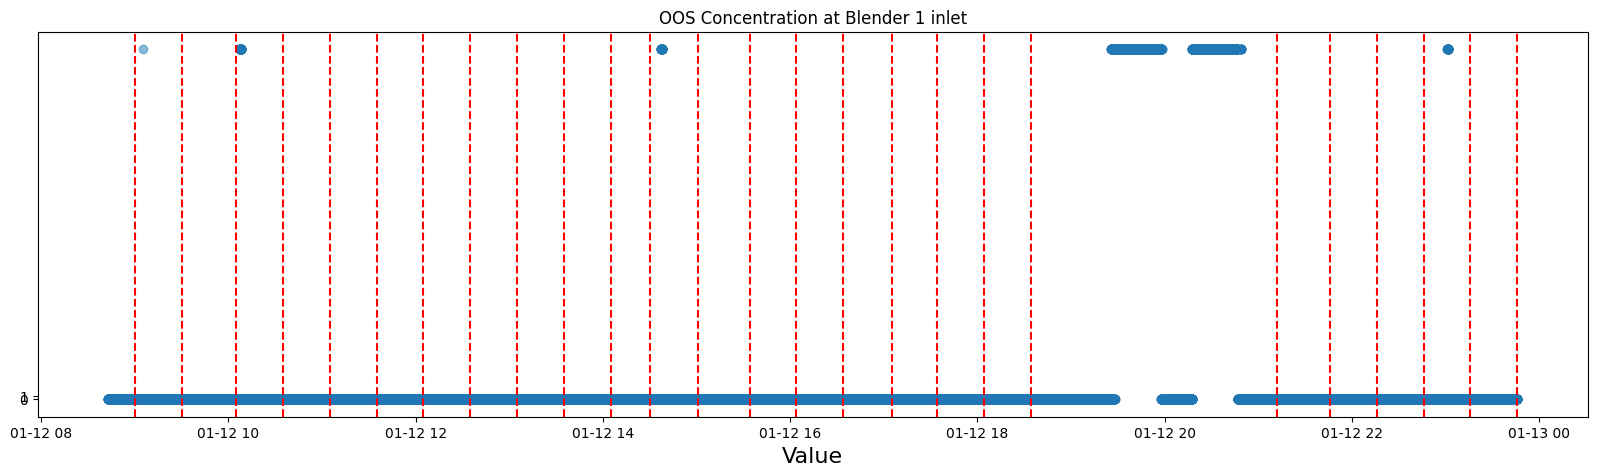

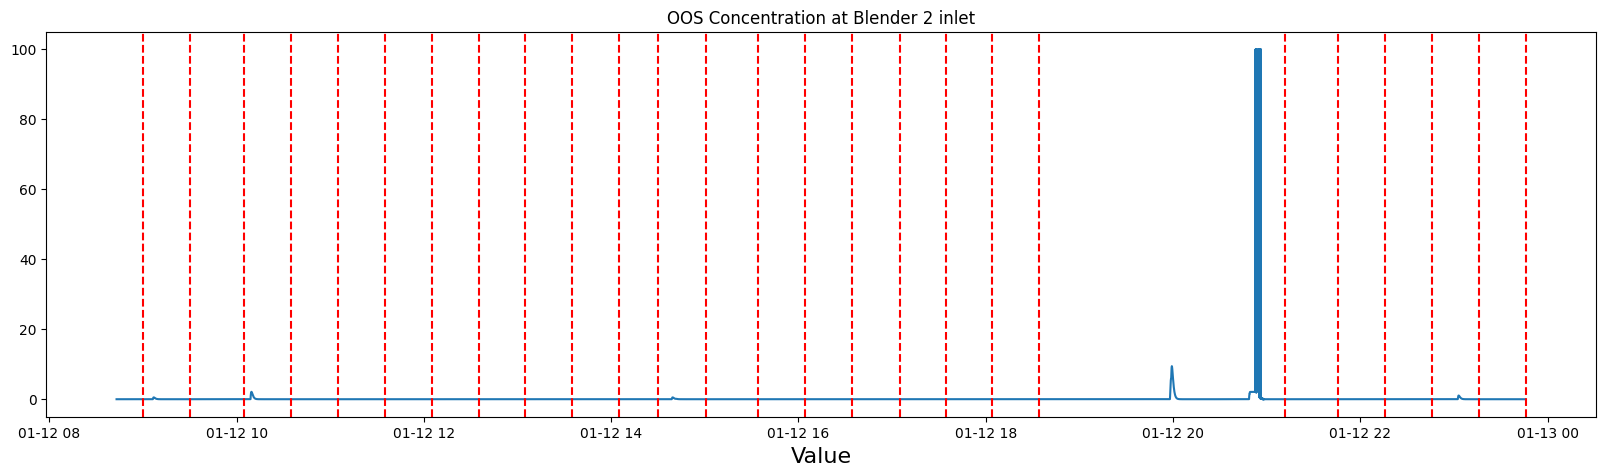

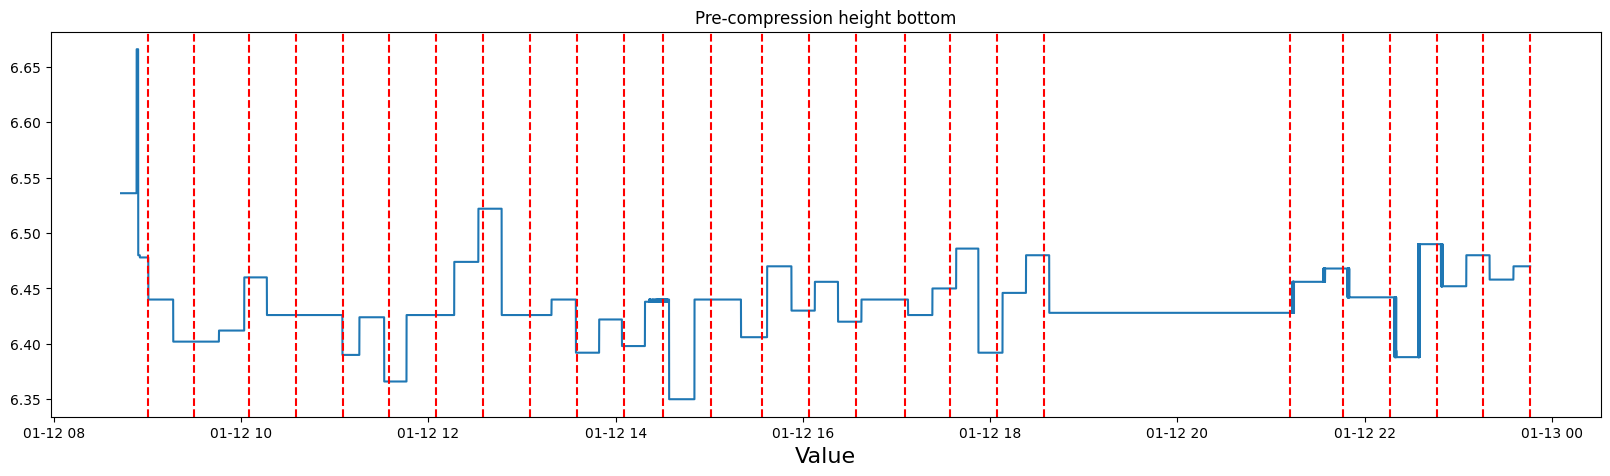

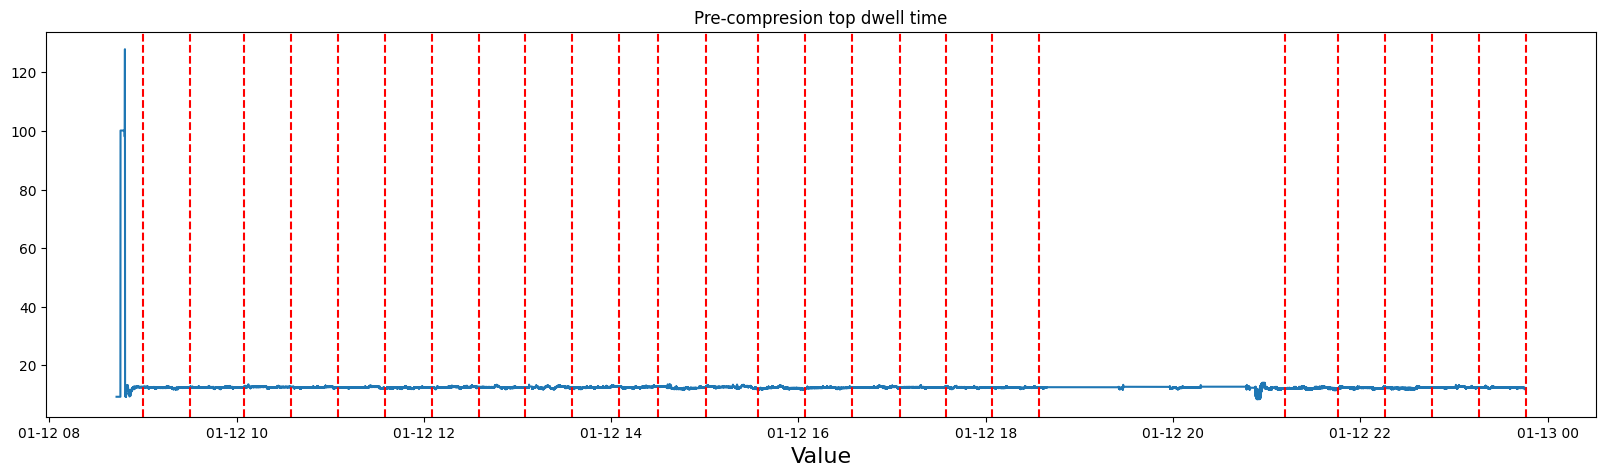

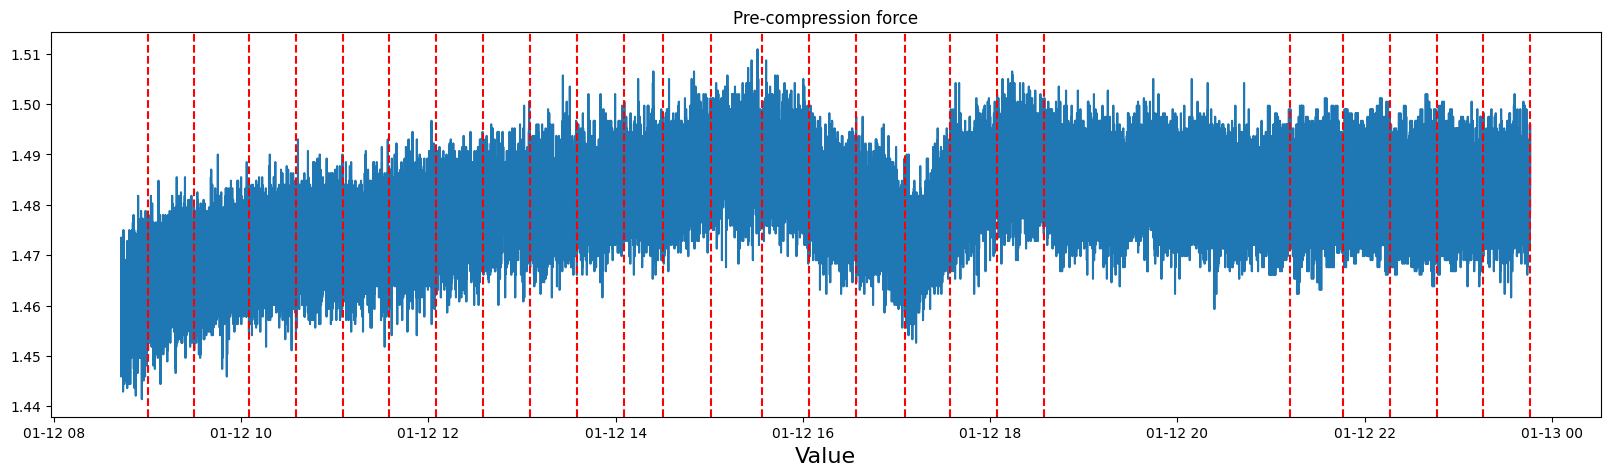

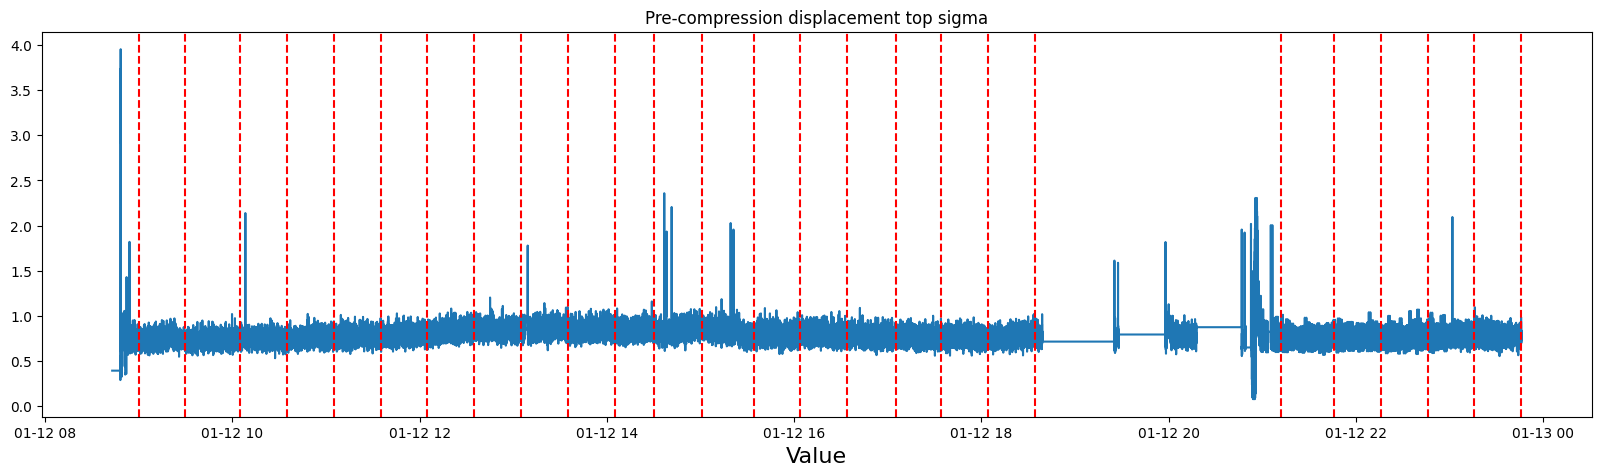

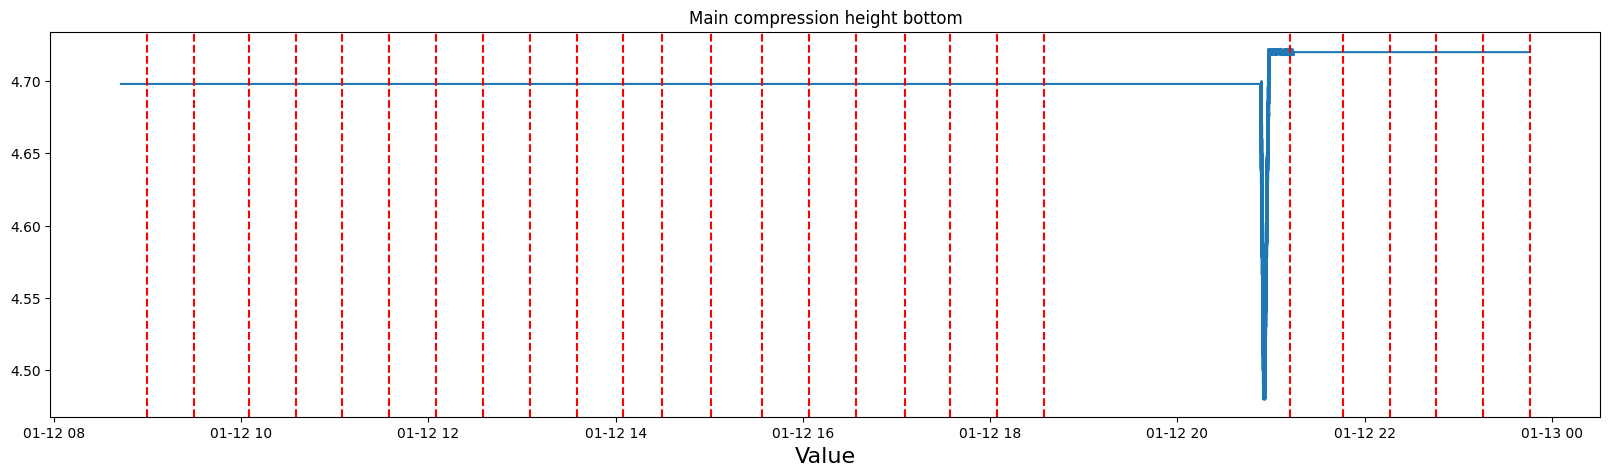

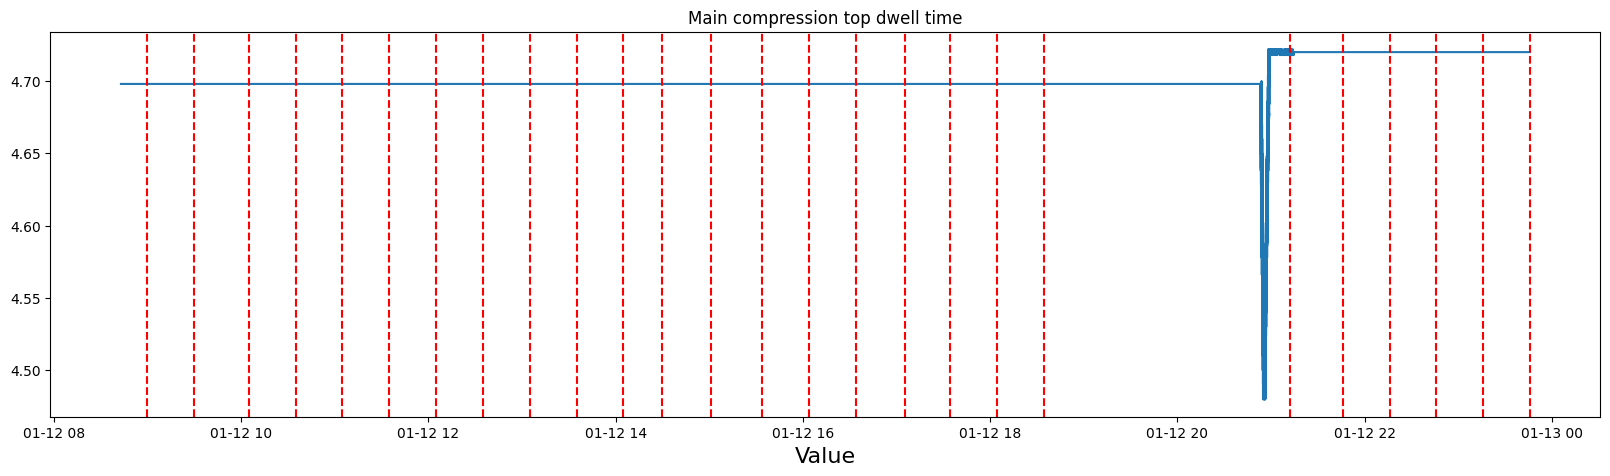

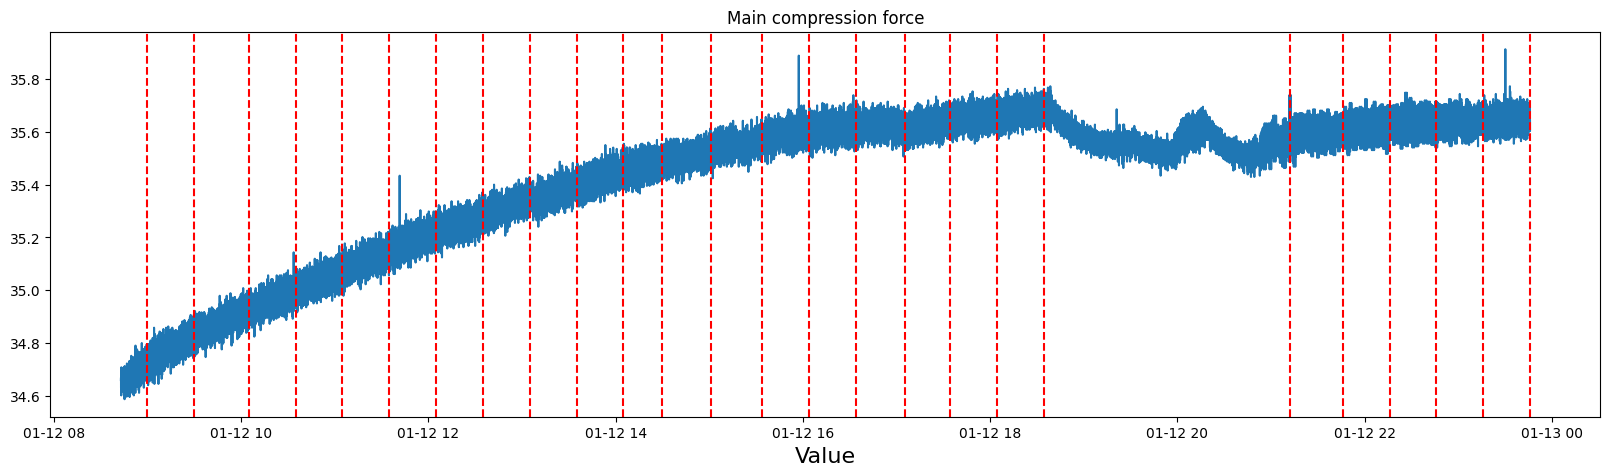

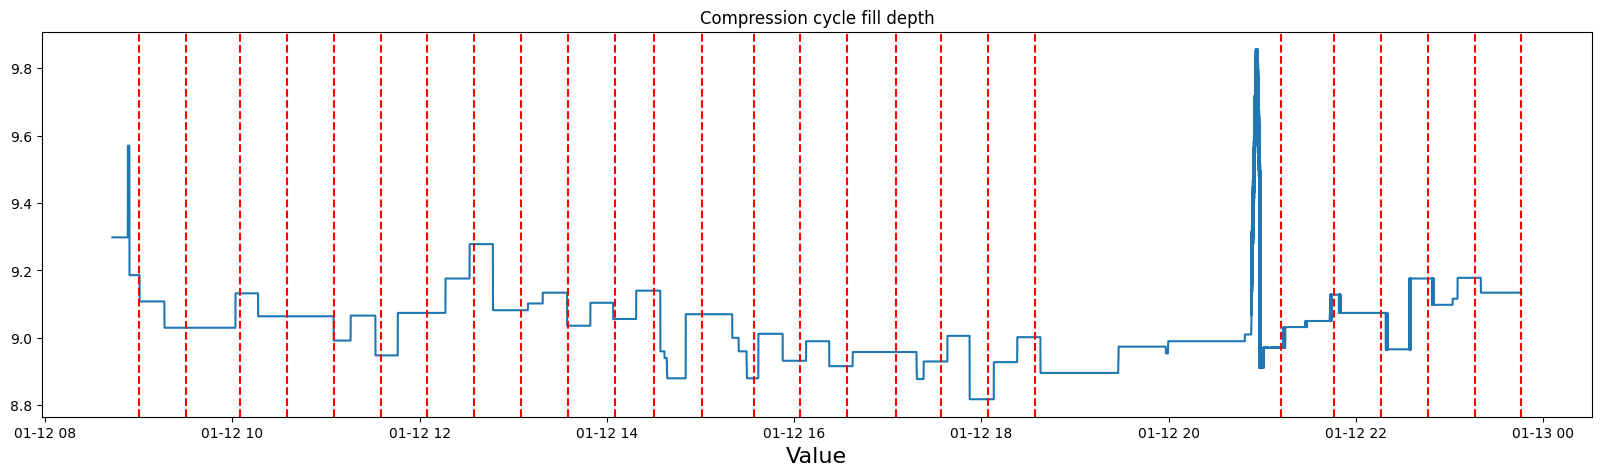

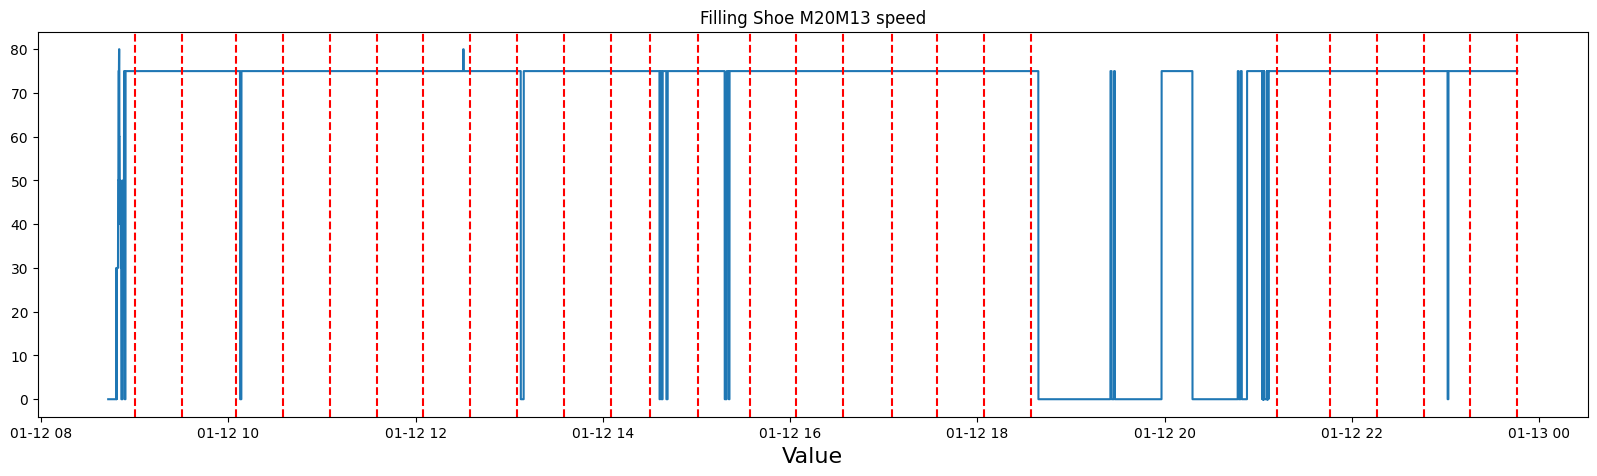

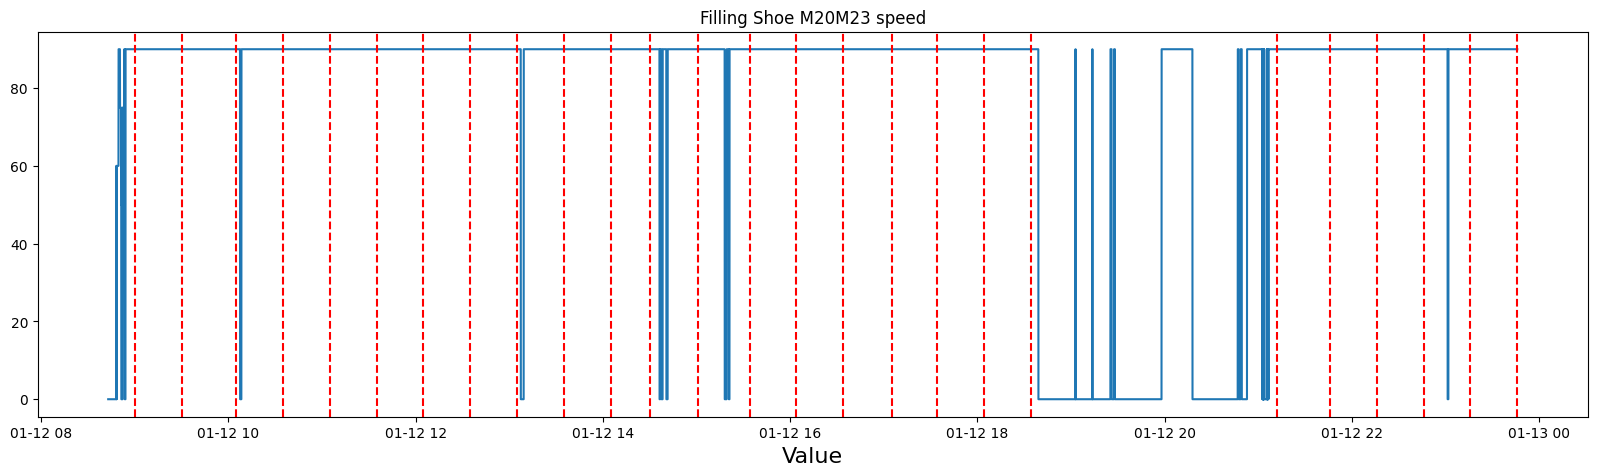

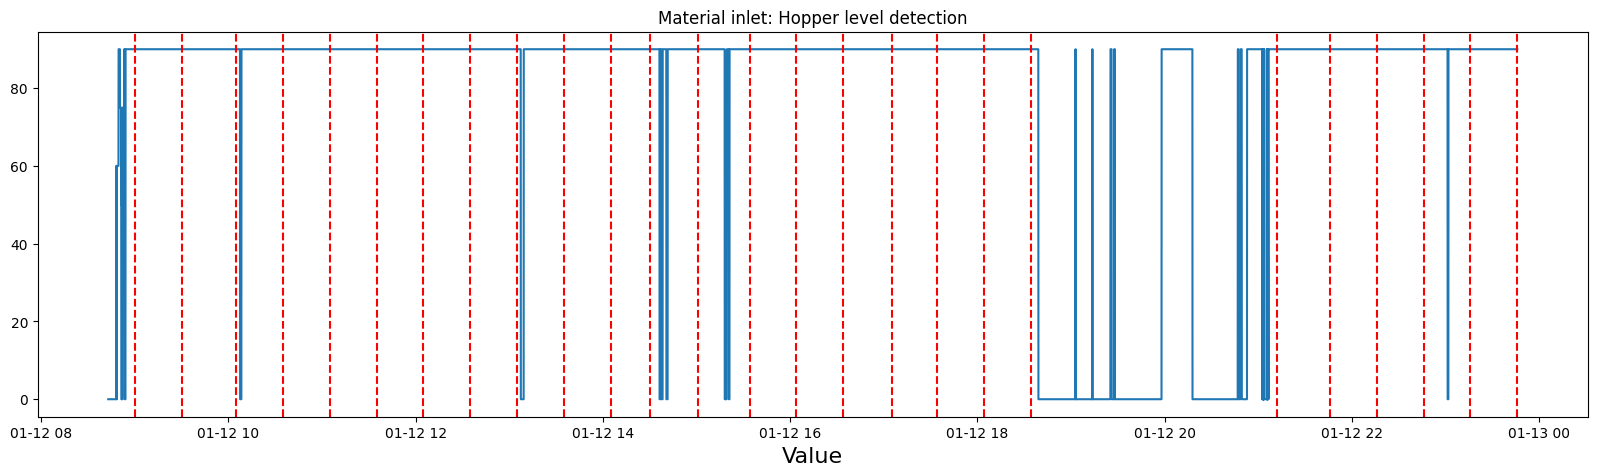

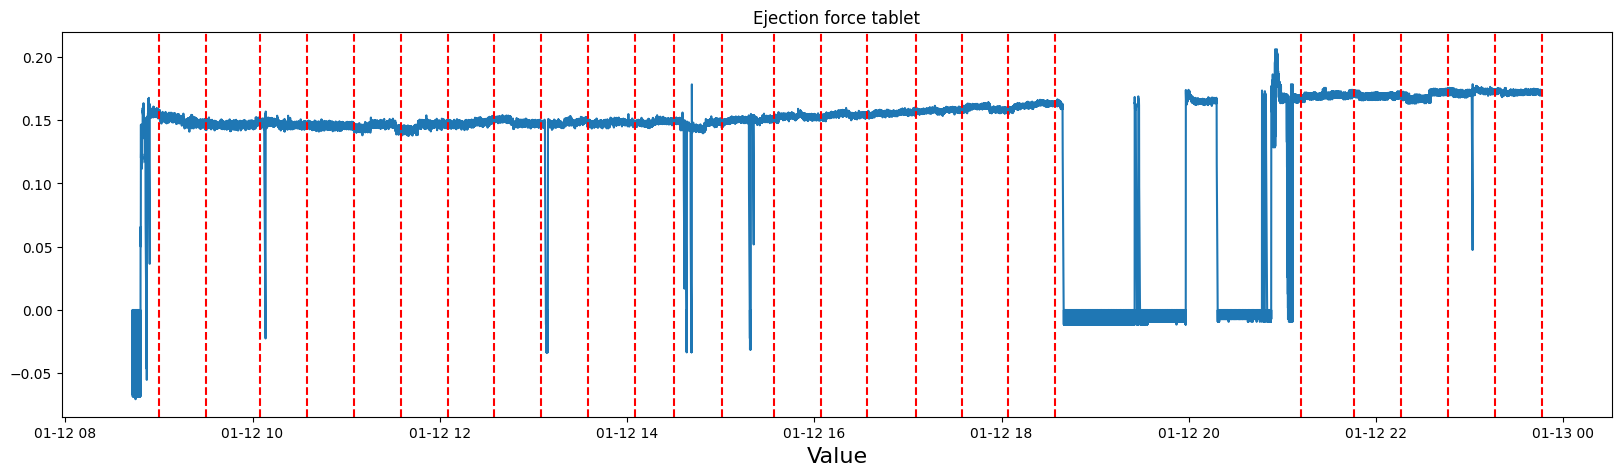

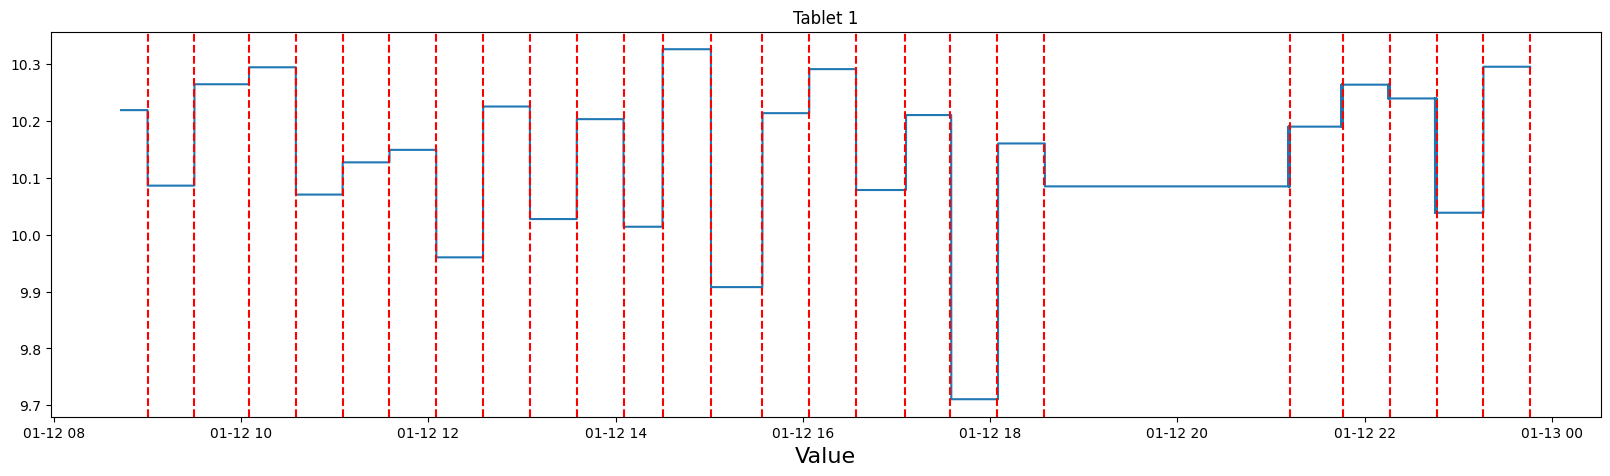

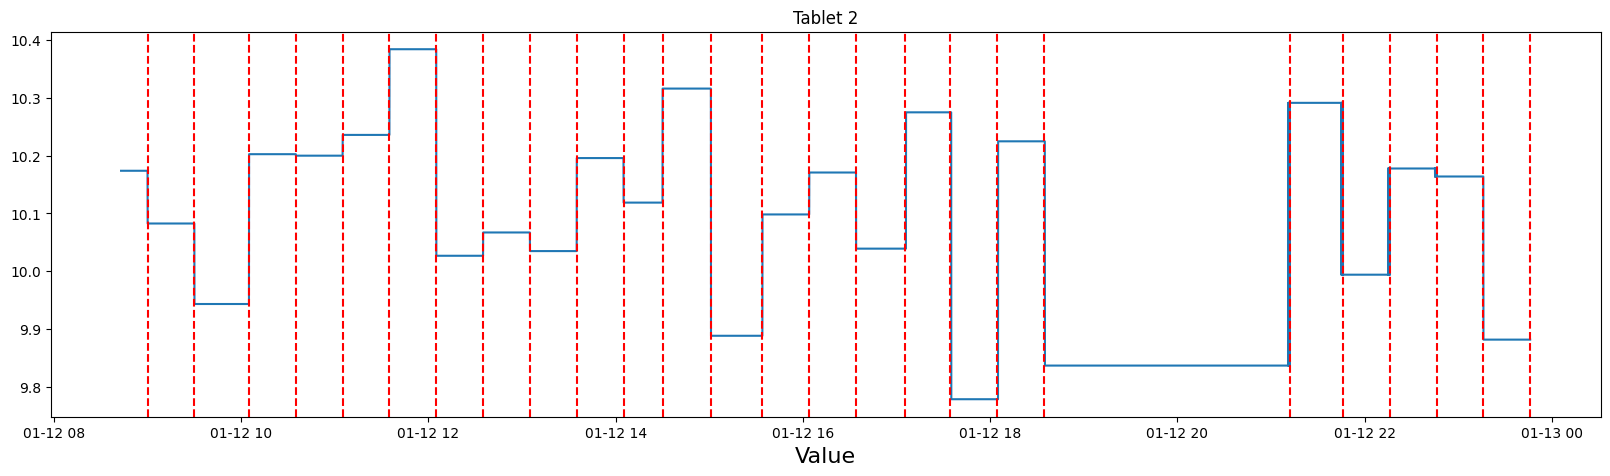

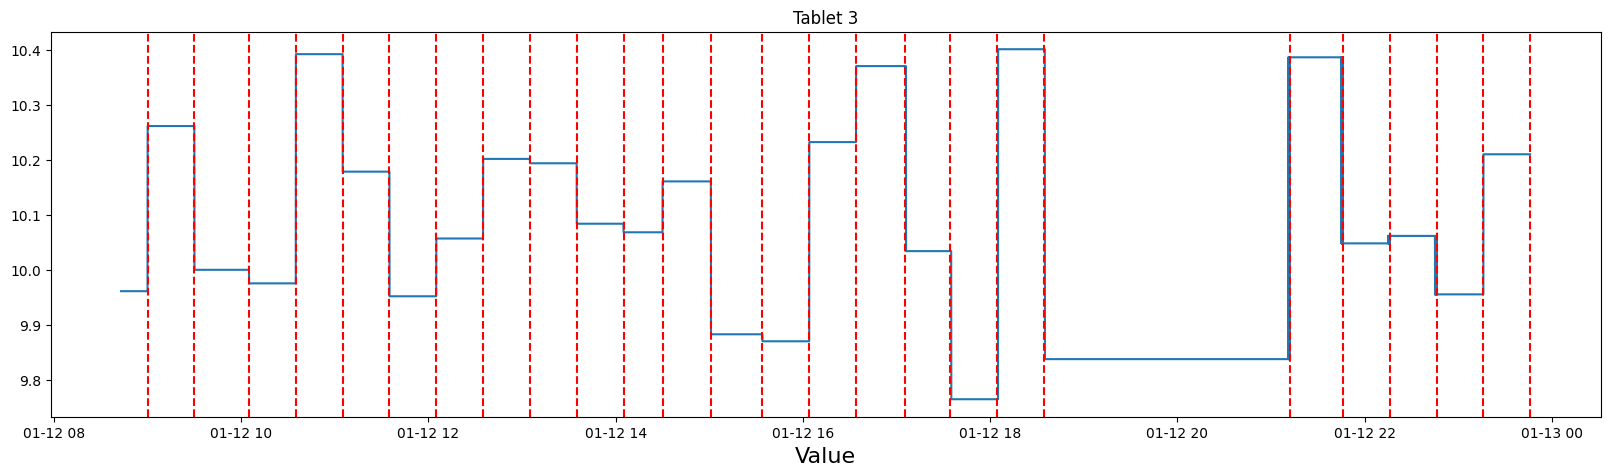

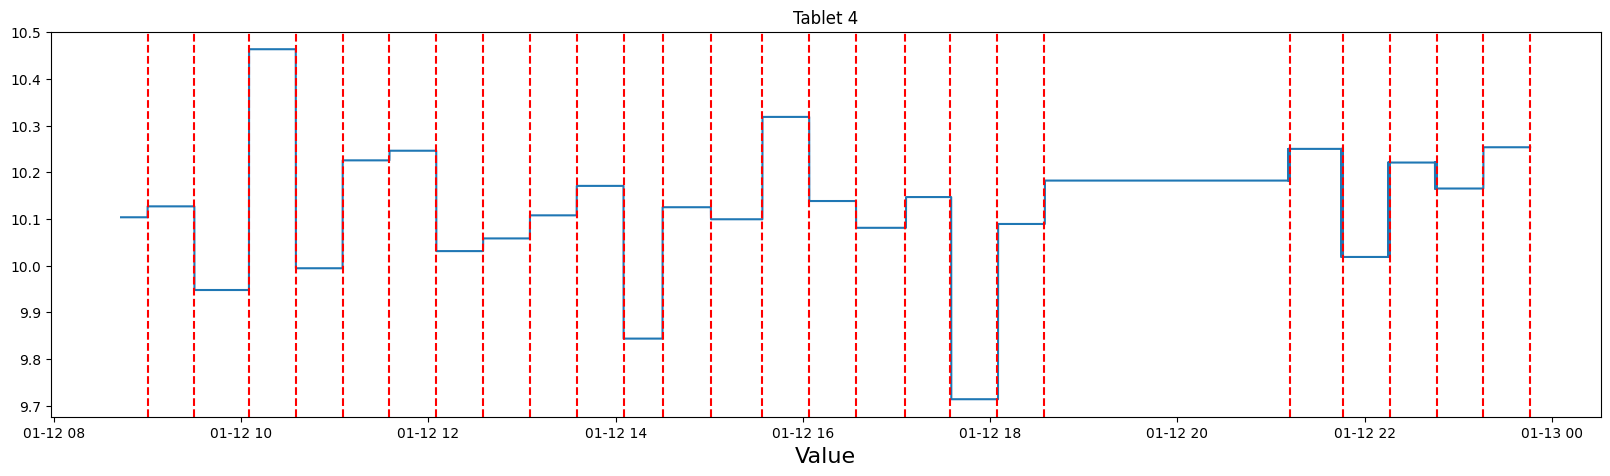

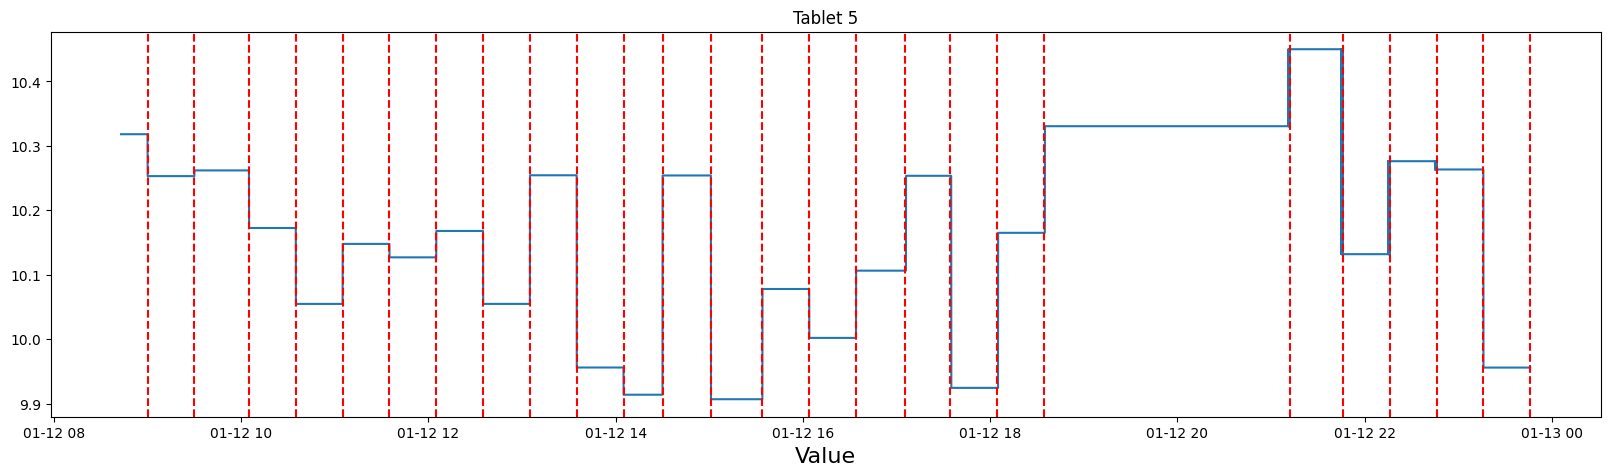

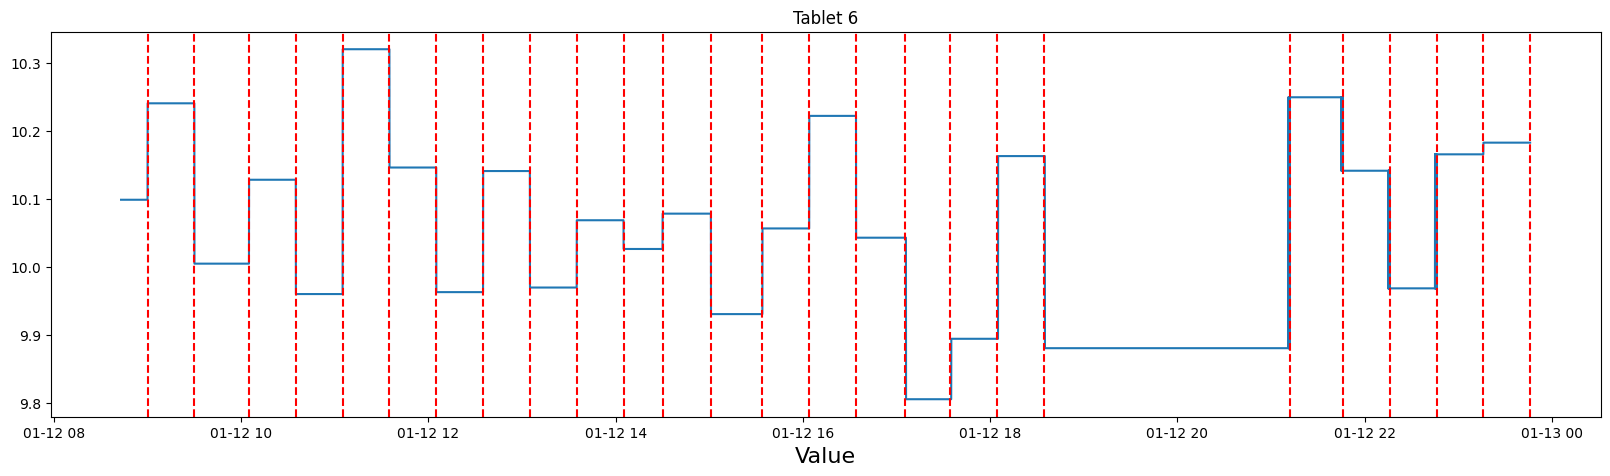

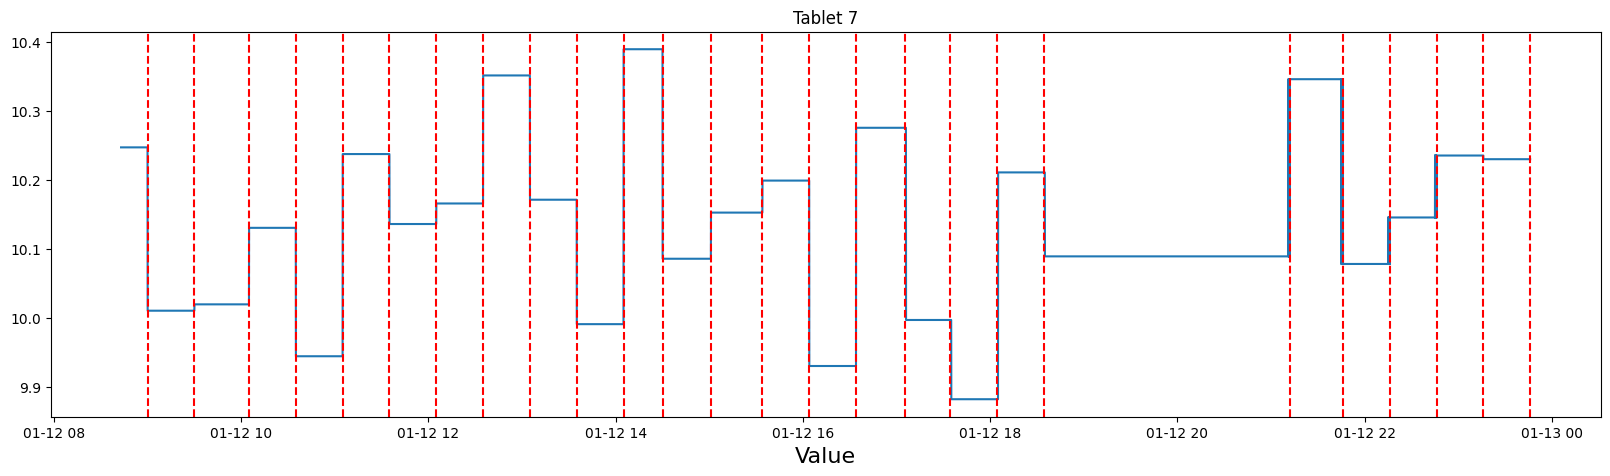

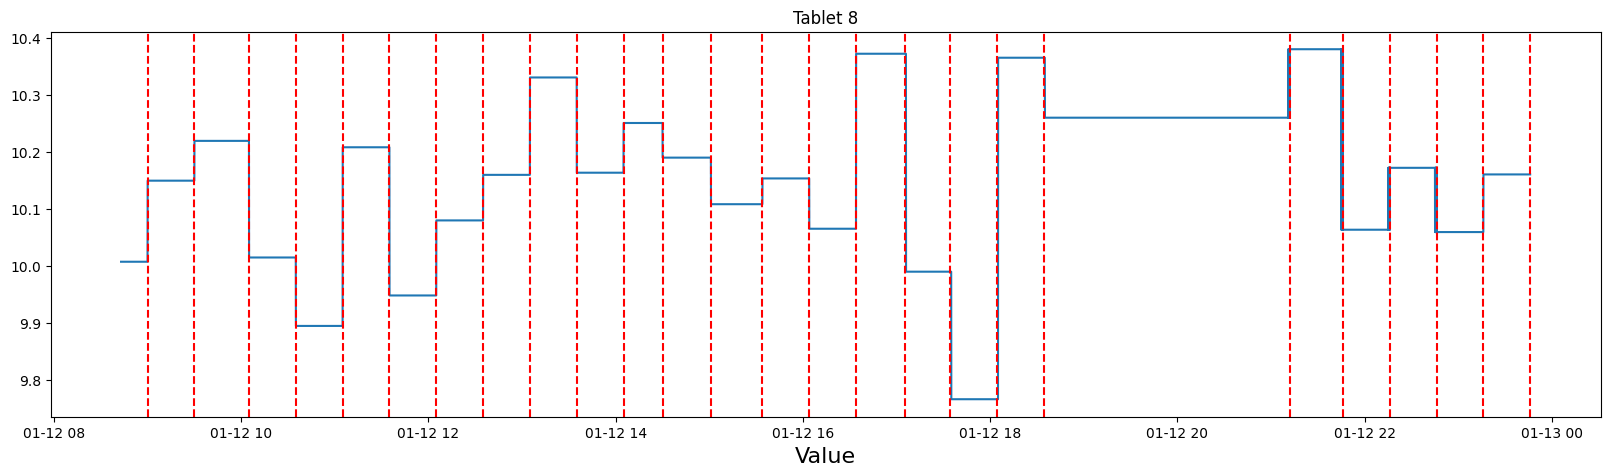

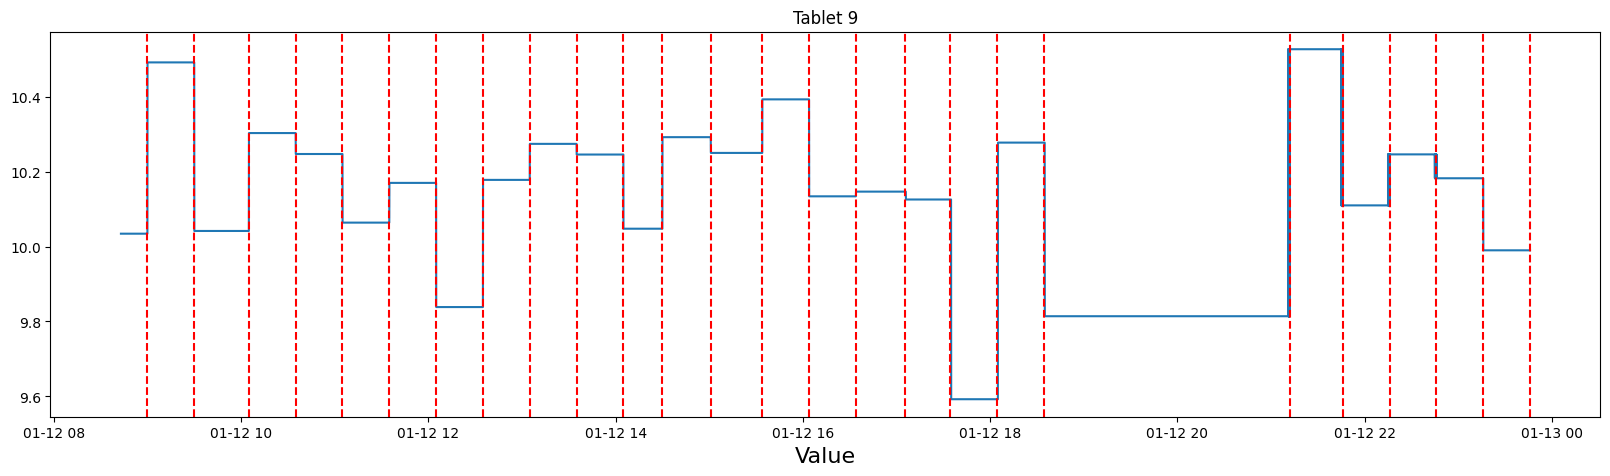

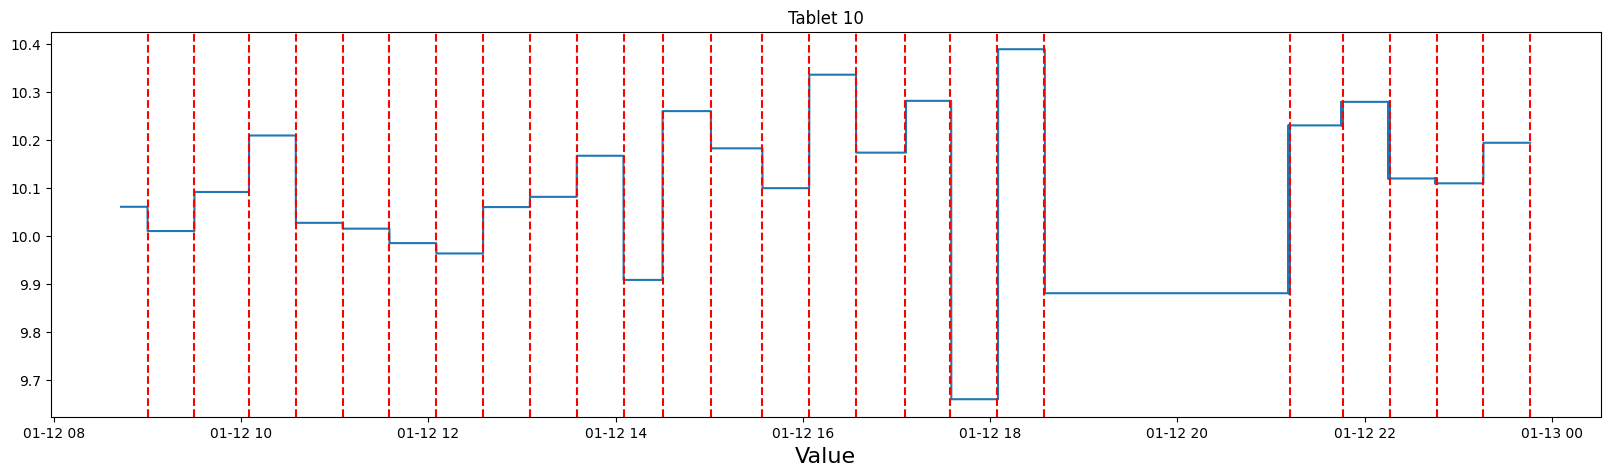

In [41]:
import matplotlib.pyplot as plt

# KDA和時間序列圖
for col in result["API"].columns:
    if col not in ["TimeStamp", "Batch", "sample_time", "sample_id"]:
        plt.figure(figsize=(20, 5))
        
        # 如果是二元值
        if result['API'][col].unique().shape[0] == 2:
            plt.scatter(result['API']['TimeStamp'], result['API'][col], alpha=0.5)  # 繪製散點圖
            plt.yticks([0, 1])  # 限制 Y 軸為 0 和 1
        else:
            plt.plot(result['API']["TimeStamp"], result['API'][col])
        
        for sample_time in sample_times:
            plt.axvline(sample_time, color='r', linestyle='--')

        plt.title(col)
        plt.xlabel('Value', fontsize=16)
        plt.show()

# 數據分析

## 策略
1. 直接使用機器學習方法來做預測
2. 先用F檢定來找出顯著變數，再來使用機器學習方法來做預測
3. 使用PCA作為比較基礎

## 機器學習方法
1. 隨機森林回歸
2. XGboot

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

In [162]:
class TimeSeriesRandomForestRegressor:
    def __init__(self, model_name, df: pd.DataFrame, target: list[str], feature: list[str] = None, folds: int = 5, n_estimators=10, random_state=42):
        self.df = df.sort_values(by="TimeStamp")  # ✅ 確保數據按照時間排序
        self.target = target
        self.feature = feature
        self.model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
        self.model_name = model_name
        self.folds = folds

    def train(self) -> None:
        # **1. 選擇特徵**
        X = self.df.drop(columns=['TimeStamp', 'Batch', 'sample_time', 'sample_id'] + self.target)
        if self.feature is not None:
            X = self.df[self.feature]

        y = self.df[self.target]
        X = X.to_numpy()  # ✅ 轉換為 NumPy 陣列
        y = y.to_numpy()
        
        X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
        y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

        # **2. 設定時間序列交叉驗證**
        tscv = TimeSeriesSplit(n_splits=self.folds)

        mse_scores = []
        r2_scores = []

        # **3. 進行時間序列交叉驗證**
        for fold, (train_index, test_index) in enumerate(tqdm(tscv.split(X_train), total=self.folds, desc="Time Series Cross Validation"), start=1):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

            self.model.fit(X_train_fold, y_train_fold)
            y_pred_fold = self.model.predict(X_test_fold)

            mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
            r2_fold = r2_score(y_test_fold, y_pred_fold)
            mse_scores.append(mse_fold)
            r2_scores.append(r2_fold)

        print(f"Time Series Cross Validation MSE Mean: {np.mean(mse_scores)}")
        print(f"Time Series Cross Validation R² Mean: {np.mean(r2_scores)}")

        # **4. 使用最終訓練集來訓練模型**
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Final Test MSE: {mse}")
        print(f"Final Test R²: {r2}")

        # **5. 將預測點與實際點視覺化**
        for i in range(len(self.target)):
            y_pred_temp = y_pred[:, i]
            y_test_temp = y_test[:, i]
            self.diagram(X_test, y_pred_temp, y_test_temp)

        # **6. 將model儲存
        joblib.dump(self.model, f"./model/{self.model_name}.pkl")
        print(f"Model saved to ./model/{self.model_name}.pkl") 

    # 丟進一些資料，透過這些資料預測結果
    def diagram(self,X_train: np.ndarray, y_pred: np.ndarray, y_test: np.ndarray) -> None:        
        plt.figure(figsize=(20, 5))
        time_index = list(df.columns).index('TimeStamp')
        print(X_train[:, time_index])
        plt.scatter(X_train[:, time_index], y_pred, label="Predicted Value", linestyle="--", marker="o")
        plt.scatter(X_train[:, time_index], y_test, label="Predicted Value", linestyle="--", marker="x")
        plt.xlabel("Sample Index")
        plt.ylabel("Value")
        plt.title("Predicted Time Series Data")
        plt.legend()
        plt.grid()
        plt.show()


In [102]:
targets = ['Tablet 1', 'Tablet 2', 'Tablet 3', 'Tablet 4', 'Tablet 5', 'Tablet 6', 'Tablet 7', 'Tablet 8', 'Tablet 9', 'Tablet 10']

In [161]:
a = result['API'].to_numpy()
i = list(result['API']).index('TimeStamp')
print(a[:, i])

[Timestamp('2018-01-12 08:43:01') Timestamp('2018-01-12 08:43:02')
 Timestamp('2018-01-12 08:43:03') ... Timestamp('2018-01-12 23:45:57')
 Timestamp('2018-01-12 23:45:58') Timestamp('2018-01-12 23:45:59')]


Time Series Cross Validation: 100%|██████████| 2/2 [00:20<00:00, 10.48s/it]


Time Series Cross Validation MSE Mean: 4.4286209066831293e-05
Time Series Cross Validation R² Mean: 0.9980921496972862
Final Test MSE: 2.143380509155848e-05
Final Test R²: 0.9990267325776644
[1.2814 1.3013 1.355  ... 1.392  1.4132 1.2933]


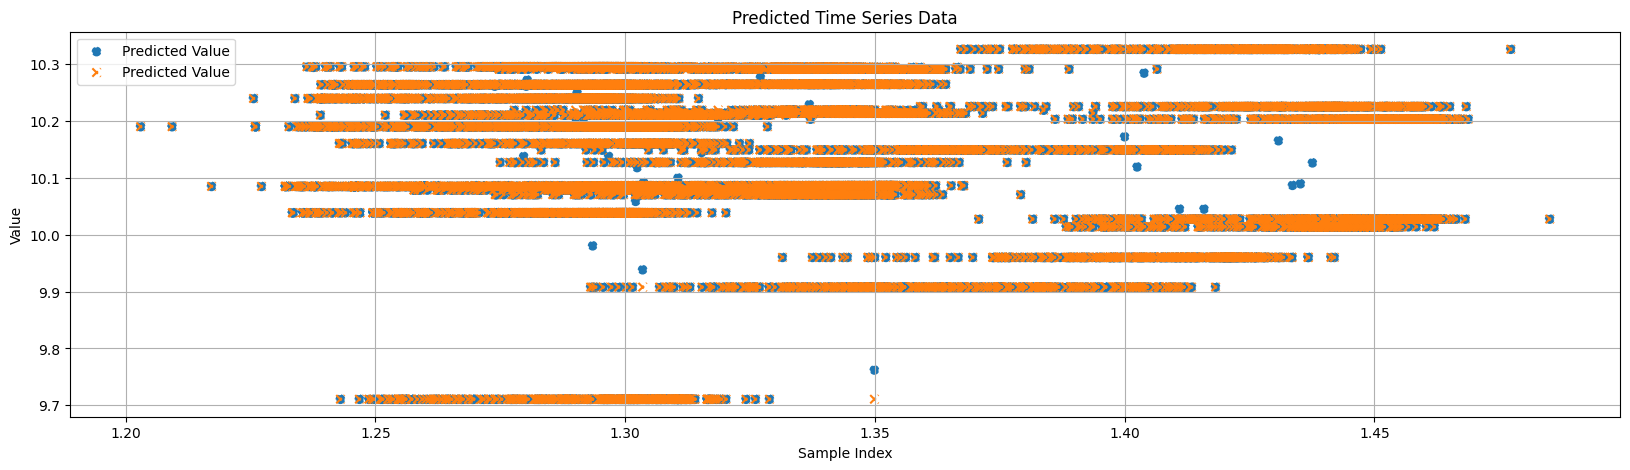

[1.2814 1.3013 1.355  ... 1.392  1.4132 1.2933]


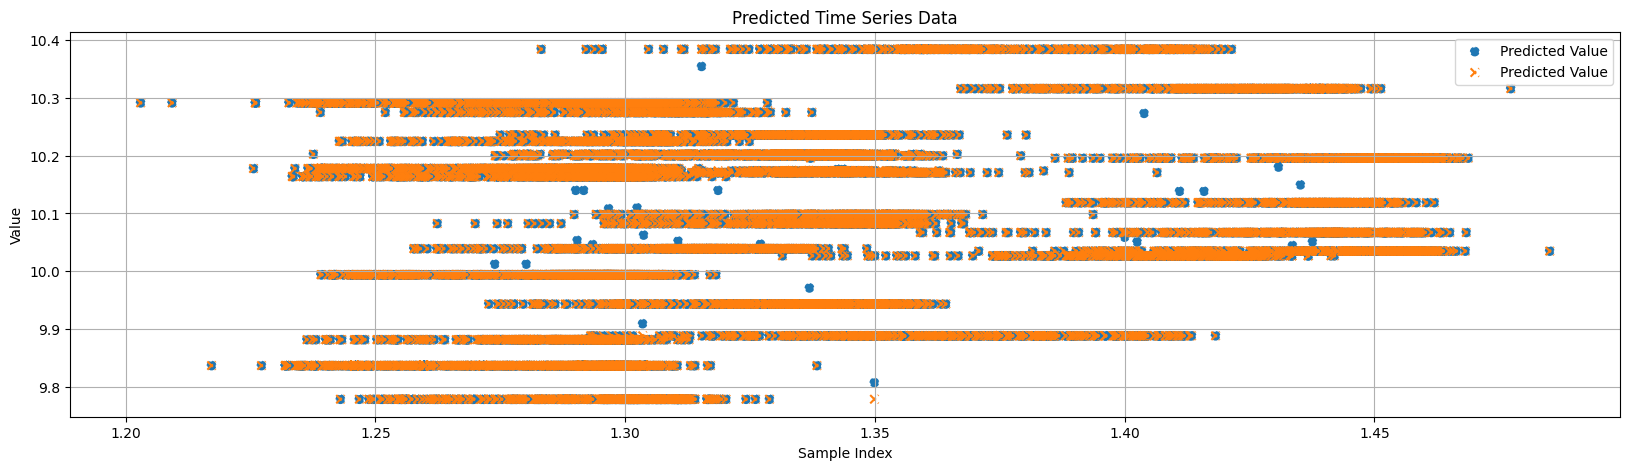

[1.2814 1.3013 1.355  ... 1.392  1.4132 1.2933]


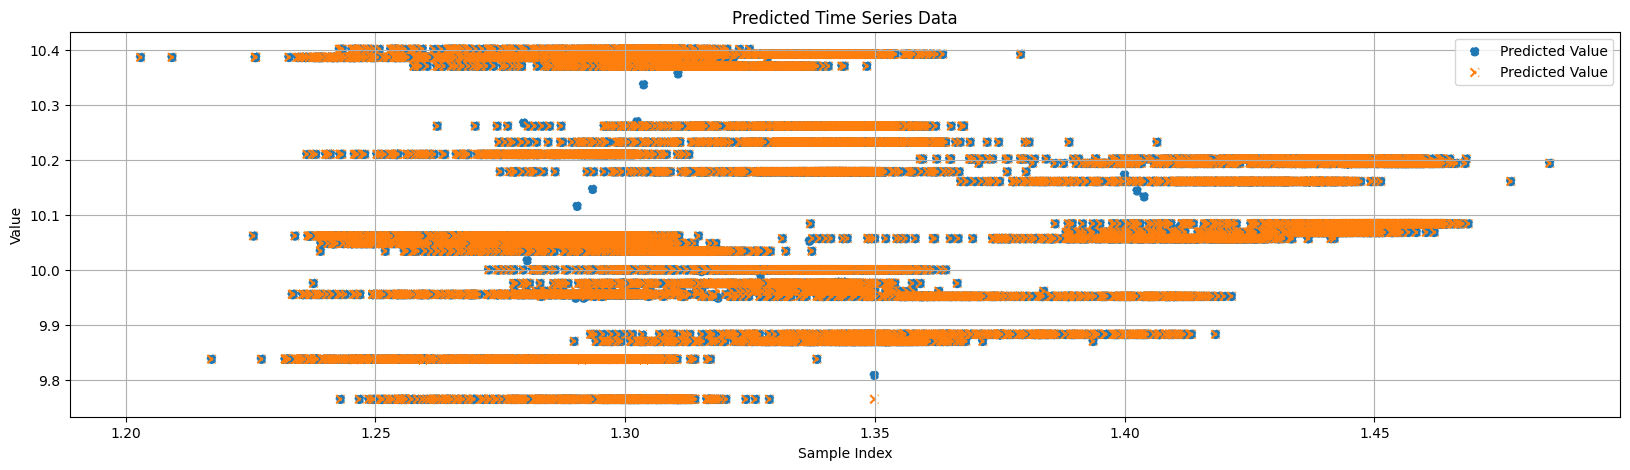

[1.2814 1.3013 1.355  ... 1.392  1.4132 1.2933]


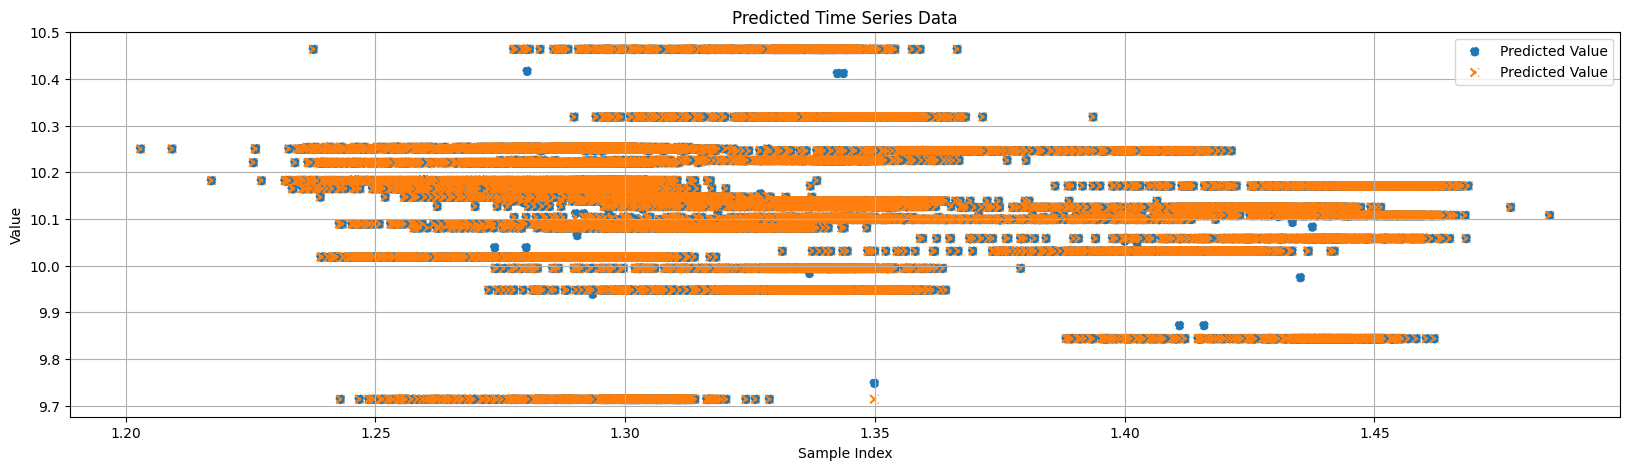

[1.2814 1.3013 1.355  ... 1.392  1.4132 1.2933]


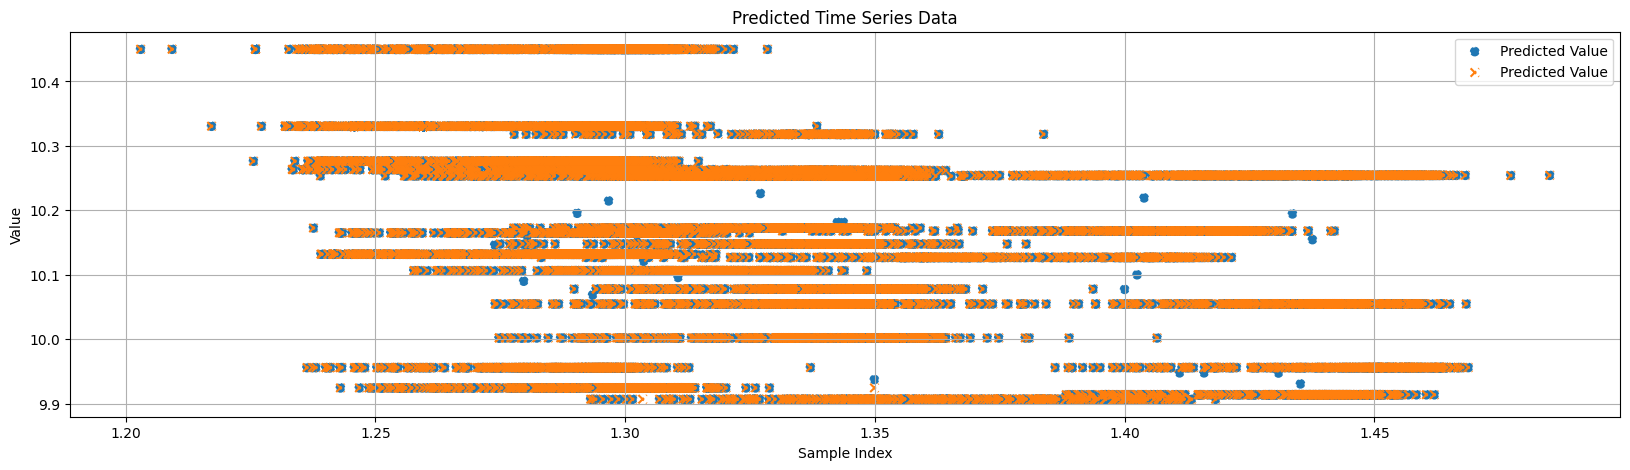

[1.2814 1.3013 1.355  ... 1.392  1.4132 1.2933]


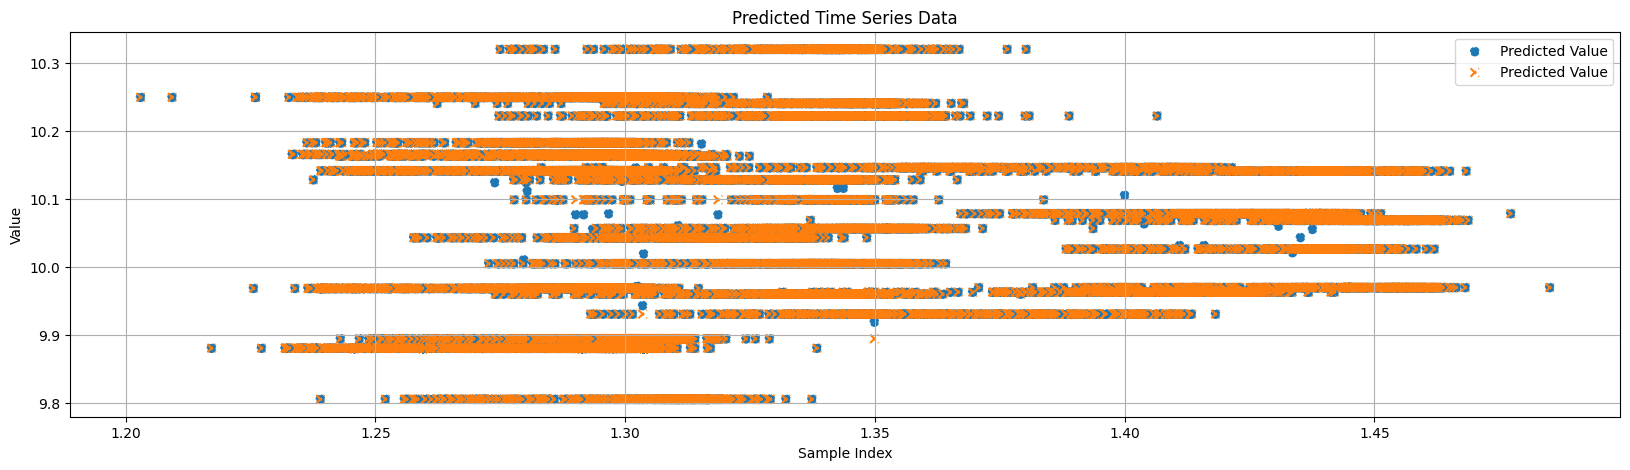

[1.2814 1.3013 1.355  ... 1.392  1.4132 1.2933]


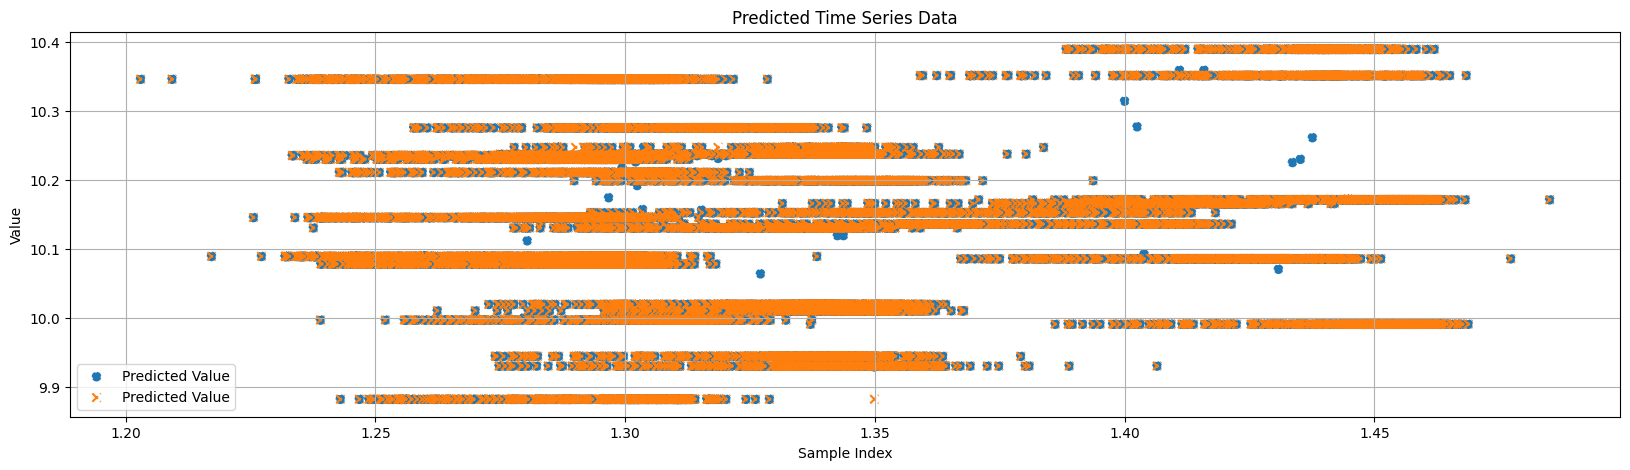

[1.2814 1.3013 1.355  ... 1.392  1.4132 1.2933]


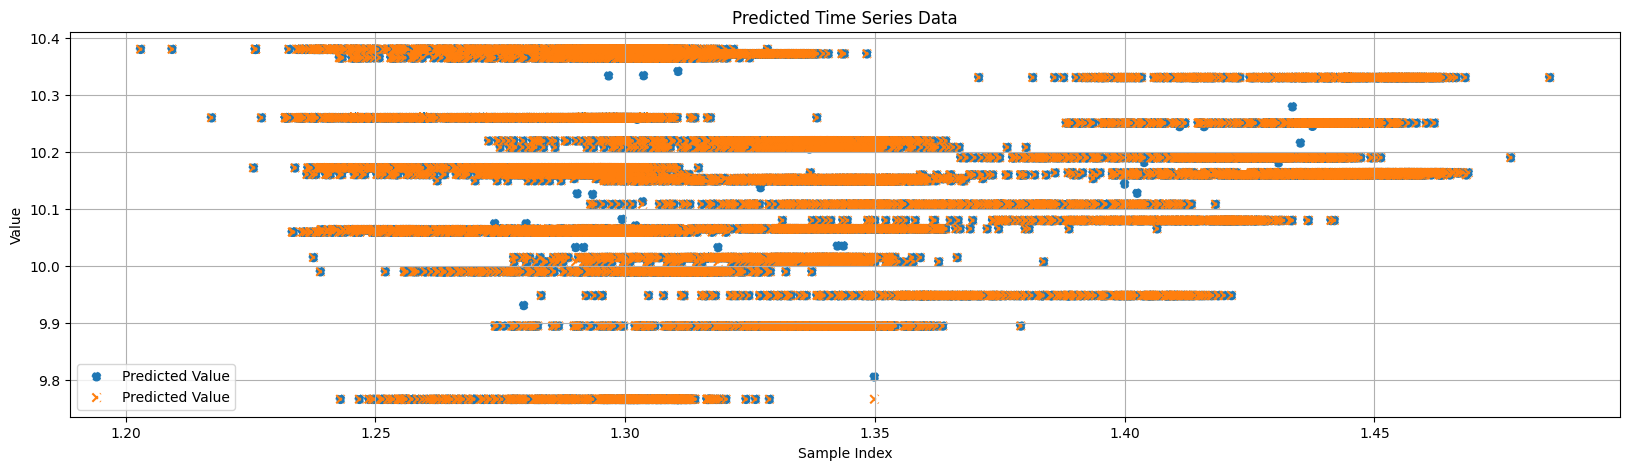

[1.2814 1.3013 1.355  ... 1.392  1.4132 1.2933]


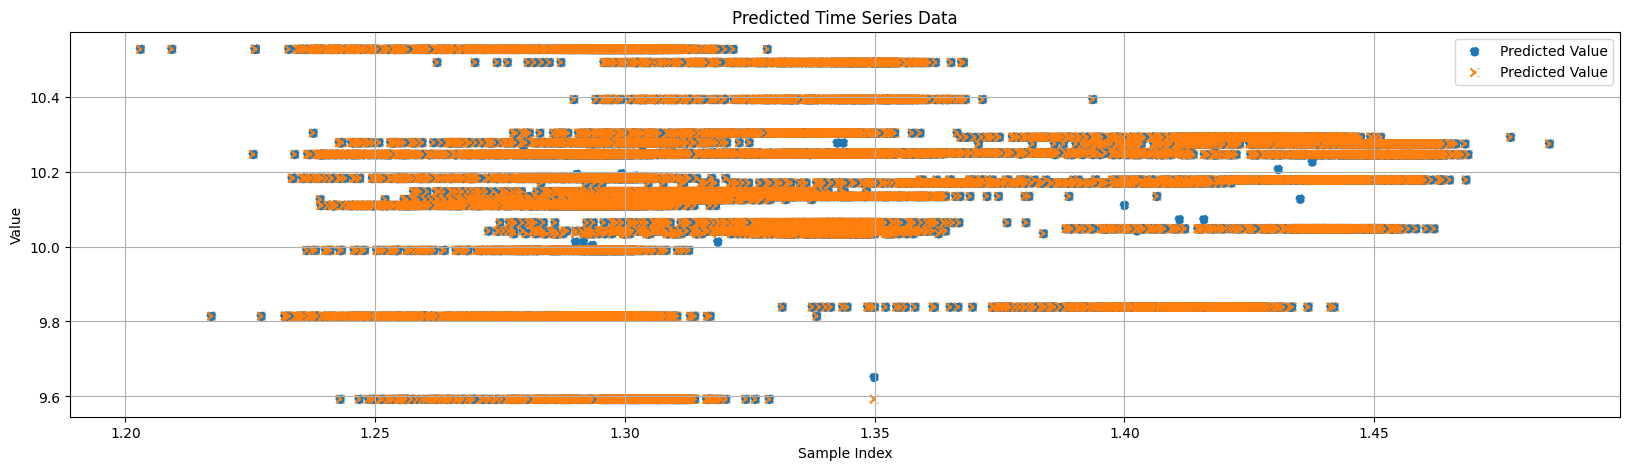

[1.2814 1.3013 1.355  ... 1.392  1.4132 1.2933]


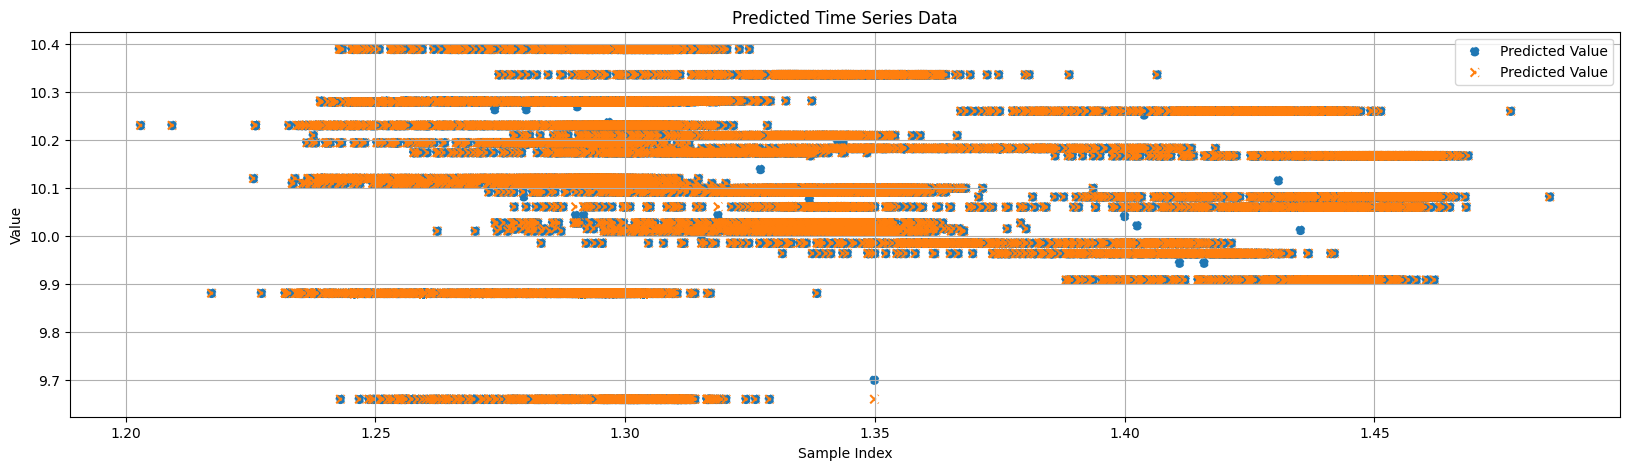

Model saved to ./model/API.pkl


In [163]:
model = TimeSeriesRandomForestRegressor(model_name=f"API", df=result['API'], target=targets, folds=2)
model.train()
# print(model.predict(result['API'].drop(columns=['TimeStamp', 'Batch', 'sample_time', 'sample_id'] + targets)))